In [2]:
%load_ext watermark
%watermark -v -p numpy,sklearn,scipy,matplotlib,tensorflow

CPython 3.5.5
IPython 6.3.0

numpy 1.14.2
sklearn 0.19.1
scipy 1.0.1
matplotlib 2.2.2
tensorflow 1.7.0


**11장 – 심층 신경망 훈련**

_이 노트북은 11장에 있는 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [3]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [4]:
import tensorflow as tf

# 연습문제 해답

## 1. to 7.

부록 A 참조.

## 8. 딥러닝

### 8.1.

_문제: He 초기화와 ELU 활성화 함수를 사용하여 각각 뉴런이 100개인 은닉층 다섯 개를 가진 DNN을 만드세요._

다음 연습문제도 비슷한 모델을 만들어야하므로 여기서 DNN을 구성하는 함수를 만들겠습니다:

In [5]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation,
                                     kernel_initializer=initializer,
                                     name="hidden%d" % (layer + 1))
        return inputs

Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
n_inputs = 28 * 28 # MNIST
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

### 8.2.

_문제: Adam 최적화와 조기 종료를 사용하여 MNIST 데이터셋에 훈련시키되 0에서 4까지의 숫자만 사용하세요. 다음 연습문제에서 5에서 9까지의 숫자에 대해 전이 학습을 사용할 것입니다. 출력층은 다섯 개의 뉴런에 소프트맥스 함수를 사용합니다. 나중에 재사용할 수 있도록 항상 일정한 간격으로 체크포인트와 최종 모델을 저장하세요._

비용 함수, 훈련 연산과 다른 필요한 구성 요소를 만듭니다:

In [7]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

MNIST 데이터셋을 로드합니다:

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)  # deprecated 경고 메세지를 출력하지 않기 위해 
mnist = input_data.read_data_sets("/tmp/data/")
tf.logging.set_verbosity(tf.logging.INFO)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


훈련 세트, 검증 세트, 테스트 세트를 만듭니다(검증 세트는 조기 종료에 사용합니다):

In [9]:
X_train1 = mnist.train.images[mnist.train.labels < 5]
y_train1 = mnist.train.labels[mnist.train.labels < 5]
X_valid1 = mnist.validation.images[mnist.validation.labels < 5]
y_valid1 = mnist.validation.labels[mnist.validation.labels < 5]
X_test1 = mnist.test.images[mnist.test.labels < 5]
y_test1 = mnist.test.labels[mnist.test.labels < 5]

In [10]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

0	검증 세트 손실: 0.144007	최선의 손실: 0.144007	정확도: 97.34%
1	검증 세트 손실: 0.124397	최선의 손실: 0.124397	정확도: 96.95%
2	검증 세트 손실: 0.185427	최선의 손실: 0.124397	정확도: 96.52%
3	검증 세트 손실: 0.147826	최선의 손실: 0.124397	정확도: 96.25%
4	검증 세트 손실: 0.145386	최선의 손실: 0.124397	정확도: 97.22%
5	검증 세트 손실: 0.134986	최선의 손실: 0.124397	정확도: 96.95%
6	검증 세트 손실: 0.259464	최선의 손실: 0.124397	정확도: 95.39%
7	검증 세트 손실: 0.230232	최선의 손실: 0.124397	정확도: 94.29%
8	검증 세트 손실: 0.158316	최선의 손실: 0.124397	정확도: 97.42%
9	검증 세트 손실: 0.268429	최선의 손실: 0.124397	정확도: 97.07%
10	검증 세트 손실: 0.147843	최선의 손실: 0.124397	정확도: 97.77%
11	검증 세트 손실: 0.393391	최선의 손실: 0.124397	정확도: 96.91%
12	검증 세트 손실: 0.180520	최선의 손실: 0.124397	정확도: 97.85%
13	검증 세트 손실: 0.145679	최선의 손실: 0.124397	정확도: 97.38%
14	검증 세트 손실: 0.649295	최선의 손실: 0.124397	정확도: 97.34%
15	검증 세트 손실: 0.179004	최선의 손실: 0.124397	정확도: 98.08%
16	검증 세트 손실: 0.228197	최선의 손실: 0.124397	정확도: 96.52%
17	검증 세트 손실: 0.263742	최선의 손실: 0.124397	정확도: 96.36%
18	검증 세트 손실: 1.248711	최선의 손실: 0.124397	정확도: 65.21%
19	검증 세트 손실: 2.936332	최선의 손실: 0.124397	정확

아주 나쁘지는 않지만 하이퍼파라미터를 튜닝하여 더 개선할 수 있을지 보겠습니다.

### 8.3.

_문제: 교차 검증을 사용하여 하이퍼파라미터를 튜닝하고 얼마의 성능을 달성할 수 있는지 확인해보세요._

하이퍼파라미터 튜닝을 하기 위해 사이킷런의 `RandomizedSearchCV` 클래스와 호환되는 `DNNClassifier` 클래스를 만듭니다. 이 클래스의 핵심은 다음과 같습니다:
* `__init__()` 메서드(생성자)는 각 하이퍼파라미터에 대한 인스턴스 변수를 만듭니다.
* `fit()` 메서드는 그래프를 만들고 세션을 시작해 모델을 훈련시킵니다:
  * `_build_graph()` 메서드를 호출해 그래프를 만듭니다(앞서 만든 그래프와 비슷합니다). 그래프가 만들어지면 다른 메서드에서 접근할 수 있도록 중요한 연산은 모두 인스턴스 변수로 저장합니다.
  * `_dnn()` 메서드는 위의 `dnn()` 함수와 비슷하게 은닉층을 만들고 배치 정규화와 드롭아웃을 추가합니다(다음 연습문제를 위해).
  * `fit()` 메서드에는 검증 세트(`X_valid`와 `y_valid`)가 주어지면 조기 종료를 실행합니다. 여기에서는 디스키 대신 메모리에 최상의 모델을 저장합니다. 이 함수는 그래프의 모든 변수와 값을 가져오기 위해 `_get_model_params()` 함수를 사용하고 (최상의 모델에서) 변수 값을 복원하기 위해 `_restore_model_params()` 함수를 사용합니다. 이런 방식은 훈련 속도를 높여 줍니다.
  * `fit()` 메서드가 모델 훈련을 마치면 예측을 만들기 위해 모델을 저장하고 복원하는 대신에 빠르게 예측을 만들기 위해 그대로 세션을 열어 둡니다. `close_session()` 메서드를 호출해 세션을 닫을 수 있습니다.
  * `predict_proba()` 메서드는 훈련 모델을 사용해 클래스 확률을 예측합니다.
  * `predict()` 메서드는 `predict_proba()`를 호출해 각 샘플에 대해 가장 높은 확률을 가진 클래스를 반환합니다.

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """모든 하이퍼파파미터를 저장하는 것으로 DNNClassifier를 초기화합니다."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """배치 정규화와 드롭아웃 기능을 넣어 은닉층을 구성합니다."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """이전과 동일한 모델을 만듭니다."""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # 중요한 연산은 인스턴스 변수로 저장하여 참조하기 쉽게 합니다.
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """모든 변수 값을 가져옵니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """모든 변수를 주어진 값으로 설정합니다 (조기 종료를 위해 사용하며 디스크에 저장하는 것보다 빠릅니다)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """훈련 세트에 모델을 훈련시킵니다. X_valid와 y_valid가 주어지면 조기 종료를 적용합니다."""
        self.close_session()

        # 훈련 세트로부터 n_inputs와 n_outputs를 구합니다.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # 레이블 벡터를 정렬된 클래스 인덱스 벡터로 변환합니다.
        # 0부터 n_outputs - 1까지의 정수를 담고 있게 됩니다.
        # 예를 들어, y가 [8, 8, 9, 5, 7, 6, 6, 6]이면 
        # 정렬된 클래스 레이블(self.classes_)은 [5, 6, 7, 8, 9]가 되고
        # 레이블 벡터는 [3, 3, 4, 0, 2, 1, 1, 1]로 변환됩니다.
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # 배치 정규화를 위한 추가 연산
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # 조기 종료를 위해
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # 이제 모델을 훈련합니다!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("조기 종료!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\t마지막 훈련 배치 손실: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # 조기 종료를 사용하면 이전의 최상의 모델로 되돌립니다.
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("%s 객체가 아직 훈련되지 않았습니다" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

이 클래스를 사용하여 이전과 비슷한 정확도가 나오는지 확인해 보죠(드롭아웃과 배치 정규화는 사용하지 않습니다):

In [12]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.461491	최선의 손실: 0.461491	정확도: 91.13%
1	검증 세트 손실: 0.100868	최선의 손실: 0.100868	정확도: 97.89%
2	검증 세트 손실: 1.099176	최선의 손실: 0.100868	정확도: 54.77%
3	검증 세트 손실: 1.359620	최선의 손실: 0.100868	정확도: 36.98%
4	검증 세트 손실: 1.630533	최선의 손실: 0.100868	정확도: 24.00%
5	검증 세트 손실: 1.642829	최선의 손실: 0.100868	정확도: 22.01%
6	검증 세트 손실: 1.676497	최선의 손실: 0.100868	정확도: 18.73%
7	검증 세트 손실: 1.767159	최선의 손실: 0.100868	정확도: 22.01%
8	검증 세트 손실: 1.700400	최선의 손실: 0.100868	정확도: 19.27%
9	검증 세트 손실: 1.763634	최선의 손실: 0.100868	정확도: 20.91%
10	검증 세트 손실: 1.629541	최선의 손실: 0.100868	정확도: 22.01%
11	검증 세트 손실: 1.812458	최선의 손실: 0.100868	정확도: 22.01%
12	검증 세트 손실: 1.675868	최선의 손실: 0.100868	정확도: 18.73%
13	검증 세트 손실: 1.633252	최선의 손실: 0.100868	정확도: 20.91%
14	검증 세트 손실: 1.652904	최선의 손실: 0.100868	정확도: 20.91%
15	검증 세트 손실: 1.635938	최선의 손실: 0.100868	정확도: 20.91%
16	검증 세트 손실: 1.718920	최선의 손실: 0.100868	정확도: 19.08%
17	검증 세트 손실: 1.682459	최선의 손실: 0.100868	정확도: 19.27%
18	검증 세트 손실: 1.675367	최선의 손실: 0.100868	정확도: 18.73%
19	검증 세트 손실: 1.645803	최선의 손실: 0.100868	정확

DNNClassifier(activation=<function elu at 0x7f99417cf6a8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

모델 훈련이 완료되면 이전과 비슷한 정확도가 나오는지 확인해 보겠습니다:

In [13]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9836544074722708

좋네요! 잘 작동합니다. 이제 사이킷런의 `RandomizedSearchCV` 클래스를 사용해서 더 나은 하이퍼파라미터를 찾아보겠습니다(시스템에 따라 이 작업은 한 시간 이상 걸릴지 모릅니다):

In [14]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # 은닉층의 수나 옵티마이저 등을 달리하여 탐색해 볼 수 있습니다.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

# 생성자에 넘겨주는 fit_params 매개변수는 사이킷런 0.19 버전부터 경고가 발생하고 0.21 버전에서 사라지므로
# 대신 fit() 메서드에 매개변수로 전달해야 합니다.:
rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=100, learning_rate=0.05, activation=<function elu at 0x7f99417cf6a8>, n_neurons=10 
0	검증 세트 손실: 0.152108	최선의 손실: 0.152108	정확도: 95.86%
1	검증 세트 손실: 0.135257	최선의 손실: 0.135257	정확도: 96.36%
2	검증 세트 손실: 0.124339	최선의 손실: 0.124339	정확도: 96.36%
3	검증 세트 손실: 0.150407	최선의 손실: 0.124339	정확도: 95.82%
4	검증 세트 손실: 0.187580	최선의 손실: 0.124339	정확도: 95.50%
5	검증 세트 손실: 0.114265	최선의 손실: 0.114265	정확도: 97.19%
6	검증 세트 손실: 0.106723	최선의 손실: 0.106723	정확도: 96.76%
7	검증 세트 손실: 1.613546	최선의 손실: 0.106723	정확도: 22.09%
8	검증 세트 손실: 1.577145	최선의 손실: 0.106723	정확도: 21.62%
9	검증 세트 손실: 1.616387	최선의 손실: 0.106723	정확도: 22.01%
10	검증 세트 손실: 1.616002	최선의 손실: 0.106723	정확도: 19.27%
11	검증 세트 손실: 1.610402	최선의 손실: 0.106723	정확도: 22.01%
12	검증 세트 손실: 1.624974	최선의 손실: 0.106723	정확도: 22.01%
13	검증 세트 손실: 1.643835	최선의 손실: 0.106723	정확도: 18.73%
14	검증 세트 손실: 1.614718	최선의 손실: 0.106723	정확도: 18.73%
15	검증 세트 손실: 1.612610	최선의 손실: 0.106723	정확도: 22.01%
16	검증 세트 손실: 1.620854	최선의 손실: 0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.8s remaining:    0.0s


0	검증 세트 손실: 0.189355	최선의 손실: 0.189355	정확도: 94.57%
1	검증 세트 손실: 0.117609	최선의 손실: 0.117609	정확도: 97.11%
2	검증 세트 손실: 0.187319	최선의 손실: 0.117609	정확도: 95.62%
3	검증 세트 손실: 0.128511	최선의 손실: 0.117609	정확도: 97.03%
4	검증 세트 손실: 0.109509	최선의 손실: 0.109509	정확도: 97.62%
5	검증 세트 손실: 0.147996	최선의 손실: 0.109509	정확도: 96.09%
6	검증 세트 손실: 0.124949	최선의 손실: 0.109509	정확도: 97.15%
7	검증 세트 손실: 0.238166	최선의 손실: 0.109509	정확도: 95.27%
8	검증 세트 손실: 0.134434	최선의 손실: 0.109509	정확도: 97.38%
9	검증 세트 손실: 1.457385	최선의 손실: 0.109509	정확도: 39.33%
10	검증 세트 손실: 1.230790	최선의 손실: 0.109509	정확도: 40.38%
11	검증 세트 손실: 1.177325	최선의 손실: 0.109509	정확도: 40.15%
12	검증 세트 손실: 1.160145	최선의 손실: 0.109509	정확도: 40.03%
13	검증 세트 손실: 1.162522	최선의 손실: 0.109509	정확도: 40.03%
14	검증 세트 손실: 1.170691	최선의 손실: 0.109509	정확도: 41.71%
15	검증 세트 손실: 1.167971	최선의 손실: 0.109509	정확도: 40.42%
16	검증 세트 손실: 1.166986	최선의 손실: 0.109509	정확도: 40.38%
17	검증 세트 손실: 1.154227	최선의 손실: 0.109509	정확도: 40.38%
18	검증 세트 손실: 1.159322	최선의 손실: 0.109509	정확도: 40.19%
19	검증 세트 손실: 1.157019	최선의 손실: 0.109509	정확

5	검증 세트 손실: 7.155737	최선의 손실: 6.584868	정확도: 85.11%
6	검증 세트 손실: 4.890808	최선의 손실: 4.890808	정확도: 92.03%
7	검증 세트 손실: 12.860675	최선의 손실: 4.890808	정확도: 81.86%
8	검증 세트 손실: 859.041443	최선의 손실: 4.890808	정확도: 27.76%
9	검증 세트 손실: 190.513977	최선의 손실: 4.890808	정확도: 36.90%
10	검증 세트 손실: 79.406662	최선의 손실: 4.890808	정확도: 41.59%
11	검증 세트 손실: 25.008566	최선의 손실: 4.890808	정확도: 39.68%
12	검증 세트 손실: 21.378765	최선의 손실: 4.890808	정확도: 45.82%
13	검증 세트 손실: 3055.117188	최선의 손실: 4.890808	정확도: 66.97%
14	검증 세트 손실: 1005.395020	최선의 손실: 4.890808	정확도: 84.60%
15	검증 세트 손실: 652.815125	최선의 손실: 4.890808	정확도: 84.60%
16	검증 세트 손실: 990.136841	최선의 손실: 4.890808	정확도: 79.16%
17	검증 세트 손실: 300.188873	최선의 손실: 4.890808	정확도: 89.60%
18	검증 세트 손실: 423.836945	최선의 손실: 4.890808	정확도: 85.93%
19	검증 세트 손실: 334.590240	최선의 손실: 4.890808	정확도: 90.62%
20	검증 세트 손실: 518.449402	최선의 손실: 4.890808	정확도: 84.60%
21	검증 세트 손실: 875.507996	최선의 손실: 4.890808	정확도: 79.44%
22	검증 세트 손실: 314.489838	최선의 손실: 4.890808	정확도: 90.70%
23	검증 세트 손실: 266.187439	최선의 손실: 4.890808	정확도: 89.33%
24	검

0	검증 세트 손실: 0.726552	최선의 손실: 0.726552	정확도: 94.10%
1	검증 세트 손실: 0.199025	최선의 손실: 0.199025	정확도: 95.66%
2	검증 세트 손실: 0.299734	최선의 손실: 0.199025	정확도: 95.90%
3	검증 세트 손실: 244759.000000	최선의 손실: 0.199025	정확도: 65.52%
4	검증 세트 손실: 30024.287109	최선의 손실: 0.199025	정확도: 84.48%
5	검증 세트 손실: 14391.659180	최선의 손실: 0.199025	정확도: 86.40%
6	검증 세트 손실: 9431.748047	최선의 손실: 0.199025	정확도: 87.69%
7	검증 세트 손실: 20141.632812	최선의 손실: 0.199025	정확도: 78.69%
8	검증 세트 손실: 8865.558594	최선의 손실: 0.199025	정확도: 88.47%
9	검증 세트 손실: 3610.484863	최선의 손실: 0.199025	정확도: 94.41%
10	검증 세트 손실: 6304.683594	최선의 손실: 0.199025	정확도: 93.71%
11	검증 세트 손실: 3026.992676	최선의 손실: 0.199025	정확도: 94.88%
12	검증 세트 손실: 6243.002441	최선의 손실: 0.199025	정확도: 89.80%
13	검증 세트 손실: 5048.999023	최선의 손실: 0.199025	정확도: 93.12%
14	검증 세트 손실: 2894.541260	최선의 손실: 0.199025	정확도: 94.29%
15	검증 세트 손실: 2206.543213	최선의 손실: 0.199025	정확도: 95.15%
16	검증 세트 손실: 1975.770142	최선의 손실: 0.199025	정확도: 95.74%
17	검증 세트 손실: 20622.431641	최선의 손실: 0.199025	정확도: 88.39%
18	검증 세트 손실: 5495.878906	최선의 손실: 0.199025

14	검증 세트 손실: 0.060439	최선의 손실: 0.040801	정확도: 98.63%
15	검증 세트 손실: 0.054385	최선의 손실: 0.040801	정확도: 98.75%
16	검증 세트 손실: 0.054502	최선의 손실: 0.040801	정확도: 98.91%
17	검증 세트 손실: 0.059543	최선의 손실: 0.040801	정확도: 98.94%
18	검증 세트 손실: 0.059768	최선의 손실: 0.040801	정확도: 98.71%
19	검증 세트 손실: 0.060284	최선의 손실: 0.040801	정확도: 98.63%
20	검증 세트 손실: 0.056557	최선의 손실: 0.040801	정확도: 98.67%
21	검증 세트 손실: 0.052929	최선의 손실: 0.040801	정확도: 98.79%
22	검증 세트 손실: 0.067156	최선의 손실: 0.040801	정확도: 98.83%
23	검증 세트 손실: 0.090359	최선의 손실: 0.040801	정확도: 98.55%
24	검증 세트 손실: 0.059252	최선의 손실: 0.040801	정확도: 98.79%
25	검증 세트 손실: 0.041968	최선의 손실: 0.040801	정확도: 99.14%
26	검증 세트 손실: 0.058532	최선의 손실: 0.040801	정확도: 98.87%
27	검증 세트 손실: 0.057262	최선의 손실: 0.040801	정확도: 98.94%
28	검증 세트 손실: 0.077395	최선의 손실: 0.040801	정확도: 98.63%
29	검증 세트 손실: 0.069821	최선의 손실: 0.040801	정확도: 98.83%
30	검증 세트 손실: 0.060456	최선의 손실: 0.040801	정확도: 98.87%
조기 종료!
[CV]  batch_size=500, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed97268>,

28	검증 세트 손실: 0.074703	최선의 손실: 0.046623	정확도: 98.59%
29	검증 세트 손실: 0.054141	최선의 손실: 0.046623	정확도: 98.87%
30	검증 세트 손실: 0.048089	최선의 손실: 0.046623	정확도: 98.98%
조기 종료!
[CV]  batch_size=500, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, n_neurons=140, total=   2.4s
[CV] batch_size=500, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, n_neurons=140 
0	검증 세트 손실: 0.139013	최선의 손실: 0.139013	정확도: 95.47%
1	검증 세트 손실: 0.081791	최선의 손실: 0.081791	정확도: 97.65%
2	검증 세트 손실: 0.065703	최선의 손실: 0.065703	정확도: 97.93%
3	검증 세트 손실: 0.054955	최선의 손실: 0.054955	정확도: 98.40%
4	검증 세트 손실: 0.056072	최선의 손실: 0.054955	정확도: 98.28%
5	검증 세트 손실: 0.052713	최선의 손실: 0.052713	정확도: 98.44%
6	검증 세트 손실: 0.053862	최선의 손실: 0.052713	정확도: 98.40%
7	검증 세트 손실: 0.049631	최선의 손실: 0.049631	정확도: 98.51%
8	검증 세트 손실: 0.046011	최선의 손실: 0.046011	정확도: 98.67%
9	검증 세트 손실: 0.047032	최선의 손실: 0.046011	정확도: 98.91%
10	검증 세트 손실: 0.068970	최선의 손실: 0.046011	정확도: 98.32%
11	검증 세트 손실: 0.054171	최선의 손실: 0.046011	정확도: 98.44%
12	검증 세트 손실: 0.061753

1	검증 세트 손실: 1.624506	최선의 손실: 1.624506	정확도: 19.27%
2	검증 세트 손실: 1.614148	최선의 손실: 1.614148	정확도: 19.27%
3	검증 세트 손실: 1.616997	최선의 손실: 1.614148	정확도: 19.27%
4	검증 세트 손실: 1.614503	최선의 손실: 1.614148	정확도: 22.01%
5	검증 세트 손실: 1.627702	최선의 손실: 1.614148	정확도: 22.01%
6	검증 세트 손실: 1.648679	최선의 손실: 1.614148	정확도: 19.27%
7	검증 세트 손실: 1.627600	최선의 손실: 1.614148	정확도: 18.73%
8	검증 세트 손실: 1.625684	최선의 손실: 1.614148	정확도: 22.01%
9	검증 세트 손실: 1.615555	최선의 손실: 1.614148	정확도: 20.91%
10	검증 세트 손실: 1.619122	최선의 손실: 1.614148	정확도: 22.01%
11	검증 세트 손실: 1.639598	최선의 손실: 1.614148	정확도: 22.01%
12	검증 세트 손실: 1.627612	최선의 손실: 1.614148	정확도: 19.08%
13	검증 세트 손실: 1.615013	최선의 손실: 1.614148	정확도: 19.08%
14	검증 세트 손실: 1.624332	최선의 손실: 1.614148	정확도: 19.08%
15	검증 세트 손실: 1.612442	최선의 손실: 1.612442	정확도: 22.01%
16	검증 세트 손실: 1.627837	최선의 손실: 1.612442	정확도: 22.01%
17	검증 세트 손실: 1.613230	최선의 손실: 1.612442	정확도: 18.73%
18	검증 세트 손실: 1.615751	최선의 손실: 1.612442	정확도: 22.01%
19	검증 세트 손실: 1.619094	최선의 손실: 1.612442	정확도: 22.01%
20	검증 세트 손실: 1.609109	최선의 손실: 1.609109	정

32	검증 세트 손실: 0.082798	최선의 손실: 0.072093	정확도: 98.24%
33	검증 세트 손실: 0.088828	최선의 손실: 0.072093	정확도: 98.24%
34	검증 세트 손실: 0.144066	최선의 손실: 0.072093	정확도: 97.93%
35	검증 세트 손실: 0.111487	최선의 손실: 0.072093	정확도: 98.16%
36	검증 세트 손실: 0.087607	최선의 손실: 0.072093	정확도: 98.44%
37	검증 세트 손실: 0.110404	최선의 손실: 0.072093	정확도: 98.24%
조기 종료!
[CV]  batch_size=100, learning_rate=0.02, activation=<function relu at 0x7f994177e9d8>, n_neurons=30, total=  18.5s
[CV] batch_size=100, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed97268>, n_neurons=50 
0	검증 세트 손실: 0.152535	최선의 손실: 0.152535	정확도: 95.90%
1	검증 세트 손실: 0.139352	최선의 손실: 0.139352	정확도: 96.13%
2	검증 세트 손실: 0.196786	최선의 손실: 0.139352	정확도: 94.64%
3	검증 세트 손실: 3.236673	최선의 손실: 0.139352	정확도: 35.77%
4	검증 세트 손실: 1.121514	최선의 손실: 0.139352	정확도: 54.73%
5	검증 세트 손실: 0.843739	최선의 손실: 0.139352	정확도: 66.77%
6	검증 세트 손실: 0.950402	최선의 손실: 0.139352	정확도: 65.17%
7	검증 세트 손실: 0.633643	최선의 손실: 0.139352	정확도: 78.11%
8	검증 세트 손실: 0.607917	최선의 손실: 0.

15	검증 세트 손실: 0.091740	최선의 손실: 0.057669	정확도: 97.97%
16	검증 세트 손실: 0.815509	최선의 손실: 0.057669	정확도: 96.21%
17	검증 세트 손실: 0.687379	최선의 손실: 0.057669	정확도: 93.55%
18	검증 세트 손실: 0.134047	최선의 손실: 0.057669	정확도: 97.73%
19	검증 세트 손실: 0.110551	최선의 손실: 0.057669	정확도: 98.12%
20	검증 세트 손실: 0.188607	최선의 손실: 0.057669	정확도: 97.54%
21	검증 세트 손실: 0.090257	최선의 손실: 0.057669	정확도: 98.28%
22	검증 세트 손실: 0.109700	최선의 손실: 0.057669	정확도: 97.46%
23	검증 세트 손실: 0.407096	최선의 손실: 0.057669	정확도: 94.80%
24	검증 세트 손실: 0.127601	최선의 손실: 0.057669	정확도: 97.65%
25	검증 세트 손실: 0.093802	최선의 손실: 0.057669	정확도: 98.05%
26	검증 세트 손실: 0.092848	최선의 손실: 0.057669	정확도: 98.28%
27	검증 세트 손실: 0.085425	최선의 손실: 0.057669	정확도: 98.20%
28	검증 세트 손실: 0.091840	최선의 손실: 0.057669	정확도: 98.16%
29	검증 세트 손실: 0.110013	최선의 손실: 0.057669	정확도: 98.16%
30	검증 세트 손실: 0.211727	최선의 손실: 0.057669	정확도: 97.19%
31	검증 세트 손실: 0.441088	최선의 손실: 0.057669	정확도: 97.89%
32	검증 세트 손실: 0.523083	최선의 손실: 0.057669	정확도: 98.01%
33	검증 세트 손실: 0.296272	최선의 손실: 0.057669	정확도: 98.01%
34	검증 세트 손실: 0.271759	최선의 손실: 0

16	검증 세트 손실: 0.153978	최선의 손실: 0.149292	정확도: 96.33%
17	검증 세트 손실: 0.169993	최선의 손실: 0.149292	정확도: 96.83%
18	검증 세트 손실: 0.159837	최선의 손실: 0.149292	정확도: 96.29%
19	검증 세트 손실: 0.137205	최선의 손실: 0.137205	정확도: 96.83%
20	검증 세트 손실: 0.140931	최선의 손실: 0.137205	정확도: 96.83%
21	검증 세트 손실: 0.141669	최선의 손실: 0.137205	정확도: 96.48%
22	검증 세트 손실: 0.127462	최선의 손실: 0.127462	정확도: 96.91%
23	검증 세트 손실: 0.145811	최선의 손실: 0.127462	정확도: 96.76%
24	검증 세트 손실: 0.142831	최선의 손실: 0.127462	정확도: 96.91%
25	검증 세트 손실: 0.146590	최선의 손실: 0.127462	정확도: 97.03%
26	검증 세트 손실: 0.158859	최선의 손실: 0.127462	정확도: 96.68%
27	검증 세트 손실: 0.172991	최선의 손실: 0.127462	정확도: 96.29%
28	검증 세트 손실: 0.135166	최선의 손실: 0.127462	정확도: 96.99%
29	검증 세트 손실: 0.170418	최선의 손실: 0.127462	정확도: 96.64%
30	검증 세트 손실: 0.149580	최선의 손실: 0.127462	정확도: 96.72%
31	검증 세트 손실: 0.141238	최선의 손실: 0.127462	정확도: 96.68%
32	검증 세트 손실: 0.144747	최선의 손실: 0.127462	정확도: 96.91%
33	검증 세트 손실: 0.137689	최선의 손실: 0.127462	정확도: 96.87%
34	검증 세트 손실: 0.128189	최선의 손실: 0.127462	정확도: 97.11%
35	검증 세트 손실: 0.138738	최선의 손실: 0

16	검증 세트 손실: 6.801213	최선의 손실: 0.391872	정확도: 37.57%
17	검증 세트 손실: 3.793837	최선의 손실: 0.391872	정확도: 19.27%
18	검증 세트 손실: 1.618412	최선의 손실: 0.391872	정확도: 22.01%
19	검증 세트 손실: 1.610003	최선의 손실: 0.391872	정확도: 22.01%
20	검증 세트 손실: 1.643316	최선의 손실: 0.391872	정확도: 19.27%
21	검증 세트 손실: 1.610561	최선의 손실: 0.391872	정확도: 22.01%
22	검증 세트 손실: 1.609754	최선의 손실: 0.391872	정확도: 22.01%
23	검증 세트 손실: 1.612017	최선의 손실: 0.391872	정확도: 22.01%
24	검증 세트 손실: 1.611107	최선의 손실: 0.391872	정확도: 22.01%
25	검증 세트 손실: 1.615096	최선의 손실: 0.391872	정확도: 22.01%
26	검증 세트 손실: 1.615750	최선의 손실: 0.391872	정확도: 22.01%
27	검증 세트 손실: 1.629283	최선의 손실: 0.391872	정확도: 22.01%
28	검증 세트 손실: 1.636984	최선의 손실: 0.391872	정확도: 18.73%
조기 종료!
[CV]  batch_size=500, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=50, total=   2.1s
[CV] batch_size=50, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed97268>, n_neurons=100 
0	검증 세트 손실: 1331.952637	최선의 손실: 1331.952637	정확도: 39.41%
1	검증 세트 손실: 6422.5351

32	검증 세트 손실: 5501.453125	최선의 손실: 0.461635	정확도: 94.92%
33	검증 세트 손실: 2935.468994	최선의 손실: 0.461635	정확도: 96.68%
34	검증 세트 손실: 5006.396973	최선의 손실: 0.461635	정확도: 94.18%
35	검증 세트 손실: 13359.974609	최선의 손실: 0.461635	정확도: 95.31%
조기 종료!
[CV]  batch_size=100, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=70, total=  20.1s
[CV] batch_size=100, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=70 
0	검증 세트 손실: 1.079257	최선의 손실: 1.079257	정확도: 93.28%
1	검증 세트 손실: 0.297304	최선의 손실: 0.297304	정확도: 95.31%
2	검증 세트 손실: 0.248445	최선의 손실: 0.248445	정확도: 94.96%
3	검증 세트 손실: 0.166490	최선의 손실: 0.166490	정확도: 96.44%
4	검증 세트 손실: 0.234731	최선의 손실: 0.166490	정확도: 95.19%
5	검증 세트 손실: 0.186308	최선의 손실: 0.166490	정확도: 96.40%
6	검증 세트 손실: 0.290339	최선의 손실: 0.166490	정확도: 95.43%
7	검증 세트 손실: 0.121503	최선의 손실: 0.121503	정확도: 97.26%
8	검증 세트 손실: 0.178362	최선의 손실: 0.121503	정확도: 96.01%
9	검증 세트 손실: 0.143887	최선의 손실: 0.12

2	검증 세트 손실: 2.174850	최선의 손실: 1.809967	정확도: 19.08%
3	검증 세트 손실: 2.142107	최선의 손실: 1.809967	정확도: 19.27%
4	검증 세트 손실: 3.099808	최선의 손실: 1.809967	정확도: 20.91%
5	검증 세트 손실: 2.463803	최선의 손실: 1.809967	정확도: 20.91%
6	검증 세트 손실: 2.003186	최선의 손실: 1.809967	정확도: 22.01%
7	검증 세트 손실: 1.763757	최선의 손실: 1.763757	정확도: 22.01%
8	검증 세트 손실: 1.700596	최선의 손실: 1.700596	정확도: 19.27%
9	검증 세트 손실: 2.334471	최선의 손실: 1.700596	정확도: 22.01%
10	검증 세트 손실: 1.853951	최선의 손실: 1.700596	정확도: 18.73%
11	검증 세트 손실: 1.842174	최선의 손실: 1.700596	정확도: 19.27%
12	검증 세트 손실: 2.091021	최선의 손실: 1.700596	정확도: 20.91%
13	검증 세트 손실: 3.280363	최선의 손실: 1.700596	정확도: 19.08%
14	검증 세트 손실: 2.147484	최선의 손실: 1.700596	정확도: 19.08%
15	검증 세트 손실: 1.816310	최선의 손실: 1.700596	정확도: 19.27%
16	검증 세트 손실: 1.802176	최선의 손실: 1.700596	정확도: 18.73%
17	검증 세트 손실: 2.435381	최선의 손실: 1.700596	정확도: 20.91%
18	검증 세트 손실: 1.970493	최선의 손실: 1.700596	정확도: 19.27%
19	검증 세트 손실: 2.368728	최선의 손실: 1.700596	정확도: 22.01%
20	검증 세트 손실: 2.211060	최선의 손실: 1.700596	정확도: 19.27%
21	검증 세트 손실: 2.549932	최선의 손실: 1.700596	

0	검증 세트 손실: 0.557426	최선의 손실: 0.557426	정확도: 87.18%
1	검증 세트 손실: 1.111108	최선의 손실: 0.557426	정확도: 63.29%
2	검증 세트 손실: 0.400892	최선의 손실: 0.400892	정확도: 84.56%
3	검증 세트 손실: 0.411816	최선의 손실: 0.400892	정확도: 86.90%
4	검증 세트 손실: 0.359184	최선의 손실: 0.359184	정확도: 88.19%
5	검증 세트 손실: 1.099694	최선의 손실: 0.359184	정확도: 59.15%
6	검증 세트 손실: 0.622663	최선의 손실: 0.359184	정확도: 74.94%
7	검증 세트 손실: 0.764234	최선의 손실: 0.359184	정확도: 68.96%
8	검증 세트 손실: 0.626890	최선의 손실: 0.359184	정확도: 74.51%
9	검증 세트 손실: 0.963785	최선의 손실: 0.359184	정확도: 66.42%
10	검증 세트 손실: 0.718695	최선의 손실: 0.359184	정확도: 69.27%
11	검증 세트 손실: 0.672607	최선의 손실: 0.359184	정확도: 77.52%
12	검증 세트 손실: 1.081294	최선의 손실: 0.359184	정확도: 60.56%
13	검증 세트 손실: 0.840021	최선의 손실: 0.359184	정확도: 70.52%
14	검증 세트 손실: 0.748317	최선의 손실: 0.359184	정확도: 76.08%
15	검증 세트 손실: 0.744548	최선의 손실: 0.359184	정확도: 74.08%
16	검증 세트 손실: 0.761264	최선의 손실: 0.359184	정확도: 72.20%
17	검증 세트 손실: 0.733307	최선의 손실: 0.359184	정확도: 71.97%
18	검증 세트 손실: 0.724354	최선의 손실: 0.359184	정확도: 72.56%
19	검증 세트 손실: 0.787100	최선의 손실: 0.359184	정확

17	검증 세트 손실: 0.884090	최선의 손실: 0.141311	정확도: 55.20%
18	검증 세트 손실: 0.257031	최선의 손실: 0.141311	정확도: 94.61%
19	검증 세트 손실: 0.291304	최선의 손실: 0.141311	정확도: 93.51%
20	검증 세트 손실: 0.238871	최선의 손실: 0.141311	정확도: 95.70%
21	검증 세트 손실: 0.275975	최선의 손실: 0.141311	정확도: 92.92%
22	검증 세트 손실: 0.392057	최선의 손실: 0.141311	정확도: 88.27%
조기 종료!
[CV]  batch_size=10, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, n_neurons=10, total= 1.7min
[CV] batch_size=10, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, n_neurons=10 
0	검증 세트 손실: 0.175297	최선의 손실: 0.175297	정확도: 95.74%
1	검증 세트 손실: 0.175310	최선의 손실: 0.175297	정확도: 95.23%
2	검증 세트 손실: 0.170198	최선의 손실: 0.170198	정확도: 95.82%
3	검증 세트 손실: 0.158704	최선의 손실: 0.158704	정확도: 96.48%
4	검증 세트 손실: 0.174055	최선의 손실: 0.158704	정확도: 95.50%
5	검증 세트 손실: 0.273801	최선의 손실: 0.158704	정확도: 94.61%
6	검증 세트 손실: 0.187173	최선의 손실: 0.158704	정확도: 95.82%
7	검증 세트 손실: 0.206855	최선의 손실: 0.158704	정확도: 95.47%
8	검증 세트 손실: 0.193623	최선의 손실: 0.158704	정확도: 96.21%
9	검증 세트 손실: 0.182015	최선의

42	검증 세트 손실: 0.151141	최선의 손실: 0.090290	정확도: 98.32%
43	검증 세트 손실: 0.147770	최선의 손실: 0.090290	정확도: 98.12%
44	검증 세트 손실: 0.147178	최선의 손실: 0.090290	정확도: 98.01%
45	검증 세트 손실: 0.159367	최선의 손실: 0.090290	정확도: 98.24%
46	검증 세트 손실: 0.138232	최선의 손실: 0.090290	정확도: 98.24%
47	검증 세트 손실: 0.169357	최선의 손실: 0.090290	정확도: 98.08%
48	검증 세트 손실: 0.132380	최선의 손실: 0.090290	정확도: 98.05%
49	검증 세트 손실: 0.187758	최선의 손실: 0.090290	정확도: 97.11%
50	검증 세트 손실: 0.125078	최선의 손실: 0.090290	정확도: 98.01%
51	검증 세트 손실: 0.122774	최선의 손실: 0.090290	정확도: 98.16%
52	검증 세트 손실: 0.150378	최선의 손실: 0.090290	정확도: 98.12%
53	검증 세트 손실: 0.127897	최선의 손실: 0.090290	정확도: 98.28%
54	검증 세트 손실: 0.146594	최선의 손실: 0.090290	정확도: 98.16%
조기 종료!
[CV]  batch_size=500, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=140, total=   4.6s
[CV] batch_size=500, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=140 
0	검증 세트 손실: 1.649060	최선의 손실: 1.64

13	검증 세트 손실: 0.092214	최선의 손실: 0.089402	정확도: 97.62%
14	검증 세트 손실: 0.079624	최선의 손실: 0.079624	정확도: 97.42%
15	검증 세트 손실: 0.086305	최선의 손실: 0.079624	정확도: 97.58%
16	검증 세트 손실: 0.096964	최선의 손실: 0.079624	정확도: 97.46%
17	검증 세트 손실: 0.101025	최선의 손실: 0.079624	정확도: 97.58%
18	검증 세트 손실: 0.090879	최선의 손실: 0.079624	정확도: 97.42%
19	검증 세트 손실: 0.091883	최선의 손실: 0.079624	정확도: 97.34%
20	검증 세트 손실: 0.089803	최선의 손실: 0.079624	정확도: 97.46%
21	검증 세트 손실: 0.095743	최선의 손실: 0.079624	정확도: 97.77%
22	검증 세트 손실: 0.090633	최선의 손실: 0.079624	정확도: 97.77%
23	검증 세트 손실: 0.099427	최선의 손실: 0.079624	정확도: 97.42%
24	검증 세트 손실: 0.117027	최선의 손실: 0.079624	정확도: 97.11%
25	검증 세트 손실: 0.090101	최선의 손실: 0.079624	정확도: 97.58%
26	검증 세트 손실: 0.095941	최선의 손실: 0.079624	정확도: 97.73%
27	검증 세트 손실: 0.112449	최선의 손실: 0.079624	정확도: 97.46%
28	검증 세트 손실: 0.089798	최선의 손실: 0.079624	정확도: 97.73%
29	검증 세트 손실: 0.110599	최선의 손실: 0.079624	정확도: 97.65%
30	검증 세트 손실: 0.098960	최선의 손실: 0.079624	정확도: 97.65%
31	검증 세트 손실: 0.104743	최선의 손실: 0.079624	정확도: 97.93%
32	검증 세트 손실: 0.120302	최선의 손실: 0

2	검증 세트 손실: 0.062222	최선의 손실: 0.062222	정확도: 98.05%
3	검증 세트 손실: 0.104538	최선의 손실: 0.062222	정확도: 97.62%
4	검증 세트 손실: 0.084856	최선의 손실: 0.062222	정확도: 98.12%
5	검증 세트 손실: 0.076951	최선의 손실: 0.062222	정확도: 98.16%
6	검증 세트 손실: 0.093877	최선의 손실: 0.062222	정확도: 97.73%
7	검증 세트 손실: 0.177094	최선의 손실: 0.062222	정확도: 97.42%
8	검증 세트 손실: 0.343613	최선의 손실: 0.062222	정확도: 97.50%
9	검증 세트 손실: 2.886327	최선의 손실: 0.062222	정확도: 34.75%
10	검증 세트 손실: 1.619923	최선의 손실: 0.062222	정확도: 18.73%
11	검증 세트 손실: 1.654726	최선의 손실: 0.062222	정확도: 22.01%
12	검증 세트 손실: 1.643674	최선의 손실: 0.062222	정확도: 22.01%
13	검증 세트 손실: 1.658978	최선의 손실: 0.062222	정확도: 18.73%
14	검증 세트 손실: 1.645270	최선의 손실: 0.062222	정확도: 22.01%
15	검증 세트 손실: 1.628464	최선의 손실: 0.062222	정확도: 19.08%
16	검증 세트 손실: 1.619229	최선의 손실: 0.062222	정확도: 19.27%
17	검증 세트 손실: 1.655719	최선의 손실: 0.062222	정확도: 20.91%
18	검증 세트 손실: 1.683712	최선의 손실: 0.062222	정확도: 22.01%
19	검증 세트 손실: 1.633460	최선의 손실: 0.062222	정확도: 19.27%
20	검증 세트 손실: 1.635544	최선의 손실: 0.062222	정확도: 18.73%
21	검증 세트 손실: 1.696720	최선의 손실: 0.062222	

3	검증 세트 손실: 3.274834	최선의 손실: 1.963861	정확도: 19.08%
4	검증 세트 손실: 2.903732	최선의 손실: 1.963861	정확도: 18.73%
5	검증 세트 손실: 3.447991	최선의 손실: 1.963861	정확도: 18.73%
6	검증 세트 손실: 2.066833	최선의 손실: 1.963861	정확도: 18.73%
7	검증 세트 손실: 2.595544	최선의 손실: 1.963861	정확도: 20.91%
8	검증 세트 손실: 3.108186	최선의 손실: 1.963861	정확도: 19.08%
9	검증 세트 손실: 2.555270	최선의 손실: 1.963861	정확도: 22.01%
10	검증 세트 손실: 2.184132	최선의 손실: 1.963861	정확도: 19.27%
11	검증 세트 손실: 3.077903	최선의 손실: 1.963861	정확도: 19.08%
12	검증 세트 손실: 2.305145	최선의 손실: 1.963861	정확도: 20.91%
13	검증 세트 손실: 2.891106	최선의 손실: 1.963861	정확도: 22.01%
14	검증 세트 손실: 3.594179	최선의 손실: 1.963861	정확도: 18.73%
15	검증 세트 손실: 3.116541	최선의 손실: 1.963861	정확도: 22.01%
16	검증 세트 손실: 4.077157	최선의 손실: 1.963861	정확도: 18.73%
17	검증 세트 손실: 3.712220	최선의 손실: 1.963861	정확도: 20.91%
18	검증 세트 손실: 2.785445	최선의 손실: 1.963861	정확도: 22.01%
19	검증 세트 손실: 3.980928	최선의 손실: 1.963861	정확도: 20.91%
20	검증 세트 손실: 3.714163	최선의 손실: 1.963861	정확도: 19.08%
21	검증 세트 손실: 2.121120	최선의 손실: 1.963861	정확도: 20.91%
조기 종료!
[CV]  batch_size=10, learning_r

12	검증 세트 손실: 1.628301	최선의 손실: 0.189469	정확도: 19.08%
13	검증 세트 손실: 1.629994	최선의 손실: 0.189469	정확도: 19.27%
14	검증 세트 손실: 1.621768	최선의 손실: 0.189469	정확도: 22.01%
15	검증 세트 손실: 1.616969	최선의 손실: 0.189469	정확도: 20.91%
16	검증 세트 손실: 1.626010	최선의 손실: 0.189469	정확도: 18.73%
17	검증 세트 손실: 1.609404	최선의 손실: 0.189469	정확도: 20.91%
18	검증 세트 손실: 1.666713	최선의 손실: 0.189469	정확도: 22.01%
19	검증 세트 손실: 1.634140	최선의 손실: 0.189469	정확도: 20.91%
20	검증 세트 손실: 1.658169	최선의 손실: 0.189469	정확도: 19.27%
21	검증 세트 손실: 1.670559	최선의 손실: 0.189469	정확도: 18.73%
22	검증 세트 손실: 1.645971	최선의 손실: 0.189469	정확도: 19.27%
23	검증 세트 손실: 1.710074	최선의 손실: 0.189469	정확도: 22.01%
24	검증 세트 손실: 1.684467	최선의 손실: 0.189469	정확도: 18.73%
조기 종료!
[CV]  batch_size=100, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=90, total=   9.8s
[CV] batch_size=100, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=90 
0	검증 세트 손실: 0.271728	최선의 손실: 0.271728	정확도: 91.87%
1	검증 세트 손실: 0.166530	최선의 손실: 0.166530	정확도: 95.04%
2	검증 세트 손실: 0.158

8	검증 세트 손실: 0.059329	최선의 손실: 0.059329	정확도: 98.32%
9	검증 세트 손실: 0.059631	최선의 손실: 0.059329	정확도: 98.40%
10	검증 세트 손실: 0.061598	최선의 손실: 0.059329	정확도: 98.44%
11	검증 세트 손실: 0.065848	최선의 손실: 0.059329	정확도: 98.24%
12	검증 세트 손실: 0.069765	최선의 손실: 0.059329	정확도: 98.24%
13	검증 세트 손실: 0.071521	최선의 손실: 0.059329	정확도: 98.05%
14	검증 세트 손실: 0.068203	최선의 손실: 0.059329	정확도: 98.36%
15	검증 세트 손실: 0.070240	최선의 손실: 0.059329	정확도: 98.16%
16	검증 세트 손실: 0.088610	최선의 손실: 0.059329	정확도: 97.89%
17	검증 세트 손실: 0.058584	최선의 손실: 0.058584	정확도: 98.36%
18	검증 세트 손실: 0.091615	최선의 손실: 0.058584	정확도: 98.32%
19	검증 세트 손실: 0.069207	최선의 손실: 0.058584	정확도: 98.59%
20	검증 세트 손실: 0.066283	최선의 손실: 0.058584	정확도: 98.51%
21	검증 세트 손실: 0.108184	최선의 손실: 0.058584	정확도: 97.97%
22	검증 세트 손실: 0.071178	최선의 손실: 0.058584	정확도: 98.48%
23	검증 세트 손실: 0.105811	최선의 손실: 0.058584	정확도: 98.36%
24	검증 세트 손실: 0.115762	최선의 손실: 0.058584	정확도: 97.54%
25	검증 세트 손실: 0.073354	최선의 손실: 0.058584	정확도: 98.36%
26	검증 세트 손실: 0.075891	최선의 손실: 0.058584	정확도: 98.59%
27	검증 세트 손실: 0.079764	최선의 손실: 0.0

12	검증 세트 손실: 0.072005	최선의 손실: 0.055678	정확도: 98.05%
13	검증 세트 손실: 0.100109	최선의 손실: 0.055678	정확도: 98.05%
14	검증 세트 손실: 0.087967	최선의 손실: 0.055678	정확도: 98.01%
15	검증 세트 손실: 0.058833	최선의 손실: 0.055678	정확도: 98.48%
16	검증 세트 손실: 0.074368	최선의 손실: 0.055678	정확도: 98.59%
17	검증 세트 손실: 0.074334	최선의 손실: 0.055678	정확도: 98.51%
18	검증 세트 손실: 0.079316	최선의 손실: 0.055678	정확도: 98.40%
19	검증 세트 손실: 0.086600	최선의 손실: 0.055678	정확도: 98.08%
20	검증 세트 손실: 0.175397	최선의 손실: 0.055678	정확도: 98.51%
21	검증 세트 손실: 0.089505	최선의 손실: 0.055678	정확도: 98.16%
22	검증 세트 손실: 0.075199	최선의 손실: 0.055678	정확도: 98.48%
23	검증 세트 손실: 0.119482	최선의 손실: 0.055678	정확도: 98.36%
24	검증 세트 손실: 0.074329	최선의 손실: 0.055678	정확도: 98.55%
25	검증 세트 손실: 0.099184	최선의 손실: 0.055678	정확도: 98.20%
26	검증 세트 손실: 0.126611	최선의 손실: 0.055678	정확도: 96.99%
27	검증 세트 손실: 0.091845	최선의 손실: 0.055678	정확도: 98.24%
28	검증 세트 손실: 0.143131	최선의 손실: 0.055678	정확도: 98.16%
조기 종료!
[CV]  batch_size=100, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, n_neurons=30, total=  10.2s
[CV] batch

15	검증 세트 손실: 0.079539	최선의 손실: 0.068599	정확도: 98.12%
16	검증 세트 손실: 0.084038	최선의 손실: 0.068599	정확도: 98.12%
17	검증 세트 손실: 0.076966	최선의 손실: 0.068599	정확도: 98.01%
18	검증 세트 손실: 0.071891	최선의 손실: 0.068599	정확도: 98.24%
19	검증 세트 손실: 0.117910	최선의 손실: 0.068599	정확도: 97.97%
20	검증 세트 손실: 0.090368	최선의 손실: 0.068599	정확도: 98.24%
21	검증 세트 손실: 0.085518	최선의 손실: 0.068599	정확도: 98.16%
22	검증 세트 손실: 0.082713	최선의 손실: 0.068599	정확도: 98.08%
23	검증 세트 손실: 0.100054	최선의 손실: 0.068599	정확도: 98.01%
24	검증 세트 손실: 0.096238	최선의 손실: 0.068599	정확도: 98.08%
25	검증 세트 손실: 0.111319	최선의 손실: 0.068599	정확도: 97.93%
26	검증 세트 손실: 0.098903	최선의 손실: 0.068599	정확도: 97.93%
27	검증 세트 손실: 0.100849	최선의 손실: 0.068599	정확도: 98.44%
28	검증 세트 손실: 0.076003	최선의 손실: 0.068599	정확도: 98.44%
29	검증 세트 손실: 0.083883	최선의 손실: 0.068599	정확도: 98.51%
30	검증 세트 손실: 0.107264	최선의 손실: 0.068599	정확도: 98.08%
31	검증 세트 손실: 0.086958	최선의 손실: 0.068599	정확도: 98.48%
32	검증 세트 손실: 0.077220	최선의 손실: 0.068599	정확도: 98.32%
33	검증 세트 손실: 0.085715	최선의 손실: 0.068599	정확도: 98.48%
34	검증 세트 손실: 0.106794	최선의 손실: 0

17	검증 세트 손실: 37.190468	최선의 손실: 0.257276	정확도: 96.17%
18	검증 세트 손실: 100.990433	최선의 손실: 0.257276	정확도: 95.04%
19	검증 세트 손실: 26.503275	최선의 손실: 0.257276	정확도: 95.00%
20	검증 세트 손실: 36.062477	최선의 손실: 0.257276	정확도: 97.77%
21	검증 세트 손실: 11.017694	최선의 손실: 0.257276	정확도: 97.15%
22	검증 세트 손실: 17.413185	최선의 손실: 0.257276	정확도: 96.25%
23	검증 세트 손실: 51.923813	최선의 손실: 0.257276	정확도: 96.17%
24	검증 세트 손실: 74.670090	최선의 손실: 0.257276	정확도: 93.16%
조기 종료!
[CV]  batch_size=10, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=90, total= 2.0min
[CV] batch_size=10, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=90 
0	검증 세트 손실: 0.123462	최선의 손실: 0.123462	정확도: 96.44%
1	검증 세트 손실: 0.130036	최선의 손실: 0.123462	정확도: 97.19%
2	검증 세트 손실: 1.331930	최선의 손실: 0.123462	정확도: 95.54%
3	검증 세트 손실: 0.682557	최선의 손실: 0.123462	정확도: 94.53%
4	검증 세트 손실: 811.273804	최선의 손실: 0.123462	정확도: 89.80%
5	검증 세트 손실: 2.688985	최선의 손실: 0.

10	검증 세트 손실: 1.622938	최선의 손실: 0.073965	정확도: 20.91%
11	검증 세트 손실: 1.618586	최선의 손실: 0.073965	정확도: 19.08%
12	검증 세트 손실: 1.621902	최선의 손실: 0.073965	정확도: 19.27%
13	검증 세트 손실: 1.615610	최선의 손실: 0.073965	정확도: 20.91%
14	검증 세트 손실: 1.621776	최선의 손실: 0.073965	정확도: 22.01%
15	검증 세트 손실: 1.628085	최선의 손실: 0.073965	정확도: 19.08%
16	검증 세트 손실: 1.658137	최선의 손실: 0.073965	정확도: 18.73%
17	검증 세트 손실: 1.701497	최선의 손실: 0.073965	정확도: 19.27%
18	검증 세트 손실: 1.648183	최선의 손실: 0.073965	정확도: 22.01%
19	검증 세트 손실: 1.634995	최선의 손실: 0.073965	정확도: 20.91%
20	검증 세트 손실: 1.623821	최선의 손실: 0.073965	정확도: 20.91%
21	검증 세트 손실: 1.630844	최선의 손실: 0.073965	정확도: 19.27%
22	검증 세트 손실: 1.658025	최선의 손실: 0.073965	정확도: 18.73%
23	검증 세트 손실: 1.619369	최선의 손실: 0.073965	정확도: 19.08%
24	검증 세트 손실: 1.641589	최선의 손실: 0.073965	정확도: 22.01%
조기 종료!
[CV]  batch_size=100, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, n_neurons=50, total=   4.9s
[CV] batch_size=100, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, n_neurons=50 
0	검증 세트 손실: 0

18	검증 세트 손실: 0.117808	최선의 손실: 0.093039	정확도: 97.22%
19	검증 세트 손실: 0.155116	최선의 손실: 0.093039	정확도: 96.99%
20	검증 세트 손실: 0.129246	최선의 손실: 0.093039	정확도: 97.34%
21	검증 세트 손실: 0.154954	최선의 손실: 0.093039	정확도: 96.21%
22	검증 세트 손실: 0.101678	최선의 손실: 0.093039	정확도: 97.34%
23	검증 세트 손실: 0.123998	최선의 손실: 0.093039	정확도: 97.26%
24	검증 세트 손실: 0.115114	최선의 손실: 0.093039	정확도: 97.11%
25	검증 세트 손실: 0.099806	최선의 손실: 0.093039	정확도: 97.69%
26	검증 세트 손실: 0.099427	최선의 손실: 0.093039	정확도: 97.54%
27	검증 세트 손실: 0.085041	최선의 손실: 0.085041	정확도: 97.54%
28	검증 세트 손실: 0.125900	최선의 손실: 0.085041	정확도: 96.95%
29	검증 세트 손실: 0.109399	최선의 손실: 0.085041	정확도: 97.69%
30	검증 세트 손실: 0.095834	최선의 손실: 0.085041	정확도: 97.65%
31	검증 세트 손실: 0.109296	최선의 손실: 0.085041	정확도: 97.58%
32	검증 세트 손실: 0.138597	최선의 손실: 0.085041	정확도: 96.99%
33	검증 세트 손실: 0.110600	최선의 손실: 0.085041	정확도: 97.30%
34	검증 세트 손실: 0.147475	최선의 손실: 0.085041	정확도: 96.91%
35	검증 세트 손실: 0.098015	최선의 손실: 0.085041	정확도: 97.50%
36	검증 세트 손실: 0.112714	최선의 손실: 0.085041	정확도: 97.30%
37	검증 세트 손실: 0.096248	최선의 손실: 0

45	검증 세트 손실: 0.286172	최선의 손실: 0.043505	정확도: 98.16%
46	검증 세트 손실: 0.707332	최선의 손실: 0.043505	정확도: 96.01%
47	검증 세트 손실: 0.146919	최선의 손실: 0.043505	정확도: 97.73%
조기 종료!
[CV]  batch_size=100, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, n_neurons=120, total=  25.9s
[CV] batch_size=100, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, n_neurons=120 
0	검증 세트 손실: 0.067246	최선의 손실: 0.067246	정확도: 98.08%
1	검증 세트 손실: 0.073896	최선의 손실: 0.067246	정확도: 97.69%
2	검증 세트 손실: 0.055876	최선의 손실: 0.055876	정확도: 98.20%
3	검증 세트 손실: 0.091007	최선의 손실: 0.055876	정확도: 97.58%
4	검증 세트 손실: 0.080946	최선의 손실: 0.055876	정확도: 98.20%
5	검증 세트 손실: 0.064551	최선의 손실: 0.055876	정확도: 98.55%
6	검증 세트 손실: 0.095393	최선의 손실: 0.055876	정확도: 97.58%
7	검증 세트 손실: 0.151538	최선의 손실: 0.055876	정확도: 97.81%
8	검증 세트 손실: 0.075075	최선의 손실: 0.055876	정확도: 98.44%
9	검증 세트 손실: 0.152018	최선의 손실: 0.055876	정확도: 97.69%
10	검증 세트 손실: 0.106562	최선의 손실: 0.055876	정확도: 98.01%
11	검증 세트 손실: 0.078981	최선의 손실: 0.055876	정확도: 98.48%
12	검증 세트 손실: 0.0656

18	검증 세트 손실: 1.201473	최선의 손실: 0.137723	정확도: 39.99%
19	검증 세트 손실: 1.203602	최선의 손실: 0.137723	정확도: 39.99%
20	검증 세트 손실: 1.204841	최선의 손실: 0.137723	정확도: 36.75%
21	검증 세트 손실: 1.203644	최선의 손실: 0.137723	정확도: 39.99%
22	검증 세트 손실: 1.204627	최선의 손실: 0.137723	정확도: 39.99%
23	검증 세트 손실: 1.204855	최선의 손실: 0.137723	정확도: 39.99%
24	검증 세트 손실: 1.201652	최선의 손실: 0.137723	정확도: 38.90%
조기 종료!
[CV]  batch_size=10, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, n_neurons=120, total= 2.1min
[CV] batch_size=500, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>, n_neurons=100 
0	검증 세트 손실: 294.072998	최선의 손실: 294.072998	정확도: 55.36%
1	검증 세트 손실: 9.411483	최선의 손실: 9.411483	정확도: 94.53%
2	검증 세트 손실: 3.487891	최선의 손실: 3.487891	정확도: 95.04%
3	검증 세트 손실: 1.285705	최선의 손실: 1.285705	정확도: 95.27%
4	검증 세트 손실: 0.828561	최선의 손실: 0.828561	정확도: 96.64%
5	검증 세트 손실: 1.328397	최선의 손실: 0.828561	정확도: 95.78%
6	검증 세트 손실: 0.768011	최선의 손실: 0.768011	정확도: 96.48%
7	검증 세트 손실: 2.023814	최선의 손

0	검증 세트 손실: 0.136163	최선의 손실: 0.136163	정확도: 96.64%
1	검증 세트 손실: 0.060144	최선의 손실: 0.060144	정확도: 98.05%
2	검증 세트 손실: 0.070559	최선의 손실: 0.060144	정확도: 97.77%
3	검증 세트 손실: 0.048422	최선의 손실: 0.048422	정확도: 98.36%
4	검증 세트 손실: 0.062384	최선의 손실: 0.048422	정확도: 98.20%
5	검증 세트 손실: 0.069186	최선의 손실: 0.048422	정확도: 98.32%
6	검증 세트 손실: 0.063494	최선의 손실: 0.048422	정확도: 98.44%
7	검증 세트 손실: 0.073359	최선의 손실: 0.048422	정확도: 98.44%
8	검증 세트 손실: 0.062817	최선의 손실: 0.048422	정확도: 98.63%
9	검증 세트 손실: 0.057873	최선의 손실: 0.048422	정확도: 98.67%
10	검증 세트 손실: 0.080888	최선의 손실: 0.048422	정확도: 98.51%
11	검증 세트 손실: 0.080761	최선의 손실: 0.048422	정확도: 98.40%
12	검증 세트 손실: 0.077064	최선의 손실: 0.048422	정확도: 98.40%
13	검증 세트 손실: 0.060489	최선의 손실: 0.048422	정확도: 98.75%
14	검증 세트 손실: 0.069909	최선의 손실: 0.048422	정확도: 98.48%
15	검증 세트 손실: 0.063728	최선의 손실: 0.048422	정확도: 98.79%
16	검증 세트 손실: 0.057476	최선의 손실: 0.048422	정확도: 98.67%
17	검증 세트 손실: 0.069101	최선의 손실: 0.048422	정확도: 98.75%
18	검증 세트 손실: 0.087961	최선의 손실: 0.048422	정확도: 98.51%
19	검증 세트 손실: 0.076209	최선의 손실: 0.048422	정확

20	검증 세트 손실: 1.930350	최선의 손실: 1.647474	정확도: 18.73%
21	검증 세트 손실: 1.900985	최선의 손실: 1.647474	정확도: 22.01%
22	검증 세트 손실: 1.750338	최선의 손실: 1.647474	정확도: 19.27%
23	검증 세트 손실: 2.205183	최선의 손실: 1.647474	정확도: 18.73%
24	검증 세트 손실: 1.718396	최선의 손실: 1.647474	정확도: 22.01%
25	검증 세트 손실: 1.836215	최선의 손실: 1.647474	정확도: 22.01%
26	검증 세트 손실: 1.777828	최선의 손실: 1.647474	정확도: 22.01%
27	검증 세트 손실: 1.763804	최선의 손실: 1.647474	정확도: 19.27%
28	검증 세트 손실: 1.860309	최선의 손실: 1.647474	정확도: 19.27%
29	검증 세트 손실: 1.954945	최선의 손실: 1.647474	정확도: 18.73%
30	검증 세트 손실: 1.838278	최선의 손실: 1.647474	정확도: 18.73%
31	검증 세트 손실: 1.988403	최선의 손실: 1.647474	정확도: 22.01%
32	검증 세트 손실: 2.001386	최선의 손실: 1.647474	정확도: 19.27%
조기 종료!
[CV]  batch_size=10, learning_rate=0.05, activation=<function elu at 0x7f99417cf6a8>, n_neurons=30, total= 2.3min
[CV] batch_size=10, learning_rate=0.05, activation=<function elu at 0x7f99417cf6a8>, n_neurons=30 
0	검증 세트 손실: 1.642422	최선의 손실: 1.642422	정확도: 19.27%
1	검증 세트 손실: 1.853892	최선의 손실: 1.642422	정확도: 19.08%
2	검증 세트 손실: 1.737

9	검증 세트 손실: 0.726363	최선의 손실: 0.145668	정확도: 87.96%
10	검증 세트 손실: 0.391932	최선의 손실: 0.145668	정확도: 95.54%
11	검증 세트 손실: 0.198357	최선의 손실: 0.145668	정확도: 95.54%
12	검증 세트 손실: 0.226283	최선의 손실: 0.145668	정확도: 96.05%
13	검증 세트 손실: 0.161128	최선의 손실: 0.145668	정확도: 96.29%
14	검증 세트 손실: 0.162096	최선의 손실: 0.145668	정확도: 96.36%
15	검증 세트 손실: 0.351059	최선의 손실: 0.145668	정확도: 96.48%
16	검증 세트 손실: 9.810344	최선의 손실: 0.145668	정확도: 85.57%
17	검증 세트 손실: 4.489713	최선의 손실: 0.145668	정확도: 93.78%
18	검증 세트 손실: 2.079704	최선의 손실: 0.145668	정확도: 94.53%
19	검증 세트 손실: 2.270699	최선의 손실: 0.145668	정확도: 93.78%
20	검증 세트 손실: 1.559015	최선의 손실: 0.145668	정확도: 94.41%
21	검증 세트 손실: 2.625832	최선의 손실: 0.145668	정확도: 91.63%
조기 종료!
[CV]  batch_size=50, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed97268>, n_neurons=100, total=  20.6s
[CV] batch_size=50, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed97268>, n_neurons=100 
0	검증 세트 손실: 0.154353	최선의 손실: 0.15435

4	검증 세트 손실: 2.686582	최선의 손실: 1.783779	정확도: 19.08%
5	검증 세트 손실: 1.852321	최선의 손실: 1.783779	정확도: 20.91%
6	검증 세트 손실: 1.812496	최선의 손실: 1.783779	정확도: 22.01%
7	검증 세트 손실: 1.757771	최선의 손실: 1.757771	정확도: 19.08%
8	검증 세트 손실: 1.902283	최선의 손실: 1.757771	정확도: 19.27%
9	검증 세트 손실: 2.087057	최선의 손실: 1.757771	정확도: 19.27%
10	검증 세트 손실: 1.779784	최선의 손실: 1.757771	정확도: 18.73%
11	검증 세트 손실: 2.227396	최선의 손실: 1.757771	정확도: 19.27%
12	검증 세트 손실: 1.950018	최선의 손실: 1.757771	정확도: 20.91%
13	검증 세트 손실: 3.099453	최선의 손실: 1.757771	정확도: 19.08%
14	검증 세트 손실: 1.830344	최선의 손실: 1.757771	정확도: 22.01%
15	검증 세트 손실: 1.733783	최선의 손실: 1.733783	정확도: 20.91%
16	검증 세트 손실: 2.189536	최선의 손실: 1.733783	정확도: 18.73%
17	검증 세트 손실: 1.943920	최선의 손실: 1.733783	정확도: 18.73%
18	검증 세트 손실: 1.848899	최선의 손실: 1.733783	정확도: 19.08%
19	검증 세트 손실: 1.984283	최선의 손실: 1.733783	정확도: 18.73%
20	검증 세트 손실: 1.919440	최선의 손실: 1.733783	정확도: 19.27%
21	검증 세트 손실: 2.156083	최선의 손실: 1.733783	정확도: 22.01%
22	검증 세트 손실: 1.834820	최선의 손실: 1.733783	정확도: 19.27%
23	검증 세트 손실: 2.444077	최선의 손실: 1.73378

0	검증 세트 손실: 0.771589	최선의 손실: 0.771589	정확도: 74.98%
1	검증 세트 손실: 26.960949	최선의 손실: 0.771589	정확도: 70.25%
2	검증 세트 손실: 1.635355	최선의 손실: 0.771589	정확도: 18.73%
3	검증 세트 손실: 1.619329	최선의 손실: 0.771589	정확도: 19.08%
4	검증 세트 손실: 1.689969	최선의 손실: 0.771589	정확도: 19.27%
5	검증 세트 손실: 1.628324	최선의 손실: 0.771589	정확도: 22.01%
6	검증 세트 손실: 1.671623	최선의 손실: 0.771589	정확도: 19.27%
7	검증 세트 손실: 1.636309	최선의 손실: 0.771589	정확도: 19.27%
8	검증 세트 손실: 1.625584	최선의 손실: 0.771589	정확도: 19.08%
9	검증 세트 손실: 1.736851	최선의 손실: 0.771589	정확도: 19.27%
10	검증 세트 손실: 1.694749	최선의 손실: 0.771589	정확도: 22.01%
11	검증 세트 손실: 1.811687	최선의 손실: 0.771589	정확도: 19.08%
12	검증 세트 손실: 1.690879	최선의 손실: 0.771589	정확도: 19.08%
13	검증 세트 손실: 1.760164	최선의 손실: 0.771589	정확도: 20.91%
14	검증 세트 손실: 1.826802	최선의 손실: 0.771589	정확도: 22.01%
15	검증 세트 손실: 1.757212	최선의 손실: 0.771589	정확도: 22.01%
16	검증 세트 손실: 1.793381	최선의 손실: 0.771589	정확도: 19.08%
17	검증 세트 손실: 1.944023	최선의 손실: 0.771589	정확도: 20.91%
18	검증 세트 손실: 1.742110	최선의 손실: 0.771589	정확도: 22.01%
19	검증 세트 손실: 1.753960	최선의 손실: 0.771589	정

0	검증 세트 손실: 0.123865	최선의 손실: 0.123865	정확도: 96.72%
1	검증 세트 손실: 0.389060	최선의 손실: 0.123865	정확도: 93.78%
2	검증 세트 손실: 0.135307	최선의 손실: 0.123865	정확도: 96.68%
3	검증 세트 손실: 0.135571	최선의 손실: 0.123865	정확도: 97.22%
4	검증 세트 손실: 0.171853	최선의 손실: 0.123865	정확도: 97.07%
5	검증 세트 손실: 0.084773	최선의 손실: 0.084773	정확도: 97.62%
6	검증 세트 손실: 0.454981	최선의 손실: 0.084773	정확도: 91.28%
7	검증 세트 손실: 1.709035	최선의 손실: 0.084773	정확도: 18.73%
8	검증 세트 손실: 1.747327	최선의 손실: 0.084773	정확도: 22.01%
9	검증 세트 손실: 1.892869	최선의 손실: 0.084773	정확도: 20.91%
10	검증 세트 손실: 1.695854	최선의 손실: 0.084773	정확도: 18.73%
11	검증 세트 손실: 1.906526	최선의 손실: 0.084773	정확도: 18.73%
12	검증 세트 손실: 1.722814	최선의 손실: 0.084773	정확도: 19.08%
13	검증 세트 손실: 1.619644	최선의 손실: 0.084773	정확도: 22.01%
14	검증 세트 손실: 1.678113	최선의 손실: 0.084773	정확도: 19.08%
15	검증 세트 손실: 1.624077	최선의 손실: 0.084773	정확도: 22.01%
16	검증 세트 손실: 1.632909	최선의 손실: 0.084773	정확도: 18.73%
17	검증 세트 손실: 1.668706	최선의 손실: 0.084773	정확도: 18.73%
18	검증 세트 손실: 1.633563	최선의 손실: 0.084773	정확도: 22.01%
19	검증 세트 손실: 1.754125	최선의 손실: 0.084773	정확

38	검증 세트 손실: 0.473195	최선의 손실: 0.150097	정확도: 93.00%
39	검증 세트 손실: 0.215336	최선의 손실: 0.150097	정확도: 96.33%
40	검증 세트 손실: 0.203254	최선의 손실: 0.150097	정확도: 96.68%
41	검증 세트 손실: 0.197062	최선의 손실: 0.150097	정확도: 96.60%
42	검증 세트 손실: 0.208500	최선의 손실: 0.150097	정확도: 96.52%
43	검증 세트 손실: 0.190903	최선의 손실: 0.150097	정확도: 96.09%
44	검증 세트 손실: 0.145707	최선의 손실: 0.145707	정확도: 96.95%
45	검증 세트 손실: 0.153758	최선의 손실: 0.145707	정확도: 97.07%
46	검증 세트 손실: 0.177501	최선의 손실: 0.145707	정확도: 96.99%
47	검증 세트 손실: 0.183252	최선의 손실: 0.145707	정확도: 96.72%
48	검증 세트 손실: 0.186533	최선의 손실: 0.145707	정확도: 96.72%
49	검증 세트 손실: 0.187364	최선의 손실: 0.145707	정확도: 96.87%
50	검증 세트 손실: 0.203390	최선의 손실: 0.145707	정확도: 96.87%
51	검증 세트 손실: 0.175550	최선의 손실: 0.145707	정확도: 97.19%
52	검증 세트 손실: 0.190425	최선의 손실: 0.145707	정확도: 96.68%
53	검증 세트 손실: 0.182552	최선의 손실: 0.145707	정확도: 96.87%
54	검증 세트 손실: 0.177382	최선의 손실: 0.145707	정확도: 97.11%
55	검증 세트 손실: 0.241041	최선의 손실: 0.145707	정확도: 96.17%
56	검증 세트 손실: 0.228743	최선의 손실: 0.145707	정확도: 96.83%
57	검증 세트 손실: 0.207951	최선의 손실: 0

33	검증 세트 손실: 0.273056	최선의 손실: 0.262128	정확도: 97.15%
34	검증 세트 손실: 0.278628	최선의 손실: 0.262128	정확도: 97.58%
35	검증 세트 손실: 0.275180	최선의 손실: 0.262128	정확도: 95.82%
36	검증 세트 손실: 0.248080	최선의 손실: 0.248080	정확도: 96.95%
37	검증 세트 손실: 0.270179	최선의 손실: 0.248080	정확도: 96.68%
38	검증 세트 손실: 0.351644	최선의 손실: 0.248080	정확도: 95.66%
39	검증 세트 손실: 0.277407	최선의 손실: 0.248080	정확도: 97.81%
40	검증 세트 손실: 0.372831	최선의 손실: 0.248080	정확도: 95.70%
41	검증 세트 손실: 0.406695	최선의 손실: 0.248080	정확도: 95.54%
42	검증 세트 손실: 0.405936	최선의 손실: 0.248080	정확도: 97.38%
43	검증 세트 손실: 0.336664	최선의 손실: 0.248080	정확도: 97.34%
44	검증 세트 손실: 0.350621	최선의 손실: 0.248080	정확도: 97.26%
45	검증 세트 손실: 0.550765	최선의 손실: 0.248080	정확도: 94.92%
46	검증 세트 손실: 0.251712	최선의 손실: 0.248080	정확도: 96.52%
47	검증 세트 손실: 0.191296	최선의 손실: 0.191296	정확도: 97.42%
48	검증 세트 손실: 0.213644	최선의 손실: 0.191296	정확도: 97.38%
49	검증 세트 손실: 0.267468	최선의 손실: 0.191296	정확도: 96.83%
50	검증 세트 손실: 0.255339	최선의 손실: 0.191296	정확도: 97.15%
51	검증 세트 손실: 0.211983	최선의 손실: 0.191296	정확도: 97.58%
52	검증 세트 손실: 0.310858	최선의 손실: 0

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 91.5min finished


0	검증 세트 손실: 0.067337	최선의 손실: 0.067337	정확도: 97.93%
1	검증 세트 손실: 0.054187	최선의 손실: 0.054187	정확도: 98.24%
2	검증 세트 손실: 0.053684	최선의 손실: 0.053684	정확도: 98.63%
3	검증 세트 손실: 0.041214	최선의 손실: 0.041214	정확도: 98.63%
4	검증 세트 손실: 0.057057	최선의 손실: 0.041214	정확도: 98.32%
5	검증 세트 손실: 0.046840	최선의 손실: 0.041214	정확도: 98.67%
6	검증 세트 손실: 0.039114	최선의 손실: 0.039114	정확도: 99.10%
7	검증 세트 손실: 0.026181	최선의 손실: 0.026181	정확도: 99.14%
8	검증 세트 손실: 0.042696	최선의 손실: 0.026181	정확도: 98.83%
9	검증 세트 손실: 0.035419	최선의 손실: 0.026181	정확도: 98.94%
10	검증 세트 손실: 0.041890	최선의 손실: 0.026181	정확도: 98.79%
11	검증 세트 손실: 0.044646	최선의 손실: 0.026181	정확도: 98.87%
12	검증 세트 손실: 0.048809	최선의 손실: 0.026181	정확도: 98.75%
13	검증 세트 손실: 0.049727	최선의 손실: 0.026181	정확도: 98.94%
14	검증 세트 손실: 0.036089	최선의 손실: 0.026181	정확도: 99.30%
15	검증 세트 손실: 0.058307	최선의 손실: 0.026181	정확도: 98.98%
16	검증 세트 손실: 0.043529	최선의 손실: 0.026181	정확도: 98.94%
17	검증 세트 손실: 0.054985	최선의 손실: 0.026181	정확도: 98.51%
18	검증 세트 손실: 0.043630	최선의 손실: 0.026181	정확도: 99.02%
19	검증 세트 손실: 0.061039	최선의 손실: 0.026181	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f99417cf6a8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f994177e9d8>, <function elu at 0x7f99417cf6a8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed97268>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991ed086a8>], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_trai

In [15]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 120}

In [16]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9920217941233703

아주 좋습니다! 하이퍼파라미터 튜닝을 하니 정확도가 99.2%까지 올라갔습니다! 98%에서 99.2%로 향상된 것이 크게 느껴지지 않을지 모르지만 오류 비율을 생각해 보면 대략 2%에서 0.8%로 줄어든 것입니다. 이는 모델이 만든 에러의 개수를 60%가 감소시킨 것입니다!

모델은 저장하는 것이 좋습니다:

In [17]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

### 8.4.

_문제: 배치 정규화를 추가한 다음 학습 곡선을 비교해보세요. 이전보다 수렴이 빨라졌나요? 모델의 성능이 더 나아졌나요?_

앞서 찾은 최상의 모델이 얼마나 빠르게 수렴하는지 보기 위해 다시 훈련시켜 보겠습니다(다른 방법으로는 텐서보드에서 학습 곡선을 그리기 위해 서머리를 저장하도록 코드를 조금 바꿀 수 있습니다):

In [18]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=120, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.079047	최선의 손실: 0.079047	정확도: 97.50%
1	검증 세트 손실: 0.060790	최선의 손실: 0.060790	정확도: 98.01%
2	검증 세트 손실: 0.049416	최선의 손실: 0.049416	정확도: 98.36%
3	검증 세트 손실: 0.072482	최선의 손실: 0.049416	정확도: 97.93%
4	검증 세트 손실: 0.049397	최선의 손실: 0.049397	정확도: 98.51%
5	검증 세트 손실: 0.043662	최선의 손실: 0.043662	정확도: 98.71%
6	검증 세트 손실: 0.050105	최선의 손실: 0.043662	정확도: 98.71%
7	검증 세트 손실: 0.027069	최선의 손실: 0.027069	정확도: 99.18%
8	검증 세트 손실: 0.040721	최선의 손실: 0.027069	정확도: 98.87%
9	검증 세트 손실: 0.053530	최선의 손실: 0.027069	정확도: 98.59%
10	검증 세트 손실: 0.056037	최선의 손실: 0.027069	정확도: 98.48%
11	검증 세트 손실: 0.058392	최선의 손실: 0.027069	정확도: 98.91%
12	검증 세트 손실: 0.031265	최선의 손실: 0.027069	정확도: 99.30%
13	검증 세트 손실: 0.043205	최선의 손실: 0.027069	정확도: 98.75%
14	검증 세트 손실: 0.037472	최선의 손실: 0.027069	정확도: 99.14%
15	검증 세트 손실: 0.050415	최선의 손실: 0.027069	정확도: 98.79%
16	검증 세트 손실: 0.040397	최선의 손실: 0.027069	정확도: 99.06%
17	검증 세트 손실: 0.040210	최선의 손실: 0.027069	정확도: 99.30%
18	검증 세트 손실: 0.058857	최선의 손실: 0.027069	정확도: 98.98%
19	검증 세트 손실: 0.056906	최선의 손실: 0.027069	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991b28c510>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 가장 좋은 손실에 도달했습니다.

테스트 세트에서 어느 정확도를 얻을 수 있는지 확인해 보겠습니다:

In [19]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9902704806382565

좋습니다. 이제 같은 모델을 사용해서 배치 정규화를 적용해 봅니다:

In [20]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=120, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.036333	최선의 손실: 0.036333	정확도: 98.75%
1	검증 세트 손실: 0.052010	최선의 손실: 0.036333	정확도: 98.24%
2	검증 세트 손실: 0.038845	최선의 손실: 0.036333	정확도: 98.87%
3	검증 세트 손실: 0.048249	최선의 손실: 0.036333	정확도: 98.51%
4	검증 세트 손실: 0.039629	최선의 손실: 0.036333	정확도: 98.87%
5	검증 세트 손실: 0.035323	최선의 손실: 0.035323	정확도: 98.94%
6	검증 세트 손실: 0.023557	최선의 손실: 0.023557	정확도: 99.41%
7	검증 세트 손실: 0.022157	최선의 손실: 0.022157	정확도: 99.30%
8	검증 세트 손실: 0.037116	최선의 손실: 0.022157	정확도: 99.14%
9	검증 세트 손실: 0.045302	최선의 손실: 0.022157	정확도: 98.94%
10	검증 세트 손실: 0.036152	최선의 손실: 0.022157	정확도: 99.18%
11	검증 세트 손실: 0.036711	최선의 손실: 0.022157	정확도: 99.02%
12	검증 세트 손실: 0.039405	최선의 손실: 0.022157	정확도: 98.94%
13	검증 세트 손실: 0.033997	최선의 손실: 0.022157	정확도: 99.14%
14	검증 세트 손실: 0.047193	최선의 손실: 0.022157	정확도: 99.06%
15	검증 세트 손실: 0.028874	최선의 손실: 0.022157	정확도: 99.22%
16	검증 세트 손실: 0.036701	최선의 손실: 0.022157	정확도: 99.10%
17	검증 세트 손실: 0.029823	최선의 손실: 0.022157	정확도: 99.22%
18	검증 세트 손실: 0.064695	최선의 손실: 0.022157	정확도: 98.83%
19	검증 세트 손실: 0.039404	최선의 손실: 0.022157	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f991b28cd90>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=120,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 7에서 최선의 값에 도달했습니다. 정확도를 살펴보겠습니다:

In [21]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9920217941233703

배치 정규화로 정확도가 조금 향상되었습니다. 배치 정규화를 사용했을 때 하이퍼파라미터 탐색이 달라질 수 있는지 확인해 보죠:

In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_bn.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=50, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, batch_norm_momentum=0.99, n_neurons=70 
0	검증 세트 손실: 0.083375	최선의 손실: 0.083375	정확도: 97.77%
1	검증 세트 손실: 0.074788	최선의 손실: 0.074788	정확도: 98.05%
2	검증 세트 손실: 0.071817	최선의 손실: 0.071817	정확도: 98.40%
3	검증 세트 손실: 0.050368	최선의 손실: 0.050368	정확도: 98.55%
4	검증 세트 손실: 0.040893	최선의 손실: 0.040893	정확도: 98.87%
5	검증 세트 손실: 0.030559	최선의 손실: 0.030559	정확도: 99.10%
6	검증 세트 손실: 0.029231	최선의 손실: 0.029231	정확도: 98.98%
7	검증 세트 손실: 0.041471	최선의 손실: 0.029231	정확도: 98.94%
8	검증 세트 손실: 0.054116	최선의 손실: 0.029231	정확도: 98.59%
9	검증 세트 손실: 0.035588	최선의 손실: 0.029231	정확도: 99.10%
10	검증 세트 손실: 0.030628	최선의 손실: 0.029231	정확도: 99.14%
11	검증 세트 손실: 0.041834	최선의 손실: 0.029231	정확도: 98.71%
12	검증 세트 손실: 0.078051	최선의 손실: 0.029231	정확도: 98.12%
13	검증 세트 손실: 0.051671	최선의 손실: 0.029231	정확도: 98.44%
14	검증 세트 손실: 0.065961	최선의 손실: 0.029231	정확도: 98.36%
15	검증 세트 손실: 0.043774	최선의 손실: 0.029231	정확도: 98.75%
16	검증 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.1s remaining:    0.0s


0	검증 세트 손실: 0.095481	최선의 손실: 0.095481	정확도: 97.15%
1	검증 세트 손실: 0.061352	최선의 손실: 0.061352	정확도: 98.48%
2	검증 세트 손실: 0.074936	최선의 손실: 0.061352	정확도: 98.01%
3	검증 세트 손실: 0.055220	최선의 손실: 0.055220	정확도: 98.48%
4	검증 세트 손실: 0.048025	최선의 손실: 0.048025	정확도: 98.67%
5	검증 세트 손실: 0.063975	최선의 손실: 0.048025	정확도: 98.20%
6	검증 세트 손실: 0.047399	최선의 손실: 0.047399	정확도: 98.55%
7	검증 세트 손실: 0.071903	최선의 손실: 0.047399	정확도: 98.24%
8	검증 세트 손실: 0.044756	최선의 손실: 0.044756	정확도: 98.87%
9	검증 세트 손실: 0.056765	최선의 손실: 0.044756	정확도: 98.71%
10	검증 세트 손실: 0.057513	최선의 손실: 0.044756	정확도: 98.71%
11	검증 세트 손실: 0.058188	최선의 손실: 0.044756	정확도: 98.32%
12	검증 세트 손실: 0.049270	최선의 손실: 0.044756	정확도: 98.59%
13	검증 세트 손실: 0.046668	최선의 손실: 0.044756	정확도: 98.87%
14	검증 세트 손실: 0.044805	최선의 손실: 0.044756	정확도: 98.83%
15	검증 세트 손실: 0.048343	최선의 손실: 0.044756	정확도: 98.98%
16	검증 세트 손실: 0.048303	최선의 손실: 0.044756	정확도: 98.91%
17	검증 세트 손실: 0.063295	최선의 손실: 0.044756	정확도: 98.79%
18	검증 세트 손실: 0.049594	최선의 손실: 0.044756	정확도: 98.83%
19	검증 세트 손실: 0.050819	최선의 손실: 0.044756	정확

0	검증 세트 손실: 0.200795	최선의 손실: 0.200795	정확도: 93.51%
1	검증 세트 손실: 0.091690	최선의 손실: 0.091690	정확도: 97.50%
2	검증 세트 손실: 0.061808	최선의 손실: 0.061808	정확도: 98.59%
3	검증 세트 손실: 0.054355	최선의 손실: 0.054355	정확도: 98.20%
4	검증 세트 손실: 0.060210	최선의 손실: 0.054355	정확도: 98.16%
5	검증 세트 손실: 0.053961	최선의 손실: 0.053961	정확도: 98.44%
6	검증 세트 손실: 0.045113	최선의 손실: 0.045113	정확도: 98.59%
7	검증 세트 손실: 0.042532	최선의 손실: 0.042532	정확도: 98.67%
8	검증 세트 손실: 0.050096	최선의 손실: 0.042532	정확도: 98.71%
9	검증 세트 손실: 0.066149	최선의 손실: 0.042532	정확도: 97.89%
10	검증 세트 손실: 0.056959	최선의 손실: 0.042532	정확도: 98.48%
11	검증 세트 손실: 0.030098	최선의 손실: 0.030098	정확도: 99.10%
12	검증 세트 손실: 0.035244	최선의 손실: 0.030098	정확도: 98.83%
13	검증 세트 손실: 0.061658	최선의 손실: 0.030098	정확도: 98.44%
14	검증 세트 손실: 0.052417	최선의 손실: 0.030098	정확도: 98.24%
15	검증 세트 손실: 0.047441	최선의 손실: 0.030098	정확도: 98.63%
16	검증 세트 손실: 0.062804	최선의 손실: 0.030098	정확도: 98.05%
17	검증 세트 손실: 0.066598	최선의 손실: 0.030098	정확도: 98.05%
18	검증 세트 손실: 0.037437	최선의 손실: 0.030098	정확도: 98.98%
19	검증 세트 손실: 0.045407	최선의 손실: 0.030098	정확

26	검증 세트 손실: 0.059510	최선의 손실: 0.045606	정확도: 98.59%
27	검증 세트 손실: 0.055914	최선의 손실: 0.045606	정확도: 98.48%
28	검증 세트 손실: 0.072411	최선의 손실: 0.045606	정확도: 98.36%
29	검증 세트 손실: 0.076583	최선의 손실: 0.045606	정확도: 98.79%
30	검증 세트 손실: 0.059259	최선의 손실: 0.045606	정확도: 98.94%
31	검증 세트 손실: 0.046304	최선의 손실: 0.045606	정확도: 98.83%
32	검증 세트 손실: 0.053859	최선의 손실: 0.045606	정확도: 99.02%
33	검증 세트 손실: 0.060213	최선의 손실: 0.045606	정확도: 98.98%
34	검증 세트 손실: 0.053418	최선의 손실: 0.045606	정확도: 98.94%
35	검증 세트 손실: 0.068954	최선의 손실: 0.045606	정확도: 98.59%
36	검증 세트 손실: 0.059802	최선의 손실: 0.045606	정확도: 98.51%
37	검증 세트 손실: 0.059496	최선의 손실: 0.045606	정확도: 98.79%
조기 종료!
[CV]  batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.95, n_neurons=30, total=  28.2s
[CV] batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.95, n_neurons=30 
0	검증 세트 손실: 0.074546	최선의 손실: 0.074

11	검증 세트 손실: 0.044192	최선의 손실: 0.037030	정확도: 98.79%
12	검증 세트 손실: 0.041667	최선의 손실: 0.037030	정확도: 98.63%
13	검증 세트 손실: 0.032838	최선의 손실: 0.032838	정확도: 99.02%
14	검증 세트 손실: 0.053266	최선의 손실: 0.032838	정확도: 98.51%
15	검증 세트 손실: 0.036054	최선의 손실: 0.032838	정확도: 99.02%
16	검증 세트 손실: 0.041054	최선의 손실: 0.032838	정확도: 98.79%
17	검증 세트 손실: 0.038742	최선의 손실: 0.032838	정확도: 99.02%
18	검증 세트 손실: 0.047823	최선의 손실: 0.032838	정확도: 98.71%
19	검증 세트 손실: 0.036744	최선의 손실: 0.032838	정확도: 98.94%
20	검증 세트 손실: 0.046247	최선의 손실: 0.032838	정확도: 98.71%
21	검증 세트 손실: 0.037393	최선의 손실: 0.032838	정확도: 99.06%
22	검증 세트 손실: 0.035310	최선의 손실: 0.032838	정확도: 99.18%
23	검증 세트 손실: 0.038782	최선의 손실: 0.032838	정확도: 98.83%
24	검증 세트 손실: 0.051444	최선의 손실: 0.032838	정확도: 98.51%
25	검증 세트 손실: 0.036264	최선의 손실: 0.032838	정확도: 99.06%
26	검증 세트 손실: 0.033756	최선의 손실: 0.032838	정확도: 99.30%
27	검증 세트 손실: 0.029895	최선의 손실: 0.029895	정확도: 99.37%
28	검증 세트 손실: 0.025545	최선의 손실: 0.025545	정확도: 99.30%
29	검증 세트 손실: 0.044658	최선의 손실: 0.025545	정확도: 98.63%
30	검증 세트 손실: 0.034507	최선의 손실: 0

15	검증 세트 손실: 0.046358	최선의 손실: 0.034546	정확도: 98.83%
16	검증 세트 손실: 0.044567	최선의 손실: 0.034546	정확도: 98.87%
17	검증 세트 손실: 0.055646	최선의 손실: 0.034546	정확도: 98.75%
18	검증 세트 손실: 0.062079	최선의 손실: 0.034546	정확도: 98.55%
19	검증 세트 손실: 0.045181	최선의 손실: 0.034546	정확도: 99.02%
20	검증 세트 손실: 0.086080	최선의 손실: 0.034546	정확도: 98.32%
21	검증 세트 손실: 0.062363	최선의 손실: 0.034546	정확도: 98.59%
22	검증 세트 손실: 0.052238	최선의 손실: 0.034546	정확도: 98.75%
23	검증 세트 손실: 0.053775	최선의 손실: 0.034546	정확도: 98.79%
24	검증 세트 손실: 0.054605	최선의 손실: 0.034546	정확도: 98.71%
25	검증 세트 손실: 0.036085	최선의 손실: 0.034546	정확도: 99.14%
26	검증 세트 손실: 0.039719	최선의 손실: 0.034546	정확도: 98.94%
27	검증 세트 손실: 0.065774	최선의 손실: 0.034546	정확도: 98.48%
28	검증 세트 손실: 0.039298	최선의 손실: 0.034546	정확도: 99.02%
29	검증 세트 손실: 0.040088	최선의 손실: 0.034546	정확도: 99.18%
30	검증 세트 손실: 0.046029	최선의 손실: 0.034546	정확도: 99.06%
31	검증 세트 손실: 0.044339	최선의 손실: 0.034546	정확도: 99.14%
조기 종료!
[CV]  batch_size=100, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.98, n_neurons=100

22	검증 세트 손실: 0.058935	최선의 손실: 0.043399	정확도: 98.79%
23	검증 세트 손실: 0.073786	최선의 손실: 0.043399	정확도: 98.55%
24	검증 세트 손실: 0.065987	최선의 손실: 0.043399	정확도: 98.67%
25	검증 세트 손실: 0.071629	최선의 손실: 0.043399	정확도: 98.83%
26	검증 세트 손실: 0.054794	최선의 손실: 0.043399	정확도: 98.91%
27	검증 세트 손실: 0.069758	최선의 손실: 0.043399	정확도: 98.79%
28	검증 세트 손실: 0.074406	최선의 손실: 0.043399	정확도: 98.44%
29	검증 세트 손실: 0.065840	최선의 손실: 0.043399	정확도: 98.67%
30	검증 세트 손실: 0.077554	최선의 손실: 0.043399	정확도: 98.67%
31	검증 세트 손실: 0.074336	최선의 손실: 0.043399	정확도: 98.59%
32	검증 세트 손실: 0.094563	최선의 손실: 0.043399	정확도: 98.16%
33	검증 세트 손실: 0.060390	최선의 손실: 0.043399	정확도: 98.91%
조기 종료!
[CV]  batch_size=500, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.98, n_neurons=70, total=   6.7s
[CV] batch_size=500, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.98, n_neurons=70 
0	검증 세트 손실: 0.248603	최선의 손실: 0.248603	정확도: 95.82%
1	검증 세트 손실: 0.080798	최선의 손실: 0.080798	정확도: 97.89%
2	검증 세트 손실: 0.

16	검증 세트 손실: 0.043198	최선의 손실: 0.041024	정확도: 98.59%
17	검증 세트 손실: 0.051297	최선의 손실: 0.041024	정확도: 98.79%
18	검증 세트 손실: 0.044260	최선의 손실: 0.041024	정확도: 98.91%
19	검증 세트 손실: 0.052738	최선의 손실: 0.041024	정확도: 98.79%
20	검증 세트 손실: 0.051812	최선의 손실: 0.041024	정확도: 98.83%
21	검증 세트 손실: 0.048263	최선의 손실: 0.041024	정확도: 98.87%
22	검증 세트 손실: 0.041113	최선의 손실: 0.041024	정확도: 98.91%
23	검증 세트 손실: 0.056621	최선의 손실: 0.041024	정확도: 98.59%
24	검증 세트 손실: 0.043315	최선의 손실: 0.041024	정확도: 98.71%
25	검증 세트 손실: 0.068357	최선의 손실: 0.041024	정확도: 98.28%
26	검증 세트 손실: 0.067516	최선의 손실: 0.041024	정확도: 98.44%
조기 종료!
[CV]  batch_size=100, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.9, n_neurons=50, total=  20.5s
[CV] batch_size=100, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.9, n_neurons=50 
0	검증 세트 손실: 0.086443	최선의 손실: 0.086443	정확도: 97.19%
1	검증 세트 손실: 0.093282	최선의 손실: 0.086443

14	검증 세트 손실: 0.077788	최선의 손실: 0.061412	정확도: 97.93%
15	검증 세트 손실: 0.060510	최선의 손실: 0.060510	정확도: 98.44%
16	검증 세트 손실: 0.060162	최선의 손실: 0.060162	정확도: 98.48%
17	검증 세트 손실: 0.067720	최선의 손실: 0.060162	정확도: 98.20%
18	검증 세트 손실: 0.070199	최선의 손실: 0.060162	정확도: 98.36%
19	검증 세트 손실: 0.067771	최선의 손실: 0.060162	정확도: 98.20%
20	검증 세트 손실: 0.072444	최선의 손실: 0.060162	정확도: 98.44%
21	검증 세트 손실: 0.056102	최선의 손실: 0.056102	정확도: 98.55%
22	검증 세트 손실: 0.061431	최선의 손실: 0.056102	정확도: 98.44%
23	검증 세트 손실: 0.062497	최선의 손실: 0.056102	정확도: 98.40%
24	검증 세트 손실: 0.073957	최선의 손실: 0.056102	정확도: 98.08%
25	검증 세트 손실: 0.072038	최선의 손실: 0.056102	정확도: 98.28%
26	검증 세트 손실: 0.063246	최선의 손실: 0.056102	정확도: 98.36%
27	검증 세트 손실: 0.080345	최선의 손실: 0.056102	정확도: 98.08%
28	검증 세트 손실: 0.079366	최선의 손실: 0.056102	정확도: 98.32%
29	검증 세트 손실: 0.079801	최선의 손실: 0.056102	정확도: 98.40%
30	검증 세트 손실: 0.070670	최선의 손실: 0.056102	정확도: 98.32%
31	검증 세트 손실: 0.079827	최선의 손실: 0.056102	정확도: 98.51%
32	검증 세트 손실: 0.080529	최선의 손실: 0.056102	정확도: 98.36%
33	검증 세트 손실: 0.072509	최선의 손실: 0

29	검증 세트 손실: 0.067749	최선의 손실: 0.062495	정확도: 98.28%
30	검증 세트 손실: 0.069107	최선의 손실: 0.062495	정확도: 98.36%
31	검증 세트 손실: 0.087054	최선의 손실: 0.062495	정확도: 98.12%
32	검증 세트 손실: 0.077569	최선의 손실: 0.062495	정확도: 97.89%
33	검증 세트 손실: 0.076726	최선의 손실: 0.062495	정확도: 98.20%
34	검증 세트 손실: 0.073970	최선의 손실: 0.062495	정확도: 98.08%
35	검증 세트 손실: 0.068366	최선의 손실: 0.062495	정확도: 98.24%
조기 종료!
[CV]  batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.98, n_neurons=10, total=  26.8s
[CV] batch_size=50, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.999, n_neurons=50 
0	검증 세트 손실: 0.410911	최선의 손실: 0.410911	정확도: 97.19%
1	검증 세트 손실: 0.388402	최선의 손실: 0.388402	정확도: 96.60%
2	검증 세트 손실: 0.570372	최선의 손실: 0.388402	정확도: 96.25%
3	검증 세트 손실: 0.158652	최선의 손실: 0.158652	정확도: 98.51%
4	검증 세트 손실: 0.129941	최선의 손실: 0.129941	정확도: 98.63%
5	검증 세트 손실: 0.112978	최선의 손실: 0.112978	정

29	검증 세트 손실: 0.067710	최선의 손실: 0.046648	정확도: 98.87%
30	검증 세트 손실: 0.066284	최선의 손실: 0.046648	정확도: 98.94%
31	검증 세트 손실: 0.086048	최선의 손실: 0.046648	정확도: 98.87%
32	검증 세트 손실: 0.126248	최선의 손실: 0.046648	정확도: 97.69%
33	검증 세트 손실: 0.074229	최선의 손실: 0.046648	정확도: 98.79%
34	검증 세트 손실: 0.078397	최선의 손실: 0.046648	정확도: 98.63%
35	검증 세트 손실: 0.098795	최선의 손실: 0.046648	정확도: 98.48%
36	검증 세트 손실: 0.058875	최선의 손실: 0.046648	정확도: 98.98%
37	검증 세트 손실: 0.068994	최선의 손실: 0.046648	정확도: 98.67%
38	검증 세트 손실: 0.059208	최선의 손실: 0.046648	정확도: 98.94%
39	검증 세트 손실: 0.060417	최선의 손실: 0.046648	정확도: 98.98%
40	검증 세트 손실: 0.097532	최선의 손실: 0.046648	정확도: 98.63%
41	검증 세트 손실: 0.069687	최선의 손실: 0.046648	정확도: 98.98%
42	검증 세트 손실: 0.051236	최선의 손실: 0.046648	정확도: 98.98%
43	검증 세트 손실: 0.054491	최선의 손실: 0.046648	정확도: 98.94%
44	검증 세트 손실: 0.064683	최선의 손실: 0.046648	정확도: 98.87%
45	검증 세트 손실: 0.086131	최선의 손실: 0.046648	정확도: 98.32%
46	검증 세트 손실: 0.056321	최선의 손실: 0.046648	정확도: 98.98%
47	검증 세트 손실: 0.063493	최선의 손실: 0.046648	정확도: 98.79%
48	검증 세트 손실: 0.057117	최선의 손실: 0

28	검증 세트 손실: 0.130231	최선의 손실: 0.101735	정확도: 97.65%
29	검증 세트 손실: 0.163009	최선의 손실: 0.101735	정확도: 96.79%
30	검증 세트 손실: 0.139892	최선의 손실: 0.101735	정확도: 97.42%
31	검증 세트 손실: 0.189623	최선의 손실: 0.101735	정확도: 96.33%
32	검증 세트 손실: 0.115245	최선의 손실: 0.101735	정확도: 97.46%
33	검증 세트 손실: 0.136469	최선의 손실: 0.101735	정확도: 97.54%
34	검증 세트 손실: 0.161897	최선의 손실: 0.101735	정확도: 96.91%
35	검증 세트 손실: 0.156172	최선의 손실: 0.101735	정확도: 96.99%
36	검증 세트 손실: 0.105712	최선의 손실: 0.101735	정확도: 97.77%
37	검증 세트 손실: 0.129321	최선의 손실: 0.101735	정확도: 97.30%
38	검증 세트 손실: 0.158442	최선의 손실: 0.101735	정확도: 97.07%
39	검증 세트 손실: 0.135372	최선의 손실: 0.101735	정확도: 97.26%
40	검증 세트 손실: 0.132786	최선의 손실: 0.101735	정확도: 97.50%
41	검증 세트 손실: 0.120880	최선의 손실: 0.101735	정확도: 97.54%
42	검증 세트 손실: 0.151742	최선의 손실: 0.101735	정확도: 97.38%
조기 종료!
[CV]  batch_size=500, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.99, n_neurons=10, total=   8.6s
[CV] batch_size=100, learning_rate=0.01, activat

0	검증 세트 손실: 0.211328	최선의 손실: 0.211328	정확도: 95.07%
1	검증 세트 손실: 0.156527	최선의 손실: 0.156527	정확도: 95.62%
2	검증 세트 손실: 0.153674	최선의 손실: 0.153674	정확도: 96.52%
3	검증 세트 손실: 0.098270	최선의 손실: 0.098270	정확도: 97.22%
4	검증 세트 손실: 0.088835	최선의 손실: 0.088835	정확도: 97.62%
5	검증 세트 손실: 0.139075	최선의 손실: 0.088835	정확도: 96.05%
6	검증 세트 손실: 0.079404	최선의 손실: 0.079404	정확도: 97.38%
7	검증 세트 손실: 0.085108	최선의 손실: 0.079404	정확도: 97.69%
8	검증 세트 손실: 0.074737	최선의 손실: 0.074737	정확도: 98.08%
9	검증 세트 손실: 0.073027	최선의 손실: 0.073027	정확도: 98.08%
10	검증 세트 손실: 0.062658	최선의 손실: 0.062658	정확도: 98.44%
11	검증 세트 손실: 0.069846	최선의 손실: 0.062658	정확도: 98.28%
12	검증 세트 손실: 0.057026	최선의 손실: 0.057026	정확도: 98.59%
13	검증 세트 손실: 0.063116	최선의 손실: 0.057026	정확도: 98.48%
14	검증 세트 손실: 0.077750	최선의 손실: 0.057026	정확도: 98.32%
15	검증 세트 손실: 0.089887	최선의 손실: 0.057026	정확도: 97.89%
16	검증 세트 손실: 0.070576	최선의 손실: 0.057026	정확도: 98.40%
17	검증 세트 손실: 0.065110	최선의 손실: 0.057026	정확도: 98.48%
18	검증 세트 손실: 0.200989	최선의 손실: 0.057026	정확도: 94.88%
19	검증 세트 손실: 0.063296	최선의 손실: 0.057026	정확

1	검증 세트 손실: 0.072289	최선의 손실: 0.072289	정확도: 97.77%
2	검증 세트 손실: 0.064119	최선의 손실: 0.064119	정확도: 97.89%
3	검증 세트 손실: 0.063192	최선의 손실: 0.063192	정확도: 97.81%
4	검증 세트 손실: 0.044016	최선의 손실: 0.044016	정확도: 98.79%
5	검증 세트 손실: 0.052489	최선의 손실: 0.044016	정확도: 98.44%
6	검증 세트 손실: 0.040642	최선의 손실: 0.040642	정확도: 98.71%
7	검증 세트 손실: 0.052248	최선의 손실: 0.040642	정확도: 98.55%
8	검증 세트 손실: 0.059176	최선의 손실: 0.040642	정확도: 98.51%
9	검증 세트 손실: 0.055699	최선의 손실: 0.040642	정확도: 98.59%
10	검증 세트 손실: 0.053287	최선의 손실: 0.040642	정확도: 98.83%
11	검증 세트 손실: 0.054732	최선의 손실: 0.040642	정확도: 98.75%
12	검증 세트 손실: 0.040028	최선의 손실: 0.040028	정확도: 99.10%
13	검증 세트 손실: 0.106279	최선의 손실: 0.040028	정확도: 98.01%
14	검증 세트 손실: 0.076503	최선의 손실: 0.040028	정확도: 98.24%
15	검증 세트 손실: 0.041039	최선의 손실: 0.040028	정확도: 99.14%
16	검증 세트 손실: 0.055984	최선의 손실: 0.040028	정확도: 98.75%
17	검증 세트 손실: 0.067446	최선의 손실: 0.040028	정확도: 98.44%
18	검증 세트 손실: 0.053441	최선의 손실: 0.040028	정확도: 98.83%
19	검증 세트 손실: 0.062524	최선의 손실: 0.040028	정확도: 98.59%
20	검증 세트 손실: 0.057273	최선의 손실: 0.040028	정

0	검증 세트 손실: 0.101946	최선의 손실: 0.101946	정확도: 97.07%
1	검증 세트 손실: 0.070038	최선의 손실: 0.070038	정확도: 97.97%
2	검증 세트 손실: 0.073905	최선의 손실: 0.070038	정확도: 97.85%
3	검증 세트 손실: 0.073032	최선의 손실: 0.070038	정확도: 98.08%
4	검증 세트 손실: 0.045020	최선의 손실: 0.045020	정확도: 98.71%
5	검증 세트 손실: 0.069852	최선의 손실: 0.045020	정확도: 98.24%
6	검증 세트 손실: 0.054792	최선의 손실: 0.045020	정확도: 98.71%
7	검증 세트 손실: 0.082769	최선의 손실: 0.045020	정확도: 98.12%
8	검증 세트 손실: 0.061471	최선의 손실: 0.045020	정확도: 98.51%
9	검증 세트 손실: 0.055051	최선의 손실: 0.045020	정확도: 98.79%
10	검증 세트 손실: 0.061764	최선의 손실: 0.045020	정확도: 98.20%
11	검증 세트 손실: 0.063941	최선의 손실: 0.045020	정확도: 98.75%
12	검증 세트 손실: 0.033384	최선의 손실: 0.033384	정확도: 99.26%
13	검증 세트 손실: 0.059961	최선의 손실: 0.033384	정확도: 98.63%
14	검증 세트 손실: 0.069096	최선의 손실: 0.033384	정확도: 98.55%
15	검증 세트 손실: 0.143355	최선의 손실: 0.033384	정확도: 97.93%
16	검증 세트 손실: 0.055252	최선의 손실: 0.033384	정확도: 98.59%
17	검증 세트 손실: 0.053497	최선의 손실: 0.033384	정확도: 99.02%
18	검증 세트 손실: 0.040320	최선의 손실: 0.033384	정확도: 99.10%
19	검증 세트 손실: 0.064870	최선의 손실: 0.033384	정확

34	검증 세트 손실: 0.097178	최선의 손실: 0.052380	정확도: 98.51%
35	검증 세트 손실: 0.104476	최선의 손실: 0.052380	정확도: 98.48%
36	검증 세트 손실: 0.065429	최선의 손실: 0.052380	정확도: 98.75%
37	검증 세트 손실: 0.078362	최선의 손실: 0.052380	정확도: 98.36%
조기 종료!
[CV]  batch_size=50, learning_rate=0.1, activation=<function relu at 0x7f994177e9d8>, batch_norm_momentum=0.99, n_neurons=70, total=  51.3s
[CV] batch_size=50, learning_rate=0.1, activation=<function relu at 0x7f994177e9d8>, batch_norm_momentum=0.99, n_neurons=70 
0	검증 세트 손실: 0.263729	최선의 손실: 0.263729	정확도: 94.92%
1	검증 세트 손실: 0.093922	최선의 손실: 0.093922	정확도: 97.93%
2	검증 세트 손실: 0.072657	최선의 손실: 0.072657	정확도: 98.32%
3	검증 세트 손실: 0.081906	최선의 손실: 0.072657	정확도: 97.97%
4	검증 세트 손실: 0.163200	최선의 손실: 0.072657	정확도: 96.60%
5	검증 세트 손실: 0.058498	최선의 손실: 0.058498	정확도: 98.32%
6	검증 세트 손실: 0.196048	최선의 손실: 0.058498	정확도: 96.21%
7	검증 세트 손실: 0.086365	최선의 손실: 0.058498	정확도: 97.93%
8	검증 세트 손실: 0.091766	최선의 손실: 0.058498	정확도: 97.58%
9	검증 세트 손실: 0.098409	최선의 손실: 0.058498	정확도: 97.65%
10	검증 세트 손실: 0.075593	최선

0	검증 세트 손실: 0.084144	최선의 손실: 0.084144	정확도: 97.65%
1	검증 세트 손실: 0.071230	최선의 손실: 0.071230	정확도: 97.89%
2	검증 세트 손실: 0.049606	최선의 손실: 0.049606	정확도: 98.67%
3	검증 세트 손실: 0.058644	최선의 손실: 0.049606	정확도: 98.48%
4	검증 세트 손실: 0.095931	최선의 손실: 0.049606	정확도: 97.69%
5	검증 세트 손실: 0.052520	최선의 손실: 0.049606	정확도: 98.36%
6	검증 세트 손실: 0.039519	최선의 손실: 0.039519	정확도: 98.98%
7	검증 세트 손실: 0.059842	최선의 손실: 0.039519	정확도: 98.48%
8	검증 세트 손실: 0.044206	최선의 손실: 0.039519	정확도: 98.87%
9	검증 세트 손실: 0.050276	최선의 손실: 0.039519	정확도: 98.59%
10	검증 세트 손실: 0.049326	최선의 손실: 0.039519	정확도: 98.75%
11	검증 세트 손실: 0.057902	최선의 손실: 0.039519	정확도: 98.44%
12	검증 세트 손실: 0.072666	최선의 손실: 0.039519	정확도: 98.48%
13	검증 세트 손실: 0.048867	최선의 손실: 0.039519	정확도: 98.71%
14	검증 세트 손실: 0.055056	최선의 손실: 0.039519	정확도: 98.83%
15	검증 세트 손실: 0.043293	최선의 손실: 0.039519	정확도: 98.79%
16	검증 세트 손실: 0.041629	최선의 손실: 0.039519	정확도: 98.94%
17	검증 세트 손실: 0.065293	최선의 손실: 0.039519	정확도: 98.48%
18	검증 세트 손실: 0.060448	최선의 손실: 0.039519	정확도: 98.67%
19	검증 세트 손실: 0.040352	최선의 손실: 0.039519	정확

0	검증 세트 손실: 0.094887	최선의 손실: 0.094887	정확도: 96.91%
1	검증 세트 손실: 0.059152	최선의 손실: 0.059152	정확도: 98.48%
2	검증 세트 손실: 0.064659	최선의 손실: 0.059152	정확도: 98.20%
3	검증 세트 손실: 0.041172	최선의 손실: 0.041172	정확도: 98.71%
4	검증 세트 손실: 0.063362	최선의 손실: 0.041172	정확도: 98.40%
5	검증 세트 손실: 0.084988	최선의 손실: 0.041172	정확도: 97.89%
6	검증 세트 손실: 0.053450	최선의 손실: 0.041172	정확도: 98.55%
7	검증 세트 손실: 0.048330	최선의 손실: 0.041172	정확도: 98.83%
8	검증 세트 손실: 0.038851	최선의 손실: 0.038851	정확도: 99.02%
9	검증 세트 손실: 0.039103	최선의 손실: 0.038851	정확도: 98.94%
10	검증 세트 손실: 0.043044	최선의 손실: 0.038851	정확도: 98.98%
11	검증 세트 손실: 0.050750	최선의 손실: 0.038851	정확도: 98.75%
12	검증 세트 손실: 0.029104	최선의 손실: 0.029104	정확도: 99.26%
13	검증 세트 손실: 0.042967	최선의 손실: 0.029104	정확도: 98.83%
14	검증 세트 손실: 0.034125	최선의 손실: 0.029104	정확도: 99.10%
15	검증 세트 손실: 0.028392	최선의 손실: 0.028392	정확도: 99.18%
16	검증 세트 손실: 0.038463	최선의 손실: 0.028392	정확도: 98.94%
17	검증 세트 손실: 0.034523	최선의 손실: 0.028392	정확도: 98.98%
18	검증 세트 손실: 0.027578	최선의 손실: 0.027578	정확도: 99.37%
19	검증 세트 손실: 0.033163	최선의 손실: 0.027578	정확

28	검증 세트 손실: 0.080723	최선의 손실: 0.049159	정확도: 98.63%
29	검증 세트 손실: 0.076185	최선의 손실: 0.049159	정확도: 98.59%
30	검증 세트 손실: 0.065683	최선의 손실: 0.049159	정확도: 98.51%
31	검증 세트 손실: 0.073492	최선의 손실: 0.049159	정확도: 98.51%
32	검증 세트 손실: 0.065158	최선의 손실: 0.049159	정확도: 98.94%
33	검증 세트 손실: 0.070979	최선의 손실: 0.049159	정확도: 98.79%
34	검증 세트 손실: 0.067718	최선의 손실: 0.049159	정확도: 98.51%
35	검증 세트 손실: 0.060331	최선의 손실: 0.049159	정확도: 98.87%
36	검증 세트 손실: 0.068064	최선의 손실: 0.049159	정확도: 98.75%
37	검증 세트 손실: 0.077263	최선의 손실: 0.049159	정확도: 98.44%
38	검증 세트 손실: 0.063675	최선의 손실: 0.049159	정확도: 98.75%
39	검증 세트 손실: 0.070341	최선의 손실: 0.049159	정확도: 98.51%
40	검증 세트 손실: 0.069054	최선의 손실: 0.049159	정확도: 98.63%
41	검증 세트 손실: 0.070470	최선의 손실: 0.049159	정확도: 98.75%
42	검증 세트 손실: 0.067235	최선의 손실: 0.049159	정확도: 98.79%
43	검증 세트 손실: 0.069362	최선의 손실: 0.049159	정확도: 98.75%
조기 종료!
[CV]  batch_size=500, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.9, n_neurons=30, total=   8.3s
[CV] batch_size=500, learning_rate=0.

13	검증 세트 손실: 0.051858	최선의 손실: 0.036007	정확도: 98.63%
14	검증 세트 손실: 0.035653	최선의 손실: 0.035653	정확도: 99.10%
15	검증 세트 손실: 0.063271	최선의 손실: 0.035653	정확도: 98.55%
16	검증 세트 손실: 0.065900	최선의 손실: 0.035653	정확도: 98.48%
17	검증 세트 손실: 0.056347	최선의 손실: 0.035653	정확도: 98.83%
18	검증 세트 손실: 0.038739	최선의 손실: 0.035653	정확도: 98.87%
19	검증 세트 손실: 0.055631	최선의 손실: 0.035653	정확도: 98.94%
20	검증 세트 손실: 0.057954	최선의 손실: 0.035653	정확도: 98.79%
21	검증 세트 손실: 0.040936	최선의 손실: 0.035653	정확도: 98.83%
22	검증 세트 손실: 0.037441	최선의 손실: 0.035653	정확도: 98.75%
23	검증 세트 손실: 0.041896	최선의 손실: 0.035653	정확도: 98.98%
24	검증 세트 손실: 0.043264	최선의 손실: 0.035653	정확도: 99.02%
25	검증 세트 손실: 0.056893	최선의 손실: 0.035653	정확도: 98.55%
26	검증 세트 손실: 0.044320	최선의 손실: 0.035653	정확도: 98.94%
27	검증 세트 손실: 0.149766	최선의 손실: 0.035653	정확도: 96.56%
28	검증 세트 손실: 0.042880	최선의 손실: 0.035653	정확도: 99.14%
29	검증 세트 손실: 0.050210	최선의 손실: 0.035653	정확도: 99.10%
30	검증 세트 손실: 0.048102	최선의 손실: 0.035653	정확도: 99.06%
31	검증 세트 손실: 0.040555	최선의 손실: 0.035653	정확도: 99.06%
32	검증 세트 손실: 0.044875	최선의 손실: 0

20	검증 세트 손실: 0.093805	최선의 손실: 0.077468	정확도: 97.77%
21	검증 세트 손실: 0.096472	최선의 손실: 0.077468	정확도: 98.20%
22	검증 세트 손실: 0.111435	최선의 손실: 0.077468	정확도: 97.69%
23	검증 세트 손실: 0.104948	최선의 손실: 0.077468	정확도: 97.62%
24	검증 세트 손실: 0.099339	최선의 손실: 0.077468	정확도: 98.12%
25	검증 세트 손실: 0.120037	최선의 손실: 0.077468	정확도: 97.77%
26	검증 세트 손실: 0.104775	최선의 손실: 0.077468	정확도: 97.85%
27	검증 세트 손실: 0.100497	최선의 손실: 0.077468	정확도: 97.81%
28	검증 세트 손실: 0.084751	최선의 손실: 0.077468	정확도: 97.89%
29	검증 세트 손실: 0.091135	최선의 손실: 0.077468	정확도: 98.12%
30	검증 세트 손실: 0.106428	최선의 손실: 0.077468	정확도: 97.93%
31	검증 세트 손실: 0.093221	최선의 손실: 0.077468	정확도: 97.97%
32	검증 세트 손실: 0.145545	최선의 손실: 0.077468	정확도: 97.46%
33	검증 세트 손실: 0.132916	최선의 손실: 0.077468	정확도: 97.81%
34	검증 세트 손실: 0.164454	최선의 손실: 0.077468	정확도: 97.19%
35	검증 세트 손실: 0.132329	최선의 손실: 0.077468	정확도: 97.69%
36	검증 세트 손실: 0.110397	최선의 손실: 0.077468	정확도: 98.01%
37	검증 세트 손실: 0.117590	최선의 손실: 0.077468	정확도: 97.62%
38	검증 세트 손실: 0.104272	최선의 손실: 0.077468	정확도: 97.81%
39	검증 세트 손실: 0.103389	최선의 손실: 0

19	검증 세트 손실: 0.059133	최선의 손실: 0.040764	정확도: 99.02%
20	검증 세트 손실: 0.055154	최선의 손실: 0.040764	정확도: 98.79%
21	검증 세트 손실: 0.058164	최선의 손실: 0.040764	정확도: 98.94%
22	검증 세트 손실: 0.087640	최선의 손실: 0.040764	정확도: 98.48%
23	검증 세트 손실: 0.075590	최선의 손실: 0.040764	정확도: 98.83%
24	검증 세트 손실: 0.096082	최선의 손실: 0.040764	정확도: 98.48%
25	검증 세트 손실: 0.067968	최선의 손실: 0.040764	정확도: 99.02%
26	검증 세트 손실: 0.068542	최선의 손실: 0.040764	정확도: 99.02%
27	검증 세트 손실: 0.095908	최선의 손실: 0.040764	정확도: 98.67%
조기 종료!
[CV]  batch_size=50, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.95, n_neurons=160, total=  40.9s
[CV] batch_size=50, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.95, n_neurons=160 
0	검증 세트 손실: 0.100757	최선의 손실: 0.100757	정확도: 97.38%
1	검증 세트 손실: 0.074661	최선의 손실: 0.074661	정확도: 97.81%
2	검증 세트 손실: 0.089473	최선의 손실: 0.074661	정확도: 97.81%
3	검증 세트 손실: 0.061471	최선의 손실: 0.061471	정

35	검증 세트 손실: 0.053022	최선의 손실: 0.034231	정확도: 98.98%
36	검증 세트 손실: 0.043812	최선의 손실: 0.034231	정확도: 99.02%
37	검증 세트 손실: 0.044872	최선의 손실: 0.034231	정확도: 99.06%
조기 종료!
[CV]  batch_size=50, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.98, n_neurons=100, total=  54.6s
[CV] batch_size=50, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.98, n_neurons=100 
0	검증 세트 손실: 0.110408	최선의 손실: 0.110408	정확도: 97.19%
1	검증 세트 손실: 0.056853	최선의 손실: 0.056853	정확도: 98.20%
2	검증 세트 손실: 0.056448	최선의 손실: 0.056448	정확도: 98.40%
3	검증 세트 손실: 0.058362	최선의 손실: 0.056448	정확도: 98.48%
4	검증 세트 손실: 0.055988	최선의 손실: 0.055988	정확도: 98.28%
5	검증 세트 손실: 0.044035	최선의 손실: 0.044035	정확도: 98.59%
6	검증 세트 손실: 0.059388	최선의 손실: 0.044035	정확도: 98.40%
7	검증 세트 손실: 0.089407	최선의 손실: 0.044035	정확도: 98.01%
8	검증 세트 손실: 0.054444	최선의 손실: 0.044035	정확도: 98.63%
9	검증 세트 손실: 0.061645	최선의 손실: 0.044035	정확도: 

27	검증 세트 손실: 0.035998	최선의 손실: 0.034140	정확도: 98.98%
28	검증 세트 손실: 0.036080	최선의 손실: 0.034140	정확도: 98.98%
29	검증 세트 손실: 0.040520	최선의 손실: 0.034140	정확도: 99.18%
30	검증 세트 손실: 0.052765	최선의 손실: 0.034140	정확도: 99.02%
31	검증 세트 손실: 0.042080	최선의 손실: 0.034140	정확도: 98.94%
32	검증 세트 손실: 0.053804	최선의 손실: 0.034140	정확도: 98.94%
33	검증 세트 손실: 0.063147	최선의 손실: 0.034140	정확도: 98.94%
34	검증 세트 손실: 0.045585	최선의 손실: 0.034140	정확도: 99.22%
35	검증 세트 손실: 0.035553	최선의 손실: 0.034140	정확도: 99.18%
조기 종료!
[CV]  batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.9, n_neurons=100, total=  26.9s
[CV] batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.9, n_neurons=100 
0	검증 세트 손실: 0.059747	최선의 손실: 0.059747	정확도: 98.12%
1	검증 세트 손실: 0.056706	최선의 손실: 0.056706	정확도: 98.28%
2	검증 세트 손실: 0.042022	최선의 손실: 0.042022	정확도: 98.79%
3	검증 세트 손실: 0.039173	최선의 손실: 0.039173

10	검증 세트 손실: 0.081587	최선의 손실: 0.081587	정확도: 98.55%
11	검증 세트 손실: 0.106478	최선의 손실: 0.081587	정확도: 98.12%
12	검증 세트 손실: 0.068628	최선의 손실: 0.068628	정확도: 98.79%
13	검증 세트 손실: 0.058967	최선의 손실: 0.058967	정확도: 98.91%
14	검증 세트 손실: 0.072045	최선의 손실: 0.058967	정확도: 98.71%
15	검증 세트 손실: 0.064432	최선의 손실: 0.058967	정확도: 98.79%
16	검증 세트 손실: 0.068910	최선의 손실: 0.058967	정확도: 98.79%
17	검증 세트 손실: 0.095385	최선의 손실: 0.058967	정확도: 98.71%
18	검증 세트 손실: 0.065205	최선의 손실: 0.058967	정확도: 98.63%
19	검증 세트 손실: 0.071404	최선의 손실: 0.058967	정확도: 98.40%
20	검증 세트 손실: 0.055379	최선의 손실: 0.055379	정확도: 99.06%
21	검증 세트 손실: 0.058592	최선의 손실: 0.055379	정확도: 98.75%
22	검증 세트 손실: 0.056573	최선의 손실: 0.055379	정확도: 98.75%
23	검증 세트 손실: 0.058814	최선의 손실: 0.055379	정확도: 98.87%
24	검증 세트 손실: 0.066665	최선의 손실: 0.055379	정확도: 98.83%
25	검증 세트 손실: 0.140215	최선의 손실: 0.055379	정확도: 97.81%
26	검증 세트 손실: 0.119495	최선의 손실: 0.055379	정확도: 98.16%
27	검증 세트 손실: 0.064205	최선의 손실: 0.055379	정확도: 99.06%
28	검증 세트 손실: 0.073307	최선의 손실: 0.055379	정확도: 98.71%
29	검증 세트 손실: 0.066316	최선의 손실: 0

51	검증 세트 손실: 0.046109	최선의 손실: 0.028842	정확도: 98.71%
52	검증 세트 손실: 0.050913	최선의 손실: 0.028842	정확도: 98.87%
53	검증 세트 손실: 0.058690	최선의 손실: 0.028842	정확도: 97.93%
54	검증 세트 손실: 0.048605	최선의 손실: 0.028842	정확도: 98.59%
55	검증 세트 손실: 0.034247	최선의 손실: 0.028842	정확도: 99.02%
56	검증 세트 손실: 0.038168	최선의 손실: 0.028842	정확도: 98.98%
57	검증 세트 손실: 0.036757	최선의 손실: 0.028842	정확도: 99.06%
58	검증 세트 손실: 0.051576	최선의 손실: 0.028842	정확도: 98.67%
59	검증 세트 손실: 0.044314	최선의 손실: 0.028842	정확도: 99.10%
60	검증 세트 손실: 0.038813	최선의 손실: 0.028842	정확도: 98.75%
61	검증 세트 손실: 0.038835	최선의 손실: 0.028842	정확도: 98.87%
62	검증 세트 손실: 0.044648	최선의 손실: 0.028842	정확도: 98.91%
63	검증 세트 손실: 0.046698	최선의 손실: 0.028842	정확도: 98.94%
조기 종료!
[CV]  batch_size=10, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.98, n_neurons=50, total= 6.9min
[CV] batch_size=10, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.98, n_neurons=50 
0	검증 세트 손실: 0.086990	최선의 손실: 0.086990	정확도: 97.46%
1	검증 세트 손실: 0.0

15	검증 세트 손실: 0.044956	최선의 손실: 0.040442	정확도: 98.83%
16	검증 세트 손실: 0.077890	최선의 손실: 0.040442	정확도: 98.20%
17	검증 세트 손실: 0.034296	최선의 손실: 0.034296	정확도: 99.06%
18	검증 세트 손실: 0.054501	최선의 손실: 0.034296	정확도: 98.59%
19	검증 세트 손실: 0.048300	최선의 손실: 0.034296	정확도: 98.87%
20	검증 세트 손실: 0.050176	최선의 손실: 0.034296	정확도: 98.83%
21	검증 세트 손실: 0.049109	최선의 손실: 0.034296	정확도: 98.75%
22	검증 세트 손실: 0.044172	최선의 손실: 0.034296	정확도: 98.59%
23	검증 세트 손실: 0.060609	최선의 손실: 0.034296	정확도: 98.55%
24	검증 세트 손실: 0.072302	최선의 손실: 0.034296	정확도: 98.55%
25	검증 세트 손실: 0.053963	최선의 손실: 0.034296	정확도: 98.83%
26	검증 세트 손실: 0.042794	최선의 손실: 0.034296	정확도: 98.98%
27	검증 세트 손실: 0.040234	최선의 손실: 0.034296	정확도: 98.98%
28	검증 세트 손실: 0.072077	최선의 손실: 0.034296	정확도: 98.36%
29	검증 세트 손실: 0.039362	최선의 손실: 0.034296	정확도: 98.98%
30	검증 세트 손실: 0.064439	최선의 손실: 0.034296	정확도: 98.63%
31	검증 세트 손실: 0.081911	최선의 손실: 0.034296	정확도: 98.05%
32	검증 세트 손실: 0.060578	최선의 손실: 0.034296	정확도: 98.67%
33	검증 세트 손실: 0.049303	최선의 손실: 0.034296	정확도: 98.48%
34	검증 세트 손실: 0.061973	최선의 손실: 0

43	검증 세트 손실: 0.042191	최선의 손실: 0.033182	정확도: 99.06%
조기 종료!
[CV]  batch_size=50, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.99, n_neurons=120, total= 1.0min
[CV] batch_size=50, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.99, n_neurons=120 
0	검증 세트 손실: 0.257949	최선의 손실: 0.257949	정확도: 94.80%
1	검증 세트 손실: 0.063618	최선의 손실: 0.063618	정확도: 97.97%
2	검증 세트 손실: 0.050322	최선의 손실: 0.050322	정확도: 98.32%
3	검증 세트 손실: 0.039706	최선의 손실: 0.039706	정확도: 98.98%
4	검증 세트 손실: 0.032025	최선의 손실: 0.032025	정확도: 98.94%
5	검증 세트 손실: 0.053475	최선의 손실: 0.032025	정확도: 98.63%
6	검증 세트 손실: 0.059577	최선의 손실: 0.032025	정확도: 98.28%
7	검증 세트 손실: 0.063362	최선의 손실: 0.032025	정확도: 98.94%
8	검증 세트 손실: 0.078117	최선의 손실: 0.032025	정확도: 98.67%
9	검증 세트 손실: 0.059932	최선의 손실: 0.032025	정확도: 98.71%
10	검증 세트 손실: 0.067905	최선의 손실: 0.032025	정확도: 98.83%
11	검증 세트 손실: 0.048761	최선의 손실: 0.032025	정확도: 

6	검증 세트 손실: 1.280923	최선의 손실: 1.280923	정확도: 96.79%
7	검증 세트 손실: 1.397720	최선의 손실: 1.280923	정확도: 96.33%
8	검증 세트 손실: 1.324901	최선의 손실: 1.280923	정확도: 95.50%
9	검증 세트 손실: 1.500487	최선의 손실: 1.280923	정확도: 95.43%
10	검증 세트 손실: 0.936406	최선의 손실: 0.936406	정확도: 96.91%
11	검증 세트 손실: 0.715390	최선의 손실: 0.715390	정확도: 97.30%
12	검증 세트 손실: 0.472359	최선의 손실: 0.472359	정확도: 98.16%
13	검증 세트 손실: 0.636721	최선의 손실: 0.472359	정확도: 97.42%
14	검증 세트 손실: 0.626883	최선의 손실: 0.472359	정확도: 97.89%
15	검증 세트 손실: 0.437824	최선의 손실: 0.437824	정확도: 97.93%
16	검증 세트 손실: 0.359432	최선의 손실: 0.359432	정확도: 98.32%
17	검증 세트 손실: 0.334784	최선의 손실: 0.334784	정확도: 98.59%
18	검증 세트 손실: 0.283747	최선의 손실: 0.283747	정확도: 98.79%
19	검증 세트 손실: 0.355278	최선의 손실: 0.283747	정확도: 98.24%
20	검증 세트 손실: 0.378555	최선의 손실: 0.283747	정확도: 98.12%
21	검증 세트 손실: 0.558102	최선의 손실: 0.283747	정확도: 96.99%
22	검증 세트 손실: 0.279037	최선의 손실: 0.279037	정확도: 98.48%
23	검증 세트 손실: 0.271508	최선의 손실: 0.271508	정확도: 98.48%
24	검증 세트 손실: 0.360441	최선의 손실: 0.271508	정확도: 98.20%
25	검증 세트 손실: 0.269140	최선의 손실: 0.269

82	검증 세트 손실: 0.057863	최선의 손실: 0.057863	정확도: 99.14%
83	검증 세트 손실: 0.057275	최선의 손실: 0.057275	정확도: 99.18%
84	검증 세트 손실: 0.056889	최선의 손실: 0.056889	정확도: 99.18%
85	검증 세트 손실: 0.056431	최선의 손실: 0.056431	정확도: 99.18%
86	검증 세트 손실: 0.055946	최선의 손실: 0.055946	정확도: 99.18%
87	검증 세트 손실: 0.055341	최선의 손실: 0.055341	정확도: 99.18%
88	검증 세트 손실: 0.057361	최선의 손실: 0.055341	정확도: 99.14%
89	검증 세트 손실: 0.056997	최선의 손실: 0.055341	정확도: 99.10%
90	검증 세트 손실: 0.056059	최선의 손실: 0.055341	정확도: 99.10%
91	검증 세트 손실: 0.054553	최선의 손실: 0.054553	정확도: 99.14%
92	검증 세트 손실: 0.054106	최선의 손실: 0.054106	정확도: 99.14%
93	검증 세트 손실: 0.053862	최선의 손실: 0.053862	정확도: 99.14%
94	검증 세트 손실: 0.053557	최선의 손실: 0.053557	정확도: 99.14%
95	검증 세트 손실: 0.053401	최선의 손실: 0.053401	정확도: 99.18%
96	검증 세트 손실: 0.053122	최선의 손실: 0.053122	정확도: 99.18%
97	검증 세트 손실: 0.053339	최선의 손실: 0.053122	정확도: 99.18%
98	검증 세트 손실: 0.053293	최선의 손실: 0.053122	정확도: 99.18%
99	검증 세트 손실: 0.053169	최선의 손실: 0.053122	정확도: 99.18%
100	검증 세트 손실: 0.053022	최선의 손실: 0.053022	정확도: 99.18%
101	검증 세트 손실: 0.053005	최선의 손실:

7	검증 세트 손실: 0.065022	최선의 손실: 0.061846	정확도: 98.40%
8	검증 세트 손실: 0.040875	최선의 손실: 0.040875	정확도: 98.79%
9	검증 세트 손실: 0.119322	최선의 손실: 0.040875	정확도: 97.85%
10	검증 세트 손실: 0.096044	최선의 손실: 0.040875	정확도: 98.01%
11	검증 세트 손실: 0.059884	최선의 손실: 0.040875	정확도: 98.67%
12	검증 세트 손실: 0.079992	최선의 손실: 0.040875	정확도: 98.48%
13	검증 세트 손실: 0.044340	최선의 손실: 0.040875	정확도: 98.87%
14	검증 세트 손실: 0.096129	최선의 손실: 0.040875	정확도: 98.44%
15	검증 세트 손실: 0.050689	최선의 손실: 0.040875	정확도: 98.75%
16	검증 세트 손실: 0.059984	최선의 손실: 0.040875	정확도: 98.59%
17	검증 세트 손실: 0.059613	최선의 손실: 0.040875	정확도: 98.87%
18	검증 세트 손실: 0.057226	최선의 손실: 0.040875	정확도: 98.71%
19	검증 세트 손실: 0.082832	최선의 손실: 0.040875	정확도: 98.71%
20	검증 세트 손실: 0.109906	최선의 손실: 0.040875	정확도: 98.20%
21	검증 세트 손실: 0.085206	최선의 손실: 0.040875	정확도: 98.44%
22	검증 세트 손실: 0.052726	최선의 손실: 0.040875	정확도: 98.83%
23	검증 세트 손실: 0.068426	최선의 손실: 0.040875	정확도: 98.63%
24	검증 세트 손실: 0.062305	최선의 손실: 0.040875	정확도: 98.51%
25	검증 세트 손실: 0.061016	최선의 손실: 0.040875	정확도: 98.67%
26	검증 세트 손실: 0.124686	최선의 손실: 0.04

32	검증 세트 손실: 0.060340	최선의 손실: 0.040340	정확도: 98.71%
33	검증 세트 손실: 0.053967	최선의 손실: 0.040340	정확도: 98.94%
34	검증 세트 손실: 0.046992	최선의 손실: 0.040340	정확도: 98.94%
35	검증 세트 손실: 0.039491	최선의 손실: 0.039491	정확도: 99.22%
36	검증 세트 손실: 0.040713	최선의 손실: 0.039491	정확도: 99.10%
37	검증 세트 손실: 0.041830	최선의 손실: 0.039491	정확도: 99.06%
38	검증 세트 손실: 0.045313	최선의 손실: 0.039491	정확도: 98.98%
39	검증 세트 손실: 0.064247	최선의 손실: 0.039491	정확도: 98.44%
40	검증 세트 손실: 0.044413	최선의 손실: 0.039491	정확도: 99.02%
41	검증 세트 손실: 0.078167	최선의 손실: 0.039491	정확도: 98.59%
42	검증 세트 손실: 0.065799	최선의 손실: 0.039491	정확도: 98.75%
43	검증 세트 손실: 0.052890	최선의 손실: 0.039491	정확도: 98.79%
44	검증 세트 손실: 0.082235	최선의 손실: 0.039491	정확도: 98.32%
45	검증 세트 손실: 0.072752	최선의 손실: 0.039491	정확도: 98.59%
46	검증 세트 손실: 0.070896	최선의 손실: 0.039491	정확도: 98.55%
47	검증 세트 손실: 0.063396	최선의 손실: 0.039491	정확도: 98.87%
48	검증 세트 손실: 0.060936	최선의 손실: 0.039491	정확도: 98.67%
49	검증 세트 손실: 0.060982	최선의 손실: 0.039491	정확도: 98.83%
50	검증 세트 손실: 0.056628	최선의 손실: 0.039491	정확도: 98.91%
51	검증 세트 손실: 0.064418	최선의 손실: 0

20	검증 세트 손실: 0.045392	최선의 손실: 0.027325	정확도: 98.98%
21	검증 세트 손실: 0.053537	최선의 손실: 0.027325	정확도: 99.10%
22	검증 세트 손실: 0.047140	최선의 손실: 0.027325	정확도: 99.06%
23	검증 세트 손실: 0.042533	최선의 손실: 0.027325	정확도: 99.18%
24	검증 세트 손실: 0.040182	최선의 손실: 0.027325	정확도: 99.02%
25	검증 세트 손실: 0.040391	최선의 손실: 0.027325	정확도: 99.02%
26	검증 세트 손실: 0.069265	최선의 손실: 0.027325	정확도: 98.55%
27	검증 세트 손실: 0.039987	최선의 손실: 0.027325	정확도: 98.98%
28	검증 세트 손실: 0.062627	최선의 손실: 0.027325	정확도: 98.51%
29	검증 세트 손실: 0.048854	최선의 손실: 0.027325	정확도: 98.94%
30	검증 세트 손실: 0.050926	최선의 손실: 0.027325	정확도: 99.22%
31	검증 세트 손실: 0.066723	최선의 손실: 0.027325	정확도: 98.87%
32	검증 세트 손실: 0.041954	최선의 손실: 0.027325	정확도: 98.94%
조기 종료!
[CV]  batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.99, n_neurons=160, total=  25.1s
[CV] batch_size=100, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.

16	검증 세트 손실: 0.053314	최선의 손실: 0.043929	정확도: 98.51%
17	검증 세트 손실: 0.055683	최선의 손실: 0.043929	정확도: 98.51%
18	검증 세트 손실: 0.059099	최선의 손실: 0.043929	정확도: 98.71%
19	검증 세트 손실: 0.089699	최선의 손실: 0.043929	정확도: 98.24%
20	검증 세트 손실: 0.069401	최선의 손실: 0.043929	정확도: 98.48%
21	검증 세트 손실: 0.052915	최선의 손실: 0.043929	정확도: 98.83%
22	검증 세트 손실: 0.055911	최선의 손실: 0.043929	정확도: 98.87%
23	검증 세트 손실: 0.056775	최선의 손실: 0.043929	정확도: 98.83%
24	검증 세트 손실: 0.088662	최선의 손실: 0.043929	정확도: 98.24%
25	검증 세트 손실: 0.058958	최선의 손실: 0.043929	정확도: 98.63%
26	검증 세트 손실: 0.052383	최선의 손실: 0.043929	정확도: 98.98%
27	검증 세트 손실: 0.066355	최선의 손실: 0.043929	정확도: 98.71%
28	검증 세트 손실: 0.058125	최선의 손실: 0.043929	정확도: 98.87%
29	검증 세트 손실: 0.059356	최선의 손실: 0.043929	정확도: 98.71%
30	검증 세트 손실: 0.055873	최선의 손실: 0.043929	정확도: 98.55%
31	검증 세트 손실: 0.054903	최선의 손실: 0.043929	정확도: 98.67%
32	검증 세트 손실: 0.093293	최선의 손실: 0.043929	정확도: 98.44%
조기 종료!
[CV]  batch_size=500, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.9, n_neurons=50, t

12	검증 세트 손실: 0.044563	최선의 손실: 0.033490	정확도: 98.79%
13	검증 세트 손실: 0.048065	최선의 손실: 0.033490	정확도: 98.75%
14	검증 세트 손실: 0.043103	최선의 손실: 0.033490	정확도: 99.10%
15	검증 세트 손실: 0.058623	최선의 손실: 0.033490	정확도: 98.67%
16	검증 세트 손실: 0.055288	최선의 손실: 0.033490	정확도: 98.79%
17	검증 세트 손실: 0.052883	최선의 손실: 0.033490	정확도: 98.71%
18	검증 세트 손실: 0.044118	최선의 손실: 0.033490	정확도: 99.18%
19	검증 세트 손실: 0.060354	최선의 손실: 0.033490	정확도: 98.67%
20	검증 세트 손실: 0.049443	최선의 손실: 0.033490	정확도: 98.87%
21	검증 세트 손실: 0.052344	최선의 손실: 0.033490	정확도: 98.87%
22	검증 세트 손실: 0.051711	최선의 손실: 0.033490	정확도: 98.87%
23	검증 세트 손실: 0.047097	최선의 손실: 0.033490	정확도: 98.87%
24	검증 세트 손실: 0.044155	최선의 손실: 0.033490	정확도: 98.98%
25	검증 세트 손실: 0.042681	최선의 손실: 0.033490	정확도: 99.14%
26	검증 세트 손실: 0.049689	최선의 손실: 0.033490	정확도: 99.10%
27	검증 세트 손실: 0.047500	최선의 손실: 0.033490	정확도: 99.06%
28	검증 세트 손실: 0.042153	최선의 손실: 0.033490	정확도: 99.14%
29	검증 세트 손실: 0.056237	최선의 손실: 0.033490	정확도: 98.87%
조기 종료!
[CV]  batch_size=500, learning_rate=0.02, activation=<function relu at 0x7f

20	검증 세트 손실: 0.049616	최선의 손실: 0.037292	정확도: 99.06%
21	검증 세트 손실: 0.063578	최선의 손실: 0.037292	정확도: 98.48%
22	검증 세트 손실: 0.045860	최선의 손실: 0.037292	정확도: 98.87%
23	검증 세트 손실: 0.061486	최선의 손실: 0.037292	정확도: 98.59%
조기 종료!
[CV]  batch_size=500, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.9, n_neurons=140, total=   5.5s
[CV] batch_size=500, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.9, n_neurons=140 
0	검증 세트 손실: 0.050259	최선의 손실: 0.050259	정확도: 98.40%
1	검증 세트 손실: 0.038556	최선의 손실: 0.038556	정확도: 98.55%
2	검증 세트 손실: 0.035868	최선의 손실: 0.035868	정확도: 98.91%
3	검증 세트 손실: 0.043328	최선의 손실: 0.035868	정확도: 98.75%
4	검증 세트 손실: 0.043032	최선의 손실: 0.035868	정확도: 98.94%
5	검증 세트 손실: 0.057617	최선의 손실: 0.035868	정확도: 98.44%
6	검증 세트 손실: 0.050700	최선의 손실: 0.035868	정확도: 98.59%
7	검증 세트 손실: 0.043275	최선의 손실: 0.035868	정확도: 98.63%
8	검증 세트 손실: 0.050644	최선의 손실: 0.035868	정확도:

12	검증 세트 손실: 0.370688	최선의 손실: 0.175883	정확도: 97.15%
13	검증 세트 손실: 0.201926	최선의 손실: 0.175883	정확도: 96.64%
14	검증 세트 손실: 0.194749	최선의 손실: 0.175883	정확도: 98.12%
15	검증 세트 손실: 0.153140	최선의 손실: 0.153140	정확도: 97.81%
16	검증 세트 손실: 0.187419	최선의 손실: 0.153140	정확도: 97.85%
17	검증 세트 손실: 0.134893	최선의 손실: 0.134893	정확도: 98.59%
18	검증 세트 손실: 0.186194	최선의 손실: 0.134893	정확도: 97.85%
19	검증 세트 손실: 0.278193	최선의 손실: 0.134893	정확도: 98.01%
20	검증 세트 손실: 0.343353	최선의 손실: 0.134893	정확도: 97.85%
21	검증 세트 손실: 0.122678	최선의 손실: 0.122678	정확도: 97.77%
22	검증 세트 손실: 0.179308	최선의 손실: 0.122678	정확도: 98.55%
23	검증 세트 손실: 0.164772	최선의 손실: 0.122678	정확도: 98.63%
24	검증 세트 손실: 0.280960	최선의 손실: 0.122678	정확도: 98.08%
25	검증 세트 손실: 0.471320	최선의 손실: 0.122678	정확도: 96.52%
26	검증 세트 손실: 0.224359	최선의 손실: 0.122678	정확도: 98.83%
27	검증 세트 손실: 0.392449	최선의 손실: 0.122678	정확도: 95.70%
28	검증 세트 손실: 0.086054	최선의 손실: 0.086054	정확도: 98.87%
29	검증 세트 손실: 0.190444	최선의 손실: 0.086054	정확도: 98.75%
30	검증 세트 손실: 0.241463	최선의 손실: 0.086054	정확도: 98.16%
31	검증 세트 손실: 0.182151	최선의 손실: 0

0	검증 세트 손실: 0.168384	최선의 손실: 0.168384	정확도: 95.66%
1	검증 세트 손실: 0.183874	최선의 손실: 0.168384	정확도: 93.82%
2	검증 세트 손실: 0.125952	최선의 손실: 0.125952	정확도: 96.83%
3	검증 세트 손실: 0.117678	최선의 손실: 0.117678	정확도: 96.56%
4	검증 세트 손실: 0.111444	최선의 손실: 0.111444	정확도: 96.83%
5	검증 세트 손실: 0.084458	최선의 손실: 0.084458	정확도: 97.69%
6	검증 세트 손실: 0.067949	최선의 손실: 0.067949	정확도: 98.20%
7	검증 세트 손실: 0.073644	최선의 손실: 0.067949	정확도: 97.62%
8	검증 세트 손실: 0.072837	최선의 손실: 0.067949	정확도: 97.93%
9	검증 세트 손실: 0.108688	최선의 손실: 0.067949	정확도: 97.62%
10	검증 세트 손실: 0.102751	최선의 손실: 0.067949	정확도: 97.73%
11	검증 세트 손실: 0.129216	최선의 손실: 0.067949	정확도: 97.11%
12	검증 세트 손실: 0.117659	최선의 손실: 0.067949	정확도: 96.99%
13	검증 세트 손실: 0.074464	최선의 손실: 0.067949	정확도: 98.05%
14	검증 세트 손실: 0.079117	최선의 손실: 0.067949	정확도: 98.05%
15	검증 세트 손실: 0.066480	최선의 손실: 0.066480	정확도: 98.44%
16	검증 세트 손실: 0.054830	최선의 손실: 0.054830	정확도: 99.06%
17	검증 세트 손실: 0.093794	최선의 손실: 0.054830	정확도: 98.05%
18	검증 세트 손실: 0.089389	최선의 손실: 0.054830	정확도: 98.12%
19	검증 세트 손실: 0.049833	최선의 손실: 0.049833	정확

12	검증 세트 손실: 0.207397	최선의 손실: 0.090086	정확도: 97.26%
13	검증 세트 손실: 0.163452	최선의 손실: 0.090086	정확도: 97.89%
14	검증 세트 손실: 0.095154	최선의 손실: 0.090086	정확도: 98.36%
15	검증 세트 손실: 0.175490	최선의 손실: 0.090086	정확도: 97.93%
16	검증 세트 손실: 0.282783	최선의 손실: 0.090086	정확도: 96.13%
17	검증 세트 손실: 0.119185	최선의 손실: 0.090086	정확도: 98.44%
18	검증 세트 손실: 0.133034	최선의 손실: 0.090086	정확도: 98.51%
19	검증 세트 손실: 0.114499	최선의 손실: 0.090086	정확도: 98.40%
20	검증 세트 손실: 0.146958	최선의 손실: 0.090086	정확도: 98.40%
21	검증 세트 손실: 0.189958	최선의 손실: 0.090086	정확도: 97.73%
22	검증 세트 손실: 0.132703	최선의 손실: 0.090086	정확도: 98.28%
23	검증 세트 손실: 0.144382	최선의 손실: 0.090086	정확도: 98.59%
24	검증 세트 손실: 0.145808	최선의 손실: 0.090086	정확도: 98.48%
25	검증 세트 손실: 0.215773	최선의 손실: 0.090086	정확도: 97.42%
26	검증 세트 손실: 0.153022	최선의 손실: 0.090086	정확도: 98.36%
27	검증 세트 손실: 0.169206	최선의 손실: 0.090086	정확도: 98.24%
28	검증 세트 손실: 0.246328	최선의 손실: 0.090086	정확도: 96.68%
29	검증 세트 손실: 0.271059	최선의 손실: 0.090086	정확도: 97.77%
30	검증 세트 손실: 0.177311	최선의 손실: 0.090086	정확도: 98.08%
31	검증 세트 손실: 0.160220	최선의 손실: 0

16	검증 세트 손실: 0.065426	최선의 손실: 0.050618	정확도: 98.55%
17	검증 세트 손실: 0.053848	최선의 손실: 0.050618	정확도: 98.48%
18	검증 세트 손실: 0.062064	최선의 손실: 0.050618	정확도: 98.67%
19	검증 세트 손실: 0.047488	최선의 손실: 0.047488	정확도: 98.94%
20	검증 세트 손실: 0.207001	최선의 손실: 0.047488	정확도: 94.96%
21	검증 세트 손실: 0.075355	최선의 손실: 0.047488	정확도: 98.32%
22	검증 세트 손실: 0.070765	최선의 손실: 0.047488	정확도: 98.08%
23	검증 세트 손실: 0.073128	최선의 손실: 0.047488	정확도: 98.51%
24	검증 세트 손실: 0.119472	최선의 손실: 0.047488	정확도: 98.67%
25	검증 세트 손실: 0.106690	최선의 손실: 0.047488	정확도: 98.67%
26	검증 세트 손실: 0.068207	최선의 손실: 0.047488	정확도: 98.44%
27	검증 세트 손실: 0.049663	최선의 손실: 0.047488	정확도: 98.83%
28	검증 세트 손실: 0.070290	최선의 손실: 0.047488	정확도: 98.79%
29	검증 세트 손실: 0.065552	최선의 손실: 0.047488	정확도: 98.67%
30	검증 세트 손실: 0.065338	최선의 손실: 0.047488	정확도: 98.59%
31	검증 세트 손실: 0.080602	최선의 손실: 0.047488	정확도: 98.40%
32	검증 세트 손실: 0.078689	최선의 손실: 0.047488	정확도: 98.55%
33	검증 세트 손실: 0.077306	최선의 손실: 0.047488	정확도: 98.83%
34	검증 세트 손실: 0.072220	최선의 손실: 0.047488	정확도: 98.63%
35	검증 세트 손실: 0.137829	최선의 손실: 0

74	검증 세트 손실: 0.066629	최선의 손실: 0.066118	정확도: 98.94%
75	검증 세트 손실: 0.066557	최선의 손실: 0.066118	정확도: 98.94%
76	검증 세트 손실: 0.066297	최선의 손실: 0.066118	정확도: 98.94%
77	검증 세트 손실: 0.066373	최선의 손실: 0.066118	정확도: 98.94%
78	검증 세트 손실: 0.067478	최선의 손실: 0.066118	정확도: 98.98%
79	검증 세트 손실: 0.067398	최선의 손실: 0.066118	정확도: 98.98%
80	검증 세트 손실: 0.067123	최선의 손실: 0.066118	정확도: 98.98%
81	검증 세트 손실: 0.066879	최선의 손실: 0.066118	정확도: 98.98%
82	검증 세트 손실: 0.066565	최선의 손실: 0.066118	정확도: 98.98%
83	검증 세트 손실: 0.066180	최선의 손실: 0.066118	정확도: 98.98%
84	검증 세트 손실: 0.066220	최선의 손실: 0.066118	정확도: 98.94%
85	검증 세트 손실: 0.066672	최선의 손실: 0.066118	정확도: 98.87%
86	검증 세트 손실: 0.066572	최선의 손실: 0.066118	정확도: 98.94%
조기 종료!
[CV]  batch_size=500, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.999, n_neurons=30, total=  15.2s
[CV] batch_size=500, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.999, n_neurons=30 
0	검증 세트 손실: 1.272899	최선의 손실: 1.272899	정확도: 81.31%
1	검증 세트 손실:

110	검증 세트 손실: 0.046950	최선의 손실: 0.045544	정확도: 99.02%
111	검증 세트 손실: 0.047334	최선의 손실: 0.045544	정확도: 99.02%
112	검증 세트 손실: 0.047235	최선의 손실: 0.045544	정확도: 99.02%
113	검증 세트 손실: 0.047549	최선의 손실: 0.045544	정확도: 99.02%
114	검증 세트 손실: 0.047601	최선의 손실: 0.045544	정확도: 99.02%
115	검증 세트 손실: 0.047154	최선의 손실: 0.045544	정확도: 99.02%
116	검증 세트 손실: 0.047645	최선의 손실: 0.045544	정확도: 99.02%
117	검증 세트 손실: 0.047684	최선의 손실: 0.045544	정확도: 99.02%
118	검증 세트 손실: 0.047716	최선의 손실: 0.045544	정확도: 99.02%
119	검증 세트 손실: 0.047987	최선의 손실: 0.045544	정확도: 99.02%
120	검증 세트 손실: 0.047525	최선의 손실: 0.045544	정확도: 99.02%
121	검증 세트 손실: 0.047933	최선의 손실: 0.045544	정확도: 99.02%
조기 종료!
[CV]  batch_size=500, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.999, n_neurons=30, total=  20.7s
[CV] batch_size=10, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, batch_norm_momentum=0.999, n_neurons=90 
0	검증 세트 손실: 2.199320	최선의 손실: 2.199320	정확도: 78.30%
1	검증 세트 손실:

2	검증 세트 손실: 0.100878	최선의 손실: 0.100878	정확도: 97.65%
3	검증 세트 손실: 0.075923	최선의 손실: 0.075923	정확도: 97.97%
4	검증 세트 손실: 0.060070	최선의 손실: 0.060070	정확도: 98.24%
5	검증 세트 손실: 0.113278	최선의 손실: 0.060070	정확도: 97.26%
6	검증 세트 손실: 0.123654	최선의 손실: 0.060070	정확도: 95.74%
7	검증 세트 손실: 0.046451	최선의 손실: 0.046451	정확도: 98.48%
8	검증 세트 손실: 0.059245	최선의 손실: 0.046451	정확도: 98.48%
9	검증 세트 손실: 0.043842	최선의 손실: 0.043842	정확도: 98.67%
10	검증 세트 손실: 0.053229	최선의 손실: 0.043842	정확도: 98.51%
11	검증 세트 손실: 0.047755	최선의 손실: 0.043842	정확도: 98.51%
12	검증 세트 손실: 0.038938	최선의 손실: 0.038938	정확도: 98.63%
13	검증 세트 손실: 0.065199	최선의 손실: 0.038938	정확도: 98.20%
14	검증 세트 손실: 0.059056	최선의 손실: 0.038938	정확도: 98.44%
15	검증 세트 손실: 0.062098	최선의 손실: 0.038938	정확도: 98.32%
16	검증 세트 손실: 0.042888	최선의 손실: 0.038938	정확도: 98.83%
17	검증 세트 손실: 0.042650	최선의 손실: 0.038938	정확도: 98.67%
18	검증 세트 손실: 0.049033	최선의 손실: 0.038938	정확도: 98.67%
19	검증 세트 손실: 0.048306	최선의 손실: 0.038938	정확도: 98.94%
20	검증 세트 손실: 0.061602	최선의 손실: 0.038938	정확도: 98.44%
21	검증 세트 손실: 0.039439	최선의 손실: 0.038938	

0	검증 세트 손실: 0.072767	최선의 손실: 0.072767	정확도: 98.01%
1	검증 세트 손실: 0.062928	최선의 손실: 0.062928	정확도: 97.97%
2	검증 세트 손실: 0.062296	최선의 손실: 0.062296	정확도: 98.08%
3	검증 세트 손실: 0.070418	최선의 손실: 0.062296	정확도: 98.28%
4	검증 세트 손실: 0.039939	최선의 손실: 0.039939	정확도: 98.87%
5	검증 세트 손실: 0.045700	최선의 손실: 0.039939	정확도: 98.67%
6	검증 세트 손실: 0.043909	최선의 손실: 0.039939	정확도: 98.98%
7	검증 세트 손실: 0.046372	최선의 손실: 0.039939	정확도: 98.75%
8	검증 세트 손실: 0.048852	최선의 손실: 0.039939	정확도: 98.67%
9	검증 세트 손실: 0.103188	최선의 손실: 0.039939	정확도: 97.73%
10	검증 세트 손실: 0.050162	최선의 손실: 0.039939	정확도: 98.79%
11	검증 세트 손실: 0.044736	최선의 손실: 0.039939	정확도: 98.67%
12	검증 세트 손실: 0.039633	최선의 손실: 0.039633	정확도: 99.06%
13	검증 세트 손실: 0.046220	최선의 손실: 0.039633	정확도: 99.18%
14	검증 세트 손실: 0.045817	최선의 손실: 0.039633	정확도: 98.94%
15	검증 세트 손실: 0.081832	최선의 손실: 0.039633	정확도: 98.16%
16	검증 세트 손실: 0.050451	최선의 손실: 0.039633	정확도: 98.83%
17	검증 세트 손실: 0.044912	최선의 손실: 0.039633	정확도: 98.75%
18	검증 세트 손실: 0.048847	최선의 손실: 0.039633	정확도: 98.59%
19	검증 세트 손실: 0.048063	최선의 손실: 0.039633	정확

0	검증 세트 손실: 0.080754	최선의 손실: 0.080754	정확도: 97.62%
1	검증 세트 손실: 0.055718	최선의 손실: 0.055718	정확도: 98.20%
2	검증 세트 손실: 0.065343	최선의 손실: 0.055718	정확도: 98.01%
3	검증 세트 손실: 0.040092	최선의 손실: 0.040092	정확도: 98.63%
4	검증 세트 손실: 0.075982	최선의 손실: 0.040092	정확도: 97.38%
5	검증 세트 손실: 0.045261	최선의 손실: 0.040092	정확도: 98.75%
6	검증 세트 손실: 0.051780	최선의 손실: 0.040092	정확도: 98.59%
7	검증 세트 손실: 0.037308	최선의 손실: 0.037308	정확도: 98.67%
8	검증 세트 손실: 0.040293	최선의 손실: 0.037308	정확도: 98.59%
9	검증 세트 손실: 0.054454	최선의 손실: 0.037308	정확도: 98.59%
10	검증 세트 손실: 0.036806	최선의 손실: 0.036806	정확도: 98.75%
11	검증 세트 손실: 0.032714	최선의 손실: 0.032714	정확도: 99.02%
12	검증 세트 손실: 0.038736	최선의 손실: 0.032714	정확도: 98.91%
13	검증 세트 손실: 0.032773	최선의 손실: 0.032714	정확도: 99.18%
14	검증 세트 손실: 0.035461	최선의 손실: 0.032714	정확도: 98.98%
15	검증 세트 손실: 0.031598	최선의 손실: 0.031598	정확도: 99.14%
16	검증 세트 손실: 0.028548	최선의 손실: 0.028548	정확도: 99.26%
17	검증 세트 손실: 0.036301	최선의 손실: 0.028548	정확도: 98.94%
18	검증 세트 손실: 0.033774	최선의 손실: 0.028548	정확도: 98.83%
19	검증 세트 손실: 0.041756	최선의 손실: 0.028548	정확

23	검증 세트 손실: 0.078643	최선의 손실: 0.059619	정확도: 98.87%
24	검증 세트 손실: 0.090300	최선의 손실: 0.059619	정확도: 98.59%
25	검증 세트 손실: 0.072490	최선의 손실: 0.059619	정확도: 98.55%
26	검증 세트 손실: 0.123996	최선의 손실: 0.059619	정확도: 98.32%
27	검증 세트 손실: 0.062685	최선의 손실: 0.059619	정확도: 98.79%
28	검증 세트 손실: 0.176869	최선의 손실: 0.059619	정확도: 98.36%
29	검증 세트 손실: 0.069519	최선의 손실: 0.059619	정확도: 98.79%
30	검증 세트 손실: 0.134855	최선의 손실: 0.059619	정확도: 98.71%
조기 종료!
[CV]  batch_size=100, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>, batch_norm_momentum=0.99, n_neurons=100, total=  23.4s
[CV] batch_size=50, learning_rate=0.05, activation=<function elu at 0x7f99417cf6a8>, batch_norm_momentum=0.99, n_neurons=140 
0	검증 세트 손실: 0.116036	최선의 손실: 0.116036	정확도: 96.83%
1	검증 세트 손실: 0.070437	최선의 손실: 0.070437	정확도: 98.01%
2	검증 세트 손실: 0.101129	최선의 손실: 0.070437	정확도: 97.69%
3	검증 세트 손실: 0.075461	최선의 손실: 0.070437	정확도: 97.97%
4	검증 세트 손실: 0.051457	최선의 손실: 0.051457	정확도: 98.48%
5	검증 세트 손실: 0.079957	최선의 손실:

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 214.4min finished


0	검증 세트 손실: 0.086855	최선의 손실: 0.086855	정확도: 97.65%
1	검증 세트 손실: 0.056744	최선의 손실: 0.056744	정확도: 98.12%
2	검증 세트 손실: 0.050067	최선의 손실: 0.050067	정확도: 98.55%
3	검증 세트 손실: 0.039836	최선의 손실: 0.039836	정확도: 98.79%
4	검증 세트 손실: 0.029879	최선의 손실: 0.029879	정확도: 98.94%
5	검증 세트 손실: 0.028733	최선의 손실: 0.028733	정확도: 99.10%
6	검증 세트 손실: 0.034600	최선의 손실: 0.028733	정확도: 98.91%
7	검증 세트 손실: 0.063165	최선의 손실: 0.028733	정확도: 97.65%
8	검증 세트 손실: 0.031315	최선의 손실: 0.028733	정확도: 99.02%
9	검증 세트 손실: 0.028066	최선의 손실: 0.028066	정확도: 99.18%
10	검증 세트 손실: 0.040443	최선의 손실: 0.028066	정확도: 98.91%
11	검증 세트 손실: 0.034488	최선의 손실: 0.028066	정확도: 99.06%
12	검증 세트 손실: 0.029799	최선의 손실: 0.028066	정확도: 99.10%
13	검증 세트 손실: 0.026692	최선의 손실: 0.026692	정확도: 99.14%
14	검증 세트 손실: 0.029288	최선의 손실: 0.026692	정확도: 99.10%
15	검증 세트 손실: 0.042620	최선의 손실: 0.026692	정확도: 98.79%
16	검증 세트 손실: 0.032272	최선의 손실: 0.026692	정확도: 98.83%
17	검증 세트 손실: 0.027286	최선의 손실: 0.026692	정확도: 99.26%
18	검증 세트 손실: 0.027152	최선의 손실: 0.026692	정확도: 99.10%
19	검증 세트 손실: 0.032403	최선의 손실: 0.026692	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f99417cf6a8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f994177e9d8>, <function elu at 0x7f99417cf6a8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56b70>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d569d8>], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160]},
          pre_dispatch='2*n_jo

In [23]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>,
 'batch_norm_momentum': 0.98,
 'batch_size': 10,
 'learning_rate': 0.01,
 'n_neurons': 160}

In [24]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9937731076084841

이전보다 조금 더 나아졌습니다: 99.4% vs 99.3%. 드롭아웃이 더 나은지 확인해 보겠습니다.

### 8.5.

_문제: 모델이 훈련 세트에 과대적합되었나요? 모든 층에 드롭아웃을 적용하고 다시 시도해 보세요. 도움이 되었나요?_

앞서 훈련한 최상의 모델로 다시 돌아가서 훈련 세트의 성능이 어떤지 확인해 보겠습니다:

In [25]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.996469077680291

테스트 세트에서 보다 훈련 세트에서 모델 성능이 확실히 더 높습니다(99.91% vs 99.32%). 훈련 세트에 과대적합되었다는 뜻입니다. 규제를 조금 추가하면 도움이 될 것 같습니다. 50% 비율로 드롭아웃을 적용해 보죠:

In [26]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	검증 세트 손실: 0.190160	최선의 손실: 0.190160	정확도: 95.47%
1	검증 세트 손실: 0.113355	최선의 손실: 0.113355	정확도: 96.95%
2	검증 세트 손실: 0.110128	최선의 손실: 0.110128	정확도: 96.79%
3	검증 세트 손실: 0.101350	최선의 손실: 0.101350	정확도: 97.34%
4	검증 세트 손실: 0.102447	최선의 손실: 0.101350	정확도: 97.46%
5	검증 세트 손실: 0.085108	최선의 손실: 0.085108	정확도: 97.89%
6	검증 세트 손실: 0.086930	최선의 손실: 0.085108	정확도: 97.81%
7	검증 세트 손실: 0.089716	최선의 손실: 0.085108	정확도: 98.01%
8	검증 세트 손실: 0.077209	최선의 손실: 0.077209	정확도: 97.97%
9	검증 세트 손실: 0.097602	최선의 손실: 0.077209	정확도: 97.54%
10	검증 세트 손실: 0.077463	최선의 손실: 0.077209	정확도: 97.69%
11	검증 세트 손실: 0.073117	최선의 손실: 0.073117	정확도: 98.01%
12	검증 세트 손실: 0.083305	최선의 손실: 0.073117	정확도: 97.93%
13	검증 세트 손실: 0.072572	최선의 손실: 0.072572	정확도: 98.20%
14	검증 세트 손실: 0.076066	최선의 손실: 0.072572	정확도: 98.05%
15	검증 세트 손실: 0.079173	최선의 손실: 0.072572	정확도: 97.89%
16	검증 세트 손실: 0.071619	최선의 손실: 0.071619	정확도: 98.12%
17	검증 세트 손실: 0.076702	최선의 손실: 0.071619	정확도: 97.93%
18	검증 세트 손실: 0.077009	최선의 손실: 0.071619	정확도: 98.24%
19	검증 세트 손실: 0.074993	최선의 손실: 0.071619	정확

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f9906d56488>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

에포크 23에서 최적의 파라미터에 도달했습니다. 드롭아웃이 조금 수렴을 느리게 합니다.

정확도를 확인해 보죠:

In [27]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9861840825063242

운이 없네요. 드롭아웃도 그 다지 도움이 되지 않습니다. 하이퍼파라미터를 튜닝해서 조금이라도 성능을 쥐어짤 수 있는지 확인해 보겠습니다:

In [28]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        random_state=42, verbose=2)
fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search_dropout.fit(X_train1, y_train1, **fit_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=100, dropout_rate=0.5, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, n_neurons=70 
0	검증 세트 손실: 0.342959	최선의 손실: 0.342959	정확도: 91.67%
1	검증 세트 손실: 0.238329	최선의 손실: 0.238329	정확도: 93.82%
2	검증 세트 손실: 0.276836	최선의 손실: 0.238329	정확도: 94.41%
3	검증 세트 손실: 0.215423	최선의 손실: 0.215423	정확도: 94.72%
4	검증 세트 손실: 0.228305	최선의 손실: 0.215423	정확도: 95.11%
5	검증 세트 손실: 0.198798	최선의 손실: 0.198798	정확도: 95.19%
6	검증 세트 손실: 0.193895	최선의 손실: 0.193895	정확도: 96.01%
7	검증 세트 손실: 0.179902	최선의 손실: 0.179902	정확도: 95.70%
8	검증 세트 손실: 0.189713	최선의 손실: 0.179902	정확도: 95.90%
9	검증 세트 손실: 0.170023	최선의 손실: 0.170023	정확도: 95.78%
10	검증 세트 손실: 0.208070	최선의 손실: 0.170023	정확도: 95.50%
11	검증 세트 손실: 0.209531	최선의 손실: 0.170023	정확도: 94.96%
12	검증 세트 손실: 0.213311	최선의 손실: 0.170023	정확도: 95.43%
13	검증 세트 손실: 0.216316	최선의 손실: 0.170023	정확도: 94.96%
14	검증 세트 손실: 0.248793	최선의 손실: 0.170023	정확도: 95.19%
15	검증 세트 손실: 0.191311	최선의 손실: 0.170023	정확도: 95.19%
16	검증 세트 손실: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.1s remaining:    0.0s


0	검증 세트 손실: 0.354363	최선의 손실: 0.354363	정확도: 89.95%
1	검증 세트 손실: 0.273731	최선의 손실: 0.273731	정확도: 93.12%
2	검증 세트 손실: 0.219755	최선의 손실: 0.219755	정확도: 94.96%
3	검증 세트 손실: 0.268855	최선의 손실: 0.219755	정확도: 94.02%
4	검증 세트 손실: 0.225182	최선의 손실: 0.219755	정확도: 95.47%
5	검증 세트 손실: 0.224989	최선의 손실: 0.219755	정확도: 95.11%
6	검증 세트 손실: 0.200391	최선의 손실: 0.200391	정확도: 96.09%
7	검증 세트 손실: 0.191552	최선의 손실: 0.191552	정확도: 95.50%
8	검증 세트 손실: 0.186297	최선의 손실: 0.186297	정확도: 95.86%
9	검증 세트 손실: 0.192538	최선의 손실: 0.186297	정확도: 95.90%
10	검증 세트 손실: 0.190730	최선의 손실: 0.186297	정확도: 95.74%
11	검증 세트 손실: 0.205465	최선의 손실: 0.186297	정확도: 95.50%
12	검증 세트 손실: 0.213689	최선의 손실: 0.186297	정확도: 95.47%
13	검증 세트 손실: 0.200818	최선의 손실: 0.186297	정확도: 95.97%
14	검증 세트 손실: 0.178351	최선의 손실: 0.178351	정확도: 95.86%
15	검증 세트 손실: 0.223087	최선의 손실: 0.178351	정확도: 95.74%
16	검증 세트 손실: 0.224053	최선의 손실: 0.178351	정확도: 96.05%
17	검증 세트 손실: 0.284814	최선의 손실: 0.178351	정확도: 95.35%
18	검증 세트 손실: 0.163524	최선의 손실: 0.163524	정확도: 95.54%
19	검증 세트 손실: 0.163809	최선의 손실: 0.163524	정확

96	검증 세트 손실: 0.174195	최선의 손실: 0.139198	정확도: 96.76%
97	검증 세트 손실: 0.158467	최선의 손실: 0.139198	정확도: 96.83%
98	검증 세트 손실: 0.162821	최선의 손실: 0.139198	정확도: 96.87%
99	검증 세트 손실: 0.194824	최선의 손실: 0.139198	정확도: 96.68%
100	검증 세트 손실: 0.204943	최선의 손실: 0.139198	정확도: 96.87%
101	검증 세트 손실: 0.202168	최선의 손실: 0.139198	정확도: 96.79%
102	검증 세트 손실: 0.164575	최선의 손실: 0.139198	정확도: 96.48%
103	검증 세트 손실: 0.174196	최선의 손실: 0.139198	정확도: 96.52%
104	검증 세트 손실: 0.173975	최선의 손실: 0.139198	정확도: 96.87%
105	검증 세트 손실: 0.167463	최선의 손실: 0.139198	정확도: 96.87%
106	검증 세트 손실: 0.165817	최선의 손실: 0.139198	정확도: 97.07%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.5, learning_rate=0.01, activation=<function relu at 0x7f994177e9d8>, n_neurons=70, total=  51.7s
[CV] batch_size=10, dropout_rate=0.2, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=90 
0	검증 세트 손실: 1.430615	최선의 손실: 1.430615	정확도: 37.80%
1	검증 세트 손실: 38.238628	최선의 손실: 1.430615	정확도: 19.08%
2	검증 세트 손실: 18.916872	최선의 손실: 1.4

2	검증 세트 손실: 0.118122	최선의 손실: 0.114529	정확도: 96.56%
3	검증 세트 손실: 0.091519	최선의 손실: 0.091519	정확도: 97.19%
4	검증 세트 손실: 0.090240	최선의 손실: 0.090240	정확도: 97.38%
5	검증 세트 손실: 0.113809	최선의 손실: 0.090240	정확도: 96.68%
6	검증 세트 손실: 0.115768	최선의 손실: 0.090240	정확도: 96.99%
7	검증 세트 손실: 0.120172	최선의 손실: 0.090240	정확도: 96.72%
8	검증 세트 손실: 0.105240	최선의 손실: 0.090240	정확도: 97.07%
9	검증 세트 손실: 0.098640	최선의 손실: 0.090240	정확도: 97.38%
10	검증 세트 손실: 0.087169	최선의 손실: 0.087169	정확도: 97.65%
11	검증 세트 손실: 0.115663	최선의 손실: 0.087169	정확도: 97.50%
12	검증 세트 손실: 0.086942	최선의 손실: 0.086942	정확도: 97.62%
13	검증 세트 손실: 0.097893	최선의 손실: 0.086942	정확도: 97.62%
14	검증 세트 손실: 0.100845	최선의 손실: 0.086942	정확도: 97.42%
15	검증 세트 손실: 0.091493	최선의 손실: 0.086942	정확도: 97.62%
16	검증 세트 손실: 0.089997	최선의 손실: 0.086942	정확도: 97.97%
17	검증 세트 손실: 0.102576	최선의 손실: 0.086942	정확도: 97.46%
18	검증 세트 손실: 0.078403	최선의 손실: 0.078403	정확도: 97.89%
19	검증 세트 손실: 0.098528	최선의 손실: 0.078403	정확도: 97.89%
20	검증 세트 손실: 0.109468	최선의 손실: 0.078403	정확도: 97.54%
21	검증 세트 손실: 0.095016	최선의 손실: 0.078403	

0	검증 세트 손실: 1.643614	최선의 손실: 1.643614	정확도: 22.05%
1	검증 세트 손실: 1.563460	최선의 손실: 1.563460	정확도: 33.31%
2	검증 세트 손실: 2.099729	최선의 손실: 1.563460	정확도: 18.26%
3	검증 세트 손실: 9.366303	최선의 손실: 1.563460	정확도: 19.35%
4	검증 세트 손실: 8.751148	최선의 손실: 1.563460	정확도: 19.35%
5	검증 세트 손실: 107.167450	최선의 손실: 1.563460	정확도: 20.91%
6	검증 세트 손실: 157.047256	최선의 손실: 1.563460	정확도: 19.08%
7	검증 세트 손실: 358.907196	최선의 손실: 1.563460	정확도: 19.08%
8	검증 세트 손실: 156.436310	최선의 손실: 1.563460	정확도: 22.01%
9	검증 세트 손실: 185.187714	최선의 손실: 1.563460	정확도: 20.91%
10	검증 세트 손실: 209.566559	최선의 손실: 1.563460	정확도: 20.60%
11	검증 세트 손실: 1332.775757	최선의 손실: 1.563460	정확도: 18.73%
12	검증 세트 손실: 465.334747	최선의 손실: 1.563460	정확도: 20.91%
13	검증 세트 손실: 477.056091	최선의 손실: 1.563460	정확도: 30.38%
14	검증 세트 손실: 654.905396	최선의 손실: 1.563460	정확도: 22.01%
15	검증 세트 손실: 1137.558472	최선의 손실: 1.563460	정확도: 20.91%
16	검증 세트 손실: 584.289978	최선의 손실: 1.563460	정확도: 20.91%
17	검증 세트 손실: 4246.041504	최선의 손실: 1.563460	정확도: 18.73%
18	검증 세트 손실: 1478.465454	최선의 손실: 1.563460	정확도: 19.08%
19	검증 세트 

43	검증 세트 손실: 1.662178	최선의 손실: 1.621809	정확도: 18.73%
44	검증 세트 손실: 1.691987	최선의 손실: 1.621809	정확도: 19.27%
45	검증 세트 손실: 1.656098	최선의 손실: 1.621809	정확도: 20.91%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.6, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=90, total=  15.8s
[CV] batch_size=100, dropout_rate=0.6, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=90 
0	검증 세트 손실: 1.831577	최선의 손실: 1.831577	정확도: 19.27%
1	검증 세트 손실: 1.692328	최선의 손실: 1.692328	정확도: 20.91%
2	검증 세트 손실: 1.611309	최선의 손실: 1.611309	정확도: 22.01%
3	검증 세트 손실: 1.647887	최선의 손실: 1.611309	정확도: 20.91%
4	검증 세트 손실: 1.659801	최선의 손실: 1.611309	정확도: 19.08%
5	검증 세트 손실: 4.360977	최선의 손실: 1.611309	정확도: 22.01%
6	검증 세트 손실: 1.641649	최선의 손실: 1.611309	정확도: 19.08%
7	검증 세트 손실: 1.641531	최선의 손실: 1.611309	정확도: 19.27%
8	검증 세트 손실: 1.694308	최선의 손실: 1.611309	정확도: 18.73%
9	검증 세트 손실: 1.668923	최선의 손실: 1.611309	정확도: 22.01%
10	검증 세트 손실: 1.685468	최선의 손실: 1.611309	정확도: 19.27%
11	검증 세트 손실: 1.660922	최선의 손실: 1.611309	정

8	검증 세트 손실: 23960.976562	최선의 손실: 169.501068	정확도: 18.73%
9	검증 세트 손실: 1319.437500	최선의 손실: 169.501068	정확도: 35.22%
10	검증 세트 손실: 462.103790	최선의 손실: 169.501068	정확도: 33.74%
11	검증 세트 손실: 42986.078125	최선의 손실: 169.501068	정확도: 18.53%
12	검증 세트 손실: 1569.094238	최선의 손실: 169.501068	정확도: 18.73%
13	검증 세트 손실: 953.420227	최선의 손실: 169.501068	정확도: 19.27%
14	검증 세트 손실: 2262.987061	최선의 손실: 169.501068	정확도: 19.23%
15	검증 세트 손실: 986.178528	최선의 손실: 169.501068	정확도: 19.12%
16	검증 세트 손실: 1899.428711	최선의 손실: 169.501068	정확도: 36.47%
17	검증 세트 손실: 1127.777222	최선의 손실: 169.501068	정확도: 19.31%
18	검증 세트 손실: 246.908615	최선의 손실: 169.501068	정확도: 33.50%
19	검증 세트 손실: 25861.439453	최선의 손실: 169.501068	정확도: 22.01%
20	검증 세트 손실: 7030.061035	최선의 손실: 169.501068	정확도: 18.73%
21	검증 세트 손실: 874.330505	최선의 손실: 169.501068	정확도: 20.99%
22	검증 세트 손실: 856.643494	최선의 손실: 169.501068	정확도: 20.91%
23	검증 세트 손실: 1058.735107	최선의 손실: 169.501068	정확도: 19.08%
24	검증 세트 손실: 399.943329	최선의 손실: 169.501068	정확도: 25.92%
25	검증 세트 손실: 11686.680664	최선의 손실: 169.501068	정확도: 19.2

19	검증 세트 손실: 0.146221	최선의 손실: 0.133131	정확도: 96.29%
20	검증 세트 손실: 0.154336	최선의 손실: 0.133131	정확도: 96.33%
21	검증 세트 손실: 0.122147	최선의 손실: 0.122147	정확도: 96.99%
22	검증 세트 손실: 0.138493	최선의 손실: 0.122147	정확도: 96.68%
23	검증 세트 손실: 0.158460	최선의 손실: 0.122147	정확도: 96.01%
24	검증 세트 손실: 0.144235	최선의 손실: 0.122147	정확도: 96.44%
25	검증 세트 손실: 0.147731	최선의 손실: 0.122147	정확도: 97.07%
26	검증 세트 손실: 0.182859	최선의 손실: 0.122147	정확도: 95.74%
27	검증 세트 손실: 0.156119	최선의 손실: 0.122147	정확도: 96.09%
28	검증 세트 손실: 0.141370	최선의 손실: 0.122147	정확도: 96.79%
29	검증 세트 손실: 0.135368	최선의 손실: 0.122147	정확도: 97.07%
30	검증 세트 손실: 0.167841	최선의 손실: 0.122147	정확도: 96.40%
31	검증 세트 손실: 0.167080	최선의 손실: 0.122147	정확도: 96.64%
32	검증 세트 손실: 0.144059	최선의 손실: 0.122147	정확도: 96.29%
33	검증 세트 손실: 0.146619	최선의 손실: 0.122147	정확도: 96.44%
34	검증 세트 손실: 0.146388	최선의 손실: 0.122147	정확도: 96.21%
35	검증 세트 손실: 0.143535	최선의 손실: 0.122147	정확도: 96.68%
36	검증 세트 손실: 0.141846	최선의 손실: 0.122147	정확도: 97.07%
37	검증 세트 손실: 0.151329	최선의 손실: 0.122147	정확도: 96.48%
38	검증 세트 손실: 0.144503	최선의 손실: 0

10	검증 세트 손실: 0.159752	최선의 손실: 0.134045	정확도: 95.66%
11	검증 세트 손실: 0.149905	최선의 손실: 0.134045	정확도: 96.01%
12	검증 세트 손실: 0.142964	최선의 손실: 0.134045	정확도: 96.64%
13	검증 세트 손실: 0.151092	최선의 손실: 0.134045	정확도: 96.36%
14	검증 세트 손실: 0.160286	최선의 손실: 0.134045	정확도: 95.50%
15	검증 세트 손실: 0.154689	최선의 손실: 0.134045	정확도: 96.76%
16	검증 세트 손실: 0.179863	최선의 손실: 0.134045	정확도: 95.74%
17	검증 세트 손실: 0.157206	최선의 손실: 0.134045	정확도: 95.97%
18	검증 세트 손실: 0.149040	최선의 손실: 0.134045	정확도: 95.86%
19	검증 세트 손실: 0.147151	최선의 손실: 0.134045	정확도: 96.29%
20	검증 세트 손실: 0.149295	최선의 손실: 0.134045	정확도: 96.72%
21	검증 세트 손실: 0.166617	최선의 손실: 0.134045	정확도: 95.70%
22	검증 세트 손실: 0.149504	최선의 손실: 0.134045	정확도: 96.52%
23	검증 세트 손실: 0.145959	최선의 손실: 0.134045	정확도: 96.60%
24	검증 세트 손실: 0.154180	최선의 손실: 0.134045	정확도: 96.40%
25	검증 세트 손실: 0.167248	최선의 손실: 0.134045	정확도: 96.17%
26	검증 세트 손실: 0.155400	최선의 손실: 0.134045	정확도: 96.44%
27	검증 세트 손실: 0.162752	최선의 손실: 0.134045	정확도: 96.33%
28	검증 세트 손실: 0.157683	최선의 손실: 0.134045	정확도: 96.87%
29	검증 세트 손실: 0.210522	최선의 손실: 0

36	검증 세트 손실: 0.134833	최선의 손실: 0.127366	정확도: 96.40%
37	검증 세트 손실: 0.132781	최선의 손실: 0.127366	정확도: 96.68%
38	검증 세트 손실: 0.123229	최선의 손실: 0.123229	정확도: 96.52%
39	검증 세트 손실: 0.120722	최선의 손실: 0.120722	정확도: 96.68%
40	검증 세트 손실: 0.142990	최선의 손실: 0.120722	정확도: 96.05%
41	검증 세트 손실: 0.141371	최선의 손실: 0.120722	정확도: 96.33%
42	검증 세트 손실: 0.135655	최선의 손실: 0.120722	정확도: 96.36%
43	검증 세트 손실: 0.138542	최선의 손실: 0.120722	정확도: 96.36%
44	검증 세트 손실: 0.128902	최선의 손실: 0.120722	정확도: 96.44%
45	검증 세트 손실: 0.123613	최선의 손실: 0.120722	정확도: 96.99%
46	검증 세트 손실: 0.128487	최선의 손실: 0.120722	정확도: 96.87%
47	검증 세트 손실: 0.135061	최선의 손실: 0.120722	정확도: 96.91%
48	검증 세트 손실: 0.131890	최선의 손실: 0.120722	정확도: 96.79%
49	검증 세트 손실: 0.121828	최선의 손실: 0.120722	정확도: 96.76%
50	검증 세트 손실: 0.112770	최선의 손실: 0.112770	정확도: 97.19%
51	검증 세트 손실: 0.116972	최선의 손실: 0.112770	정확도: 97.03%
52	검증 세트 손실: 0.126746	최선의 손실: 0.112770	정확도: 96.60%
53	검증 세트 손실: 0.122672	최선의 손실: 0.112770	정확도: 96.68%
54	검증 세트 손실: 0.121871	최선의 손실: 0.112770	정확도: 96.95%
55	검증 세트 손실: 0.115953	최선의 손실: 0

18	검증 세트 손실: 0.073818	최선의 손실: 0.071820	정확도: 98.12%
19	검증 세트 손실: 0.073971	최선의 손실: 0.071820	정확도: 98.08%
20	검증 세트 손실: 0.070696	최선의 손실: 0.070696	정확도: 98.20%
21	검증 세트 손실: 0.065098	최선의 손실: 0.065098	정확도: 98.12%
22	검증 세트 손실: 0.075769	최선의 손실: 0.065098	정확도: 97.93%
23	검증 세트 손실: 0.068596	최선의 손실: 0.065098	정확도: 98.16%
24	검증 세트 손실: 0.069732	최선의 손실: 0.065098	정확도: 98.32%
25	검증 세트 손실: 0.060926	최선의 손실: 0.060926	정확도: 98.28%
26	검증 세트 손실: 0.070365	최선의 손실: 0.060926	정확도: 98.20%
27	검증 세트 손실: 0.064983	최선의 손실: 0.060926	정확도: 98.20%
28	검증 세트 손실: 0.066468	최선의 손실: 0.060926	정확도: 98.32%
29	검증 세트 손실: 0.063473	최선의 손실: 0.060926	정확도: 98.48%
30	검증 세트 손실: 0.071152	최선의 손실: 0.060926	정확도: 98.16%
31	검증 세트 손실: 0.065429	최선의 손실: 0.060926	정확도: 98.36%
32	검증 세트 손실: 0.069920	최선의 손실: 0.060926	정확도: 98.28%
33	검증 세트 손실: 0.063354	최선의 손실: 0.060926	정확도: 98.44%
34	검증 세트 손실: 0.062202	최선의 손실: 0.060926	정확도: 98.40%
35	검증 세트 손실: 0.059978	최선의 손실: 0.059978	정확도: 98.51%
36	검증 세트 손실: 0.070018	최선의 손실: 0.059978	정확도: 98.32%
37	검증 세트 손실: 0.061524	최선의 손실: 0

96	검증 세트 손실: 0.058796	최선의 손실: 0.053960	정확도: 98.36%
97	검증 세트 손실: 0.055678	최선의 손실: 0.053960	정확도: 98.59%
98	검증 세트 손실: 0.060807	최선의 손실: 0.053960	정확도: 98.36%
99	검증 세트 손실: 0.067119	최선의 손실: 0.053960	정확도: 98.28%
100	검증 세트 손실: 0.056820	최선의 손실: 0.053960	정확도: 98.51%
101	검증 세트 손실: 0.058339	최선의 손실: 0.053960	정확도: 98.48%
102	검증 세트 손실: 0.056250	최선의 손실: 0.053960	정확도: 98.59%
103	검증 세트 손실: 0.056021	최선의 손실: 0.053960	정확도: 98.55%
104	검증 세트 손실: 0.059947	최선의 손실: 0.053960	정확도: 98.67%
105	검증 세트 손실: 0.056121	최선의 손실: 0.053960	정확도: 98.44%
106	검증 세트 손실: 0.053030	최선의 손실: 0.053030	정확도: 98.59%
107	검증 세트 손실: 0.057528	최선의 손실: 0.053030	정확도: 98.36%
108	검증 세트 손실: 0.068699	최선의 손실: 0.053030	정확도: 98.40%
109	검증 세트 손실: 0.059456	최선의 손실: 0.053030	정확도: 98.63%
110	검증 세트 손실: 0.059127	최선의 손실: 0.053030	정확도: 98.36%
111	검증 세트 손실: 0.057102	최선의 손실: 0.053030	정확도: 98.51%
112	검증 세트 손실: 0.061940	최선의 손실: 0.053030	정확도: 98.48%
113	검증 세트 손실: 0.072671	최선의 손실: 0.053030	정확도: 98.40%
114	검증 세트 손실: 0.066382	최선의 손실: 0.053030	정확도: 98.55%
115	검증 세트 손실: 0.

[CV] batch_size=500, dropout_rate=0.2, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>, n_neurons=10 
0	검증 세트 손실: 0.556211	최선의 손실: 0.556211	정확도: 80.69%
1	검증 세트 손실: 0.279295	최선의 손실: 0.279295	정확도: 92.30%
2	검증 세트 손실: 0.250035	최선의 손실: 0.250035	정확도: 93.90%
3	검증 세트 손실: 0.245639	최선의 손실: 0.245639	정확도: 93.08%
4	검증 세트 손실: 0.232753	최선의 손실: 0.232753	정확도: 93.75%
5	검증 세트 손실: 0.221555	최선의 손실: 0.221555	정확도: 94.37%
6	검증 세트 손실: 0.203735	최선의 손실: 0.203735	정확도: 94.37%
7	검증 세트 손실: 0.293470	최선의 손실: 0.203735	정확도: 89.72%
8	검증 세트 손실: 0.511602	최선의 손실: 0.203735	정확도: 80.34%
9	검증 세트 손실: 0.262656	최선의 손실: 0.203735	정확도: 94.06%
10	검증 세트 손실: 0.241662	최선의 손실: 0.203735	정확도: 94.45%
11	검증 세트 손실: 0.220672	최선의 손실: 0.203735	정확도: 93.67%
12	검증 세트 손실: 0.195666	최선의 손실: 0.195666	정확도: 95.15%
13	검증 세트 손실: 0.205051	최선의 손실: 0.195666	정확도: 94.92%
14	검증 세트 손실: 0.183535	최선의 손실: 0.183535	정확도: 95.04%
15	검증 세트 손실: 0.202334	최선의 손실: 0.183535	정확도: 95.11%
16	검증 세트 손실: 0.181275	최선의 손실: 0.18127

0	검증 세트 손실: 0.130687	최선의 손실: 0.130687	정확도: 96.76%
1	검증 세트 손실: 0.082735	최선의 손실: 0.082735	정확도: 97.81%
2	검증 세트 손실: 0.088424	최선의 손실: 0.082735	정확도: 97.77%
3	검증 세트 손실: 0.071216	최선의 손실: 0.071216	정확도: 98.16%
4	검증 세트 손실: 0.063894	최선의 손실: 0.063894	정확도: 98.44%
5	검증 세트 손실: 0.073357	최선의 손실: 0.063894	정확도: 97.81%
6	검증 세트 손실: 0.060985	최선의 손실: 0.060985	정확도: 98.36%
7	검증 세트 손실: 0.067150	최선의 손실: 0.060985	정확도: 98.51%
8	검증 세트 손실: 0.078438	최선의 손실: 0.060985	정확도: 98.32%
9	검증 세트 손실: 0.082944	최선의 손실: 0.060985	정확도: 98.48%
10	검증 세트 손실: 0.080175	최선의 손실: 0.060985	정확도: 98.24%
11	검증 세트 손실: 0.074773	최선의 손실: 0.060985	정확도: 98.48%
12	검증 세트 손실: 0.066485	최선의 손실: 0.060985	정확도: 98.28%
13	검증 세트 손실: 0.064794	최선의 손실: 0.060985	정확도: 98.12%
14	검증 세트 손실: 0.056476	최선의 손실: 0.056476	정확도: 98.59%
15	검증 세트 손실: 0.084186	최선의 손실: 0.056476	정확도: 98.20%
16	검증 세트 손실: 0.070082	최선의 손실: 0.056476	정확도: 98.28%
17	검증 세트 손실: 0.081743	최선의 손실: 0.056476	정확도: 98.28%
18	검증 세트 손실: 0.071314	최선의 손실: 0.056476	정확도: 98.16%
19	검증 세트 손실: 0.068109	최선의 손실: 0.056476	정확

8	검증 세트 손실: 264054.750000	최선의 손실: 3956.904541	정확도: 19.08%
9	검증 세트 손실: 188817.031250	최선의 손실: 3956.904541	정확도: 19.27%
10	검증 세트 손실: 177651.578125	최선의 손실: 3956.904541	정확도: 18.73%
11	검증 세트 손실: 187931.218750	최선의 손실: 3956.904541	정확도: 20.91%
12	검증 세트 손실: 364593.968750	최선의 손실: 3956.904541	정확도: 19.08%
13	검증 세트 손실: 266410.187500	최선의 손실: 3956.904541	정확도: 24.32%
14	검증 세트 손실: 162290.203125	최선의 손실: 3956.904541	정확도: 18.73%
15	검증 세트 손실: 121577.218750	최선의 손실: 3956.904541	정확도: 18.73%
16	검증 세트 손실: 142760.828125	최선의 손실: 3956.904541	정확도: 19.08%
17	검증 세트 손실: 303611.531250	최선의 손실: 3956.904541	정확도: 19.27%
18	검증 세트 손실: 92249.101562	최선의 손실: 3956.904541	정확도: 19.08%
19	검증 세트 손실: 213589.515625	최선의 손실: 3956.904541	정확도: 19.27%
20	검증 세트 손실: 415365.250000	최선의 손실: 3956.904541	정확도: 19.27%
21	검증 세트 손실: 700023.125000	최선의 손실: 3956.904541	정확도: 20.91%
조기 종료!
[CV]  batch_size=50, dropout_rate=0.5, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=100, total=  11.8

36	검증 세트 손실: 3.327657	최선의 손실: 1.670097	정확도: 19.27%
37	검증 세트 손실: 2.734527	최선의 손실: 1.670097	정확도: 19.08%
38	검증 세트 손실: 2.385942	최선의 손실: 1.670097	정확도: 20.91%
39	검증 세트 손실: 3.512375	최선의 손실: 1.670097	정확도: 19.27%
40	검증 세트 손실: 2.373364	최선의 손실: 1.670097	정확도: 19.27%
41	검증 세트 손실: 2.188042	최선의 손실: 1.670097	정확도: 22.01%
42	검증 세트 손실: 2.786279	최선의 손실: 1.670097	정확도: 20.91%
43	검증 세트 손실: 2.747198	최선의 손실: 1.670097	정확도: 18.73%
44	검증 세트 손실: 2.257949	최선의 손실: 1.670097	정확도: 18.73%
45	검증 세트 손실: 2.809482	최선의 손실: 1.670097	정확도: 19.27%
46	검증 세트 손실: 3.845476	최선의 손실: 1.670097	정확도: 20.91%
47	검증 세트 손실: 2.546279	최선의 손실: 1.670097	정확도: 19.08%
48	검증 세트 손실: 1.735817	최선의 손실: 1.670097	정확도: 18.73%
49	검증 세트 손실: 2.338602	최선의 손실: 1.670097	정확도: 20.91%
50	검증 세트 손실: 2.363643	최선의 손실: 1.670097	정확도: 20.91%
51	검증 세트 손실: 1.898391	최선의 손실: 1.670097	정확도: 22.01%
52	검증 세트 손실: 1.898982	최선의 손실: 1.670097	정확도: 19.27%
53	검증 세트 손실: 2.186515	최선의 손실: 1.670097	정확도: 20.91%
54	검증 세트 손실: 2.788328	최선의 손실: 1.670097	정확도: 19.08%
55	검증 세트 손실: 2.149074	최선의 손실: 1

27	검증 세트 손실: 1.612528	최선의 손실: 1.608237	정확도: 19.08%
28	검증 세트 손실: 1.610709	최선의 손실: 1.608237	정확도: 19.08%
29	검증 세트 손실: 1.614632	최선의 손실: 1.608237	정확도: 18.73%
30	검증 세트 손실: 1.622688	최선의 손실: 1.608237	정확도: 19.27%
31	검증 세트 손실: 1.608783	최선의 손실: 1.608237	정확도: 22.01%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.5, learning_rate=0.1, activation=<function relu at 0x7f994177e9d8>, n_neurons=70, total=  15.5s
[CV] batch_size=100, dropout_rate=0.5, learning_rate=0.1, activation=<function relu at 0x7f994177e9d8>, n_neurons=70 
0	검증 세트 손실: 1.609632	최선의 손실: 1.609632	정확도: 22.01%
1	검증 세트 손실: 1.609750	최선의 손실: 1.609632	정확도: 19.08%
2	검증 세트 손실: 1.615702	최선의 손실: 1.609632	정확도: 19.27%
3	검증 세트 손실: 1.624399	최선의 손실: 1.609632	정확도: 18.73%
4	검증 세트 손실: 1.614294	최선의 손실: 1.609632	정확도: 22.01%
5	검증 세트 손실: 1.614216	최선의 손실: 1.609632	정확도: 19.27%
6	검증 세트 손실: 1.614516	최선의 손실: 1.609632	정확도: 19.27%
7	검증 세트 손실: 1.612042	최선의 손실: 1.609632	정확도: 22.01%
8	검증 세트 손실: 1.609759	최선의 손실: 1.609632	정확도: 20.91%
9	검증 세트 손실: 1.609657	최선의 손실: 1.609632

0	검증 세트 손실: 1.592901	최선의 손실: 1.592901	정확도: 22.05%
1	검증 세트 손실: 1.610557	최선의 손실: 1.592901	정확도: 19.31%
2	검증 세트 손실: 1.613844	최선의 손실: 1.592901	정확도: 19.39%
3	검증 세트 손실: 1.622226	최선의 손실: 1.592901	정확도: 19.27%
4	검증 세트 손실: 1.608062	최선의 손실: 1.592901	정확도: 22.01%
5	검증 세트 손실: 1.610913	최선의 손실: 1.592901	정확도: 22.01%
6	검증 세트 손실: 1.612927	최선의 손실: 1.592901	정확도: 22.01%
7	검증 세트 손실: 1.615320	최선의 손실: 1.592901	정확도: 22.01%
8	검증 세트 손실: 1.609178	최선의 손실: 1.592901	정확도: 22.01%
9	검증 세트 손실: 1.611431	최선의 손실: 1.592901	정확도: 22.01%
10	검증 세트 손실: 1.612139	최선의 손실: 1.592901	정확도: 18.73%
11	검증 세트 손실: 1.617146	최선의 손실: 1.592901	정확도: 22.01%
12	검증 세트 손실: 1.608020	최선의 손실: 1.592901	정확도: 22.01%
13	검증 세트 손실: 1.614054	최선의 손실: 1.592901	정확도: 19.27%
14	검증 세트 손실: 1.609036	최선의 손실: 1.592901	정확도: 20.91%
15	검증 세트 손실: 1.613212	최선의 손실: 1.592901	정확도: 22.01%
16	검증 세트 손실: 1.620491	최선의 손실: 1.592901	정확도: 18.73%
17	검증 세트 손실: 1.614969	최선의 손실: 1.592901	정확도: 19.08%
18	검증 세트 손실: 1.608522	최선의 손실: 1.592901	정확도: 20.91%
19	검증 세트 손실: 1.609454	최선의 손실: 1.592901	정확

20	검증 세트 손실: 1.629482	최선의 손실: 1.610970	정확도: 20.91%
21	검증 세트 손실: 1.654980	최선의 손실: 1.610970	정확도: 22.01%
22	검증 세트 손실: 1.615061	최선의 손실: 1.610970	정확도: 19.27%
23	검증 세트 손실: 1.665033	최선의 손실: 1.610970	정확도: 18.73%
24	검증 세트 손실: 1.660217	최선의 손실: 1.610970	정확도: 22.01%
25	검증 세트 손실: 1.707501	최선의 손실: 1.610970	정확도: 18.73%
26	검증 세트 손실: 1.686249	최선의 손실: 1.610970	정확도: 19.08%
27	검증 세트 손실: 1.651866	최선의 손실: 1.610970	정확도: 22.01%
28	검증 세트 손실: 1.719947	최선의 손실: 1.610970	정확도: 19.08%
29	검증 세트 손실: 1.697745	최선의 손실: 1.610970	정확도: 20.91%
30	검증 세트 손실: 1.662003	최선의 손실: 1.610970	정확도: 18.73%
31	검증 세트 손실: 1.668004	최선의 손실: 1.610970	정확도: 19.08%
32	검증 세트 손실: 1.808075	최선의 손실: 1.610970	정확도: 19.08%
33	검증 세트 손실: 1.616404	최선의 손실: 1.610970	정확도: 19.08%
34	검증 세트 손실: 1.671907	최선의 손실: 1.610970	정확도: 22.01%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, n_neurons=30, total= 2.0min
[CV] batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function elu at 0x7f99417c

34	검증 세트 손실: 1.727295	최선의 손실: 1.626769	정확도: 22.01%
35	검증 세트 손실: 2.218793	최선의 손실: 1.626769	정확도: 20.91%
36	검증 세트 손실: 1.781055	최선의 손실: 1.626769	정확도: 19.08%
37	검증 세트 손실: 1.954082	최선의 손실: 1.626769	정확도: 18.73%
38	검증 세트 손실: 2.006041	최선의 손실: 1.626769	정확도: 22.01%
39	검증 세트 손실: 1.709622	최선의 손실: 1.626769	정확도: 22.01%
40	검증 세트 손실: 1.721028	최선의 손실: 1.626769	정확도: 20.91%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.5, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=120, total=  10.5s
[CV] batch_size=100, dropout_rate=0.5, learning_rate=0.1, activation=<function elu at 0x7f99417cf6a8>, n_neurons=120 
0	검증 세트 손실: 1.668100	최선의 손실: 1.668100	정확도: 19.27%
1	검증 세트 손실: 1.813105	최선의 손실: 1.668100	정확도: 19.08%
2	검증 세트 손실: 1.676583	최선의 손실: 1.668100	정확도: 19.08%
3	검증 세트 손실: 1.803531	최선의 손실: 1.668100	정확도: 22.01%
4	검증 세트 손실: 1.641311	최선의 손실: 1.641311	정확도: 20.91%
5	검증 세트 손실: 1.719616	최선의 손실: 1.641311	정확도: 19.08%
6	검증 세트 손실: 1.716042	최선의 손실: 1.641311	정확도: 19.27%
7	검증 세트 손실: 1.859000	최선의 손실: 1.6413

20	검증 세트 손실: 0.118065	최선의 손실: 0.104392	정확도: 96.99%
21	검증 세트 손실: 0.119449	최선의 손실: 0.104392	정확도: 96.87%
22	검증 세트 손실: 0.116556	최선의 손실: 0.104392	정확도: 96.87%
23	검증 세트 손실: 0.112889	최선의 손실: 0.104392	정확도: 96.91%
24	검증 세트 손실: 0.116955	최선의 손실: 0.104392	정확도: 96.48%
25	검증 세트 손실: 0.123875	최선의 손실: 0.104392	정확도: 96.64%
26	검증 세트 손실: 0.114690	최선의 손실: 0.104392	정확도: 97.07%
27	검증 세트 손실: 0.117543	최선의 손실: 0.104392	정확도: 97.22%
28	검증 세트 손실: 0.109348	최선의 손실: 0.104392	정확도: 97.46%
29	검증 세트 손실: 0.108882	최선의 손실: 0.104392	정확도: 97.15%
30	검증 세트 손실: 0.110396	최선의 손실: 0.104392	정확도: 97.19%
31	검증 세트 손실: 0.113390	최선의 손실: 0.104392	정확도: 96.68%
32	검증 세트 손실: 0.108612	최선의 손실: 0.104392	정확도: 97.15%
33	검증 세트 손실: 0.120423	최선의 손실: 0.104392	정확도: 96.91%
34	검증 세트 손실: 0.112346	최선의 손실: 0.104392	정확도: 97.03%
조기 종료!
[CV]  batch_size=500, dropout_rate=0.2, learning_rate=0.02, activation=<function elu at 0x7f99417cf6a8>, n_neurons=10, total=   2.8s
[CV] batch_size=500, dropout_rate=0.2, learning_rate=0.02, activation=<function elu at 0x7f9941

25	검증 세트 손실: 339864832.000000	최선의 손실: 2.025134	정확도: 93.82%
조기 종료!
[CV]  batch_size=50, dropout_rate=0.2, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>, n_neurons=160, total=  25.6s
[CV] batch_size=50, dropout_rate=0.2, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>, n_neurons=160 
0	검증 세트 손실: 8.362897	최선의 손실: 8.362897	정확도: 92.06%
1	검증 세트 손실: 3.744946	최선의 손실: 3.744946	정확도: 94.37%
2	검증 세트 손실: 3.494984	최선의 손실: 3.494984	정확도: 93.59%
3	검증 세트 손실: 411966.968750	최선의 손실: 3.494984	정확도: 76.78%
4	검증 세트 손실: 113234.148438	최선의 손실: 3.494984	정확도: 79.36%
5	검증 세트 손실: 47591.761719	최선의 손실: 3.494984	정확도: 92.14%
6	검증 세트 손실: 77911.437500	최선의 손실: 3.494984	정확도: 92.89%
7	검증 세트 손실: 88909.070312	최선의 손실: 3.494984	정확도: 90.81%
8	검증 세트 손실: 44924.132812	최선의 손실: 3.494984	정확도: 94.29%
9	검증 세트 손실: 41308.375000	최선의 손실: 3.494984	정확도: 94.10%
10	검증 세트 손실: 39173.074219	최선의 손실: 3.494984	정확도: 92.49%
11	검증 세트 손실: 16017.5

0	검증 세트 손실: 0.722104	최선의 손실: 0.722104	정확도: 69.94%
1	검증 세트 손실: 0.958148	최선의 손실: 0.722104	정확도: 62.59%
2	검증 세트 손실: 0.813166	최선의 손실: 0.722104	정확도: 69.43%
3	검증 세트 손실: 1.151313	최선의 손실: 0.722104	정확도: 46.60%
4	검증 세트 손실: 1.232958	최선의 손실: 0.722104	정확도: 43.35%
5	검증 세트 손실: 1.165480	최선의 손실: 0.722104	정확도: 49.73%
6	검증 세트 손실: 1.142016	최선의 손실: 0.722104	정확도: 46.68%
7	검증 세트 손실: 1.056420	최선의 손실: 0.722104	정확도: 51.02%
8	검증 세트 손실: 1.124922	최선의 손실: 0.722104	정확도: 49.84%
9	검증 세트 손실: 1.011565	최선의 손실: 0.722104	정확도: 53.24%
10	검증 세트 손실: 0.917914	최선의 손실: 0.722104	정확도: 57.97%
11	검증 세트 손실: 1.057120	최선의 손실: 0.722104	정확도: 52.31%
12	검증 세트 손실: 1.081920	최선의 손실: 0.722104	정확도: 50.23%
13	검증 세트 손실: 1.122608	최선의 손실: 0.722104	정확도: 49.06%
14	검증 세트 손실: 1.070520	최선의 손실: 0.722104	정확도: 51.09%
15	검증 세트 손실: 0.964486	최선의 손실: 0.722104	정확도: 55.67%
16	검증 세트 손실: 1.096936	최선의 손실: 0.722104	정확도: 53.17%
17	검증 세트 손실: 1.508743	최선의 손실: 0.722104	정확도: 44.41%
18	검증 세트 손실: 1.881454	최선의 손실: 0.722104	정확도: 36.20%
19	검증 세트 손실: 2.873614	최선의 손실: 0.722104	정확

15	검증 세트 손실: 4.304897	최선의 손실: 0.152896	정확도: 23.96%
16	검증 세트 손실: 2.669651	최선의 손실: 0.152896	정확도: 30.02%
17	검증 세트 손실: 1.737176	최선의 손실: 0.152896	정확도: 33.89%
18	검증 세트 손실: 5.112562	최선의 손실: 0.152896	정확도: 31.63%
19	검증 세트 손실: 2.622483	최선의 손실: 0.152896	정확도: 35.57%
20	검증 세트 손실: 2.089724	최선의 손실: 0.152896	정확도: 36.67%
21	검증 세트 손실: 1.597708	최선의 손실: 0.152896	정확도: 37.37%
22	검증 세트 손실: 1.948242	최선의 손실: 0.152896	정확도: 37.41%
23	검증 세트 손실: 1.575592	최선의 손실: 0.152896	정확도: 35.22%
조기 종료!
[CV]  batch_size=500, dropout_rate=0.2, learning_rate=0.05, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=90, total=   2.3s
[CV] batch_size=50, dropout_rate=0.5, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, n_neurons=50 
0	검증 세트 손실: 0.148385	최선의 손실: 0.148385	정확도: 95.93%
1	검증 세트 손실: 0.144124	최선의 손실: 0.144124	정확도: 96.44%
2	검증 세트 손실: 0.145150	최선의 손실: 0.144124	정확도: 96.33%
3	검증 세트 손실: 0.143296	최선의 손실: 0.143296	정확도: 96.09%
4	검증 세트 손실: 0.128732	최선의 손실: 0.128732	정확도: 9

0	검증 세트 손실: 130.471558	최선의 손실: 130.471558	정확도: 18.84%
1	검증 세트 손실: 57.935226	최선의 손실: 57.935226	정확도: 37.29%
2	검증 세트 손실: 8202.068359	최선의 손실: 57.935226	정확도: 20.91%
3	검증 세트 손실: 5043.194824	최선의 손실: 57.935226	정확도: 18.73%
4	검증 세트 손실: 2990.685791	최선의 손실: 57.935226	정확도: 19.08%
5	검증 세트 손실: 3097.613037	최선의 손실: 57.935226	정확도: 20.88%
6	검증 세트 손실: 11080.288086	최선의 손실: 57.935226	정확도: 22.01%
7	검증 세트 손실: 4665.386230	최선의 손실: 57.935226	정확도: 25.37%
8	검증 세트 손실: 4243.689453	최선의 손실: 57.935226	정확도: 18.73%
9	검증 세트 손실: 6887.295410	최선의 손실: 57.935226	정확도: 18.73%
10	검증 세트 손실: 4100.822266	최선의 손실: 57.935226	정확도: 22.01%
11	검증 세트 손실: 2119.156250	최선의 손실: 57.935226	정확도: 19.27%
12	검증 세트 손실: 12947.197266	최선의 손실: 57.935226	정확도: 18.73%
13	검증 세트 손실: 9762.989258	최선의 손실: 57.935226	정확도: 19.27%
14	검증 세트 손실: 7557.863770	최선의 손실: 57.935226	정확도: 19.08%
15	검증 세트 손실: 11830.940430	최선의 손실: 57.935226	정확도: 22.01%
16	검증 세트 손실: 3915.054688	최선의 손실: 57.935226	정확도: 22.01%
17	검증 세트 손실: 6598.446289	최선의 손실: 57.935226	정확도: 19.08%
18	검증 세트 손실: 4039.5

9	검증 세트 손실: 0.159945	최선의 손실: 0.138561	정확도: 95.62%
10	검증 세트 손실: 0.136892	최선의 손실: 0.136892	정확도: 95.74%
11	검증 세트 손실: 0.140086	최선의 손실: 0.136892	정확도: 95.86%
12	검증 세트 손실: 0.169616	최선의 손실: 0.136892	정확도: 95.43%
13	검증 세트 손실: 0.145893	최선의 손실: 0.136892	정확도: 95.97%
14	검증 세트 손실: 0.129599	최선의 손실: 0.129599	정확도: 96.36%
15	검증 세트 손실: 0.150512	최선의 손실: 0.129599	정확도: 95.66%
16	검증 세트 손실: 0.161130	최선의 손실: 0.129599	정확도: 96.56%
17	검증 세트 손실: 0.143289	최선의 손실: 0.129599	정확도: 96.05%
18	검증 세트 손실: 0.160791	최선의 손실: 0.129599	정확도: 96.36%
19	검증 세트 손실: 0.141876	최선의 손실: 0.129599	정확도: 95.66%
20	검증 세트 손실: 0.137846	최선의 손실: 0.129599	정확도: 96.68%
21	검증 세트 손실: 0.132839	최선의 손실: 0.129599	정확도: 96.76%
22	검증 세트 손실: 0.187605	최선의 손실: 0.129599	정확도: 95.23%
23	검증 세트 손실: 0.160721	최선의 손실: 0.129599	정확도: 95.47%
24	검증 세트 손실: 0.163083	최선의 손실: 0.129599	정확도: 95.47%
25	검증 세트 손실: 0.153804	최선의 손실: 0.129599	정확도: 96.52%
26	검증 세트 손실: 0.137927	최선의 손실: 0.129599	정확도: 96.40%
27	검증 세트 손실: 0.139493	최선의 손실: 0.129599	정확도: 96.13%
28	검증 세트 손실: 0.147951	최선의 손실: 0.

15	검증 세트 손실: 701.844238	최선의 손실: 1.449893	정확도: 19.27%
16	검증 세트 손실: 338.890869	최선의 손실: 1.449893	정확도: 19.08%
17	검증 세트 손실: 100.992683	최선의 손실: 1.449893	정확도: 29.32%
18	검증 세트 손실: 403.847229	최선의 손실: 1.449893	정확도: 22.01%
19	검증 세트 손실: 1675.238525	최선의 손실: 1.449893	정확도: 20.91%
20	검증 세트 손실: 2061.791748	최선의 손실: 1.449893	정확도: 20.91%
21	검증 세트 손실: 955.337402	최선의 손실: 1.449893	정확도: 20.91%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=140, total= 1.6min
[CV] batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=140 
0	검증 세트 손실: 257.846741	최선의 손실: 257.846741	정확도: 18.73%
1	검증 세트 손실: 26.089279	최선의 손실: 26.089279	정확도: 23.73%
2	검증 세트 손실: 243.032684	최선의 손실: 26.089279	정확도: 19.12%
3	검증 세트 손실: 421.326477	최선의 손실: 26.089279	정확도: 19.27%
4	검증 세트 손실: 376.245270	최선의 손실: 26.089279	정확도: 20.91%
5	검증 세트 손실: 262.380798	최

21	검증 세트 손실: 24777.318359	최선의 손실: 29.338945	정확도: 89.99%
22	검증 세트 손실: 77232.882812	최선의 손실: 29.338945	정확도: 84.40%
조기 종료!
[CV]  batch_size=50, dropout_rate=0.2, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>, n_neurons=100, total=  12.3s
[CV] batch_size=100, dropout_rate=0.3, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>, n_neurons=50 
0	검증 세트 손실: 0.128894	최선의 손실: 0.128894	정확도: 96.09%
1	검증 세트 손실: 0.155758	최선의 손실: 0.128894	정확도: 95.93%
2	검증 세트 손실: 0.263312	최선의 손실: 0.128894	정확도: 90.93%
3	검증 세트 손실: 0.691019	최선의 손실: 0.128894	정확도: 86.59%
4	검증 세트 손실: 0.512952	최선의 손실: 0.128894	정확도: 85.73%
5	검증 세트 손실: 0.497637	최선의 손실: 0.128894	정확도: 87.41%
6	검증 세트 손실: 0.382857	최선의 손실: 0.128894	정확도: 86.28%
7	검증 세트 손실: 0.415365	최선의 손실: 0.128894	정확도: 89.05%
8	검증 세트 손실: 0.495443	최선의 손실: 0.128894	정확도: 85.34%
9	검증 세트 손실: 6.894405	최선의 손실: 0.128894	정확도: 47.26%
10	검증 세트 손실: 0.464705	최선의 손실: 0.128894	정확도: 85.07%


0	검증 세트 손실: 0.686274	최선의 손실: 0.686274	정확도: 73.10%
1	검증 세트 손실: 0.398590	최선의 손실: 0.398590	정확도: 88.94%
2	검증 세트 손실: 0.277414	최선의 손실: 0.277414	정확도: 91.99%
3	검증 세트 손실: 0.365316	최선의 손실: 0.277414	정확도: 90.81%
4	검증 세트 손실: 0.213514	최선의 손실: 0.213514	정확도: 93.16%
5	검증 세트 손실: 0.214142	최선의 손실: 0.213514	정확도: 94.49%
6	검증 세트 손실: 0.296892	최선의 손실: 0.213514	정확도: 92.46%
7	검증 세트 손실: 0.221060	최선의 손실: 0.213514	정확도: 93.71%
8	검증 세트 손실: 0.253386	최선의 손실: 0.213514	정확도: 93.98%
9	검증 세트 손실: 0.249571	최선의 손실: 0.213514	정확도: 92.46%
10	검증 세트 손실: 0.240712	최선의 손실: 0.213514	정확도: 93.82%
11	검증 세트 손실: 0.253325	최선의 손실: 0.213514	정확도: 90.97%
12	검증 세트 손실: 0.220129	최선의 손실: 0.213514	정확도: 94.02%
13	검증 세트 손실: 0.251589	최선의 손실: 0.213514	정확도: 93.51%
14	검증 세트 손실: 0.261745	최선의 손실: 0.213514	정확도: 91.44%
15	검증 세트 손실: 0.234767	최선의 손실: 0.213514	정확도: 92.22%
16	검증 세트 손실: 0.255620	최선의 손실: 0.213514	정확도: 91.99%
17	검증 세트 손실: 0.268996	최선의 손실: 0.213514	정확도: 92.73%
18	검증 세트 손실: 0.279750	최선의 손실: 0.213514	정확도: 90.30%
19	검증 세트 손실: 0.253983	최선의 손실: 0.213514	정확

0	검증 세트 손실: 23541950.000000	최선의 손실: 23541950.000000	정확도: 22.01%
1	검증 세트 손실: 14764677.000000	최선의 손실: 14764677.000000	정확도: 19.08%
2	검증 세트 손실: 3862043.250000	최선의 손실: 3862043.250000	정확도: 18.73%
3	검증 세트 손실: 20478408.000000	최선의 손실: 3862043.250000	정확도: 19.27%
4	검증 세트 손실: 5864571.000000	최선의 손실: 3862043.250000	정확도: 20.91%
5	검증 세트 손실: 12813158.000000	최선의 손실: 3862043.250000	정확도: 20.91%
6	검증 세트 손실: 6364050.000000	최선의 손실: 3862043.250000	정확도: 22.01%
7	검증 세트 손실: 3334163.500000	최선의 손실: 3334163.500000	정확도: 18.73%
8	검증 세트 손실: 978781.375000	최선의 손실: 978781.375000	정확도: 19.27%
9	검증 세트 손실: 4928455.000000	최선의 손실: 978781.375000	정확도: 19.27%
10	검증 세트 손실: 4500257.000000	최선의 손실: 978781.375000	정확도: 19.08%
11	검증 세트 손실: 3460807.750000	최선의 손실: 978781.375000	정확도: 19.27%
12	검증 세트 손실: 5713997.000000	최선의 손실: 978781.375000	정확도: 20.91%
13	검증 세트 손실: 35432584.000000	최선의 손실: 978781.375000	정확도: 22.01%
14	검증 세트 손실: 4361265.000000	최선의 손실: 978781.375000	정확도: 19.27%
15	검증 세트 손실: 2260514.500000	최선의 손실: 978781.375000	정확도: 20.91%
16	검

50	검증 세트 손실: 1.612355	최선의 손실: 1.607765	정확도: 19.27%
51	검증 세트 손실: 1.610517	최선의 손실: 1.607765	정확도: 19.08%
조기 종료!
[CV]  batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function relu at 0x7f994177e9d8>, n_neurons=140, total= 3.3min
[CV] batch_size=10, dropout_rate=0.5, learning_rate=0.02, activation=<function relu at 0x7f994177e9d8>, n_neurons=140 
0	검증 세트 손실: 1.618137	최선의 손실: 1.618137	정확도: 22.01%
1	검증 세트 손실: 1.613489	최선의 손실: 1.613489	정확도: 19.27%
2	검증 세트 손실: 1.613230	최선의 손실: 1.613230	정확도: 19.27%
3	검증 세트 손실: 1.618712	최선의 손실: 1.613230	정확도: 22.01%
4	검증 세트 손실: 1.608355	최선의 손실: 1.608355	정확도: 22.01%
5	검증 세트 손실: 1.612527	최선의 손실: 1.608355	정확도: 22.01%
6	검증 세트 손실: 1.614007	최선의 손실: 1.608355	정확도: 19.27%
7	검증 세트 손실: 1.612977	최선의 손실: 1.608355	정확도: 22.01%
8	검증 세트 손실: 1.611469	최선의 손실: 1.608355	정확도: 22.01%
9	검증 세트 손실: 1.610273	최선의 손실: 1.608355	정확도: 22.01%
10	검증 세트 손실: 1.610118	최선의 손실: 1.608355	정확도: 22.01%
11	검증 세트 손실: 1.615072	최선의 손실: 1.608355	정확도: 22.01%
12	검증 세트 손실: 1.609143	최선의 손실: 1.6083

9	검증 세트 손실: 6.151031	최선의 손실: 2.826966	정확도: 75.45%
10	검증 세트 손실: 3.303672	최선의 손실: 2.826966	정확도: 78.30%
11	검증 세트 손실: 1.552268	최선의 손실: 1.552268	정확도: 88.00%
12	검증 세트 손실: 2.767506	최선의 손실: 1.552268	정확도: 82.56%
13	검증 세트 손실: 3.167135	최선의 손실: 1.552268	정확도: 81.00%
14	검증 세트 손실: 1.664353	최선의 손실: 1.552268	정확도: 89.48%
15	검증 세트 손실: 3.174450	최선의 손실: 1.552268	정확도: 78.46%
16	검증 세트 손실: 6.582459	최선의 손실: 1.552268	정확도: 74.00%
17	검증 세트 손실: 1.775612	최선의 손실: 1.552268	정확도: 85.73%
18	검증 세트 손실: 1.166004	최선의 손실: 1.166004	정확도: 90.62%
19	검증 세트 손실: 1.052997	최선의 손실: 1.052997	정확도: 91.48%
20	검증 세트 손실: 1.907110	최선의 손실: 1.052997	정확도: 88.51%
21	검증 세트 손실: 3.780585	최선의 손실: 1.052997	정확도: 80.57%
22	검증 세트 손실: 1.312150	최선의 손실: 1.052997	정확도: 90.54%
23	검증 세트 손실: 3.033271	최선의 손실: 1.052997	정확도: 76.27%
24	검증 세트 손실: 1.152388	최선의 손실: 1.052997	정확도: 87.22%
25	검증 세트 손실: 2.762390	최선의 손실: 1.052997	정확도: 87.45%
26	검증 세트 손실: 2.125766	최선의 손실: 1.052997	정확도: 90.62%
27	검증 세트 손실: 1.805342	최선의 손실: 1.052997	정확도: 82.72%
28	검증 세트 손실: 2.280300	최선의 손실: 1.

12	검증 세트 손실: 3.119392	최선의 손실: 1.766303	정확도: 73.46%
13	검증 세트 손실: 2.972745	최선의 손실: 1.766303	정확도: 74.59%
14	검증 세트 손실: 3.366093	최선의 손실: 1.766303	정확도: 73.65%
15	검증 세트 손실: 3.381401	최선의 손실: 1.766303	정확도: 73.61%
16	검증 세트 손실: 4.072013	최선의 손실: 1.766303	정확도: 76.39%
17	검증 세트 손실: 2.023656	최선의 손실: 1.766303	정확도: 92.14%
18	검증 세트 손실: 1.788443	최선의 손실: 1.766303	정확도: 93.28%
19	검증 세트 손실: 1.060063	최선의 손실: 1.060063	정확도: 94.84%
20	검증 세트 손실: 1.402746	최선의 손실: 1.060063	정확도: 94.21%
21	검증 세트 손실: 1.441945	최선의 손실: 1.060063	정확도: 93.20%
22	검증 세트 손실: 1.858546	최선의 손실: 1.060063	정확도: 91.48%
23	검증 세트 손실: 1.219669	최선의 손실: 1.060063	정확도: 91.63%
24	검증 세트 손실: 1.607710	최선의 손실: 1.060063	정확도: 94.02%
25	검증 세트 손실: 1.023925	최선의 손실: 1.023925	정확도: 93.47%
26	검증 세트 손실: 0.761425	최선의 손실: 0.761425	정확도: 93.59%
27	검증 세트 손실: 2.324381	최선의 손실: 0.761425	정확도: 88.04%
28	검증 세트 손실: 0.752010	최선의 손실: 0.752010	정확도: 94.10%
29	검증 세트 손실: 0.635010	최선의 손실: 0.635010	정확도: 95.43%
30	검증 세트 손실: 0.564995	최선의 손실: 0.564995	정확도: 95.86%
31	검증 세트 손실: 0.775130	최선의 손실: 0

15	검증 세트 손실: 1.317075	최선의 손실: 0.226663	정확도: 48.79%
16	검증 세트 손실: 1.236994	최선의 손실: 0.226663	정확도: 41.40%
17	검증 세트 손실: 0.956980	최선의 손실: 0.226663	정확도: 56.61%
18	검증 세트 손실: 0.763762	최선의 손실: 0.226663	정확도: 68.06%
19	검증 세트 손실: 0.880856	최선의 손실: 0.226663	정확도: 61.73%
20	검증 세트 손실: 0.884210	최선의 손실: 0.226663	정확도: 55.12%
21	검증 세트 손실: 0.973987	최선의 손실: 0.226663	정확도: 53.56%
22	검증 세트 손실: 1.058304	최선의 손실: 0.226663	정확도: 52.31%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.6, learning_rate=0.01, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>, n_neurons=100, total=   6.7s
[CV] batch_size=10, dropout_rate=0.2, learning_rate=0.1, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=100 
0	검증 세트 손실: 124637.007812	최선의 손실: 124637.007812	정확도: 13.14%
1	검증 세트 손실: 11636.064453	최선의 손실: 11636.064453	정확도: 20.45%
2	검증 세트 손실: 311575.156250	최선의 손실: 11636.064453	정확도: 19.08%
3	검증 세트 손실: 55521.675781	최선의 손실: 11636.064453	정확도: 18.73%
4	검증 세트 손실: 555433.

12	검증 세트 손실: 1.147177	최선의 손실: 1.147177	정확도: 40.58%
13	검증 세트 손실: 1.152905	최선의 손실: 1.147177	정확도: 40.46%
14	검증 세트 손실: 1.214791	최선의 손실: 1.147177	정확도: 42.18%
15	검증 세트 손실: 1.202868	최선의 손실: 1.147177	정확도: 40.07%
16	검증 세트 손실: 1.266143	최선의 손실: 1.147177	정확도: 40.38%
17	검증 세트 손실: 1.717943	최선의 손실: 1.147177	정확도: 18.73%
18	검증 세트 손실: 1.644508	최선의 손실: 1.147177	정확도: 22.01%
19	검증 세트 손실: 1.636021	최선의 손실: 1.147177	정확도: 20.91%
20	검증 세트 손실: 1.610955	최선의 손실: 1.147177	정확도: 22.01%
21	검증 세트 손실: 1.654631	최선의 손실: 1.147177	정확도: 22.01%
22	검증 세트 손실: 1.680775	최선의 손실: 1.147177	정확도: 19.27%
23	검증 세트 손실: 1.691005	최선의 손실: 1.147177	정확도: 19.27%
24	검증 세트 손실: 1.645131	최선의 손실: 1.147177	정확도: 22.01%
25	검증 세트 손실: 1.636657	최선의 손실: 1.147177	정확도: 20.91%
26	검증 세트 손실: 1.652650	최선의 손실: 1.147177	정확도: 19.27%
27	검증 세트 손실: 1.642323	최선의 손실: 1.147177	정확도: 19.27%
28	검증 세트 손실: 1.625659	최선의 손실: 1.147177	정확도: 18.73%
29	검증 세트 손실: 1.716538	최선의 손실: 1.147177	정확도: 18.73%
30	검증 세트 손실: 1.647527	최선의 손실: 1.147177	정확도: 20.91%
31	검증 세트 손실: 1.630986	최선의 손실: 1

4	검증 세트 손실: 0.395033	최선의 손실: 0.395033	정확도: 80.22%
5	검증 세트 손실: 0.428712	최선의 손실: 0.395033	정확도: 77.80%
6	검증 세트 손실: 0.398853	최선의 손실: 0.395033	정확도: 79.44%
7	검증 세트 손실: 0.394693	최선의 손실: 0.394693	정확도: 79.48%
8	검증 세트 손실: 0.393323	최선의 손실: 0.393323	정확도: 79.40%
9	검증 세트 손실: 0.378408	최선의 손실: 0.378408	정확도: 79.44%
10	검증 세트 손실: 0.374772	최선의 손실: 0.374772	정확도: 79.52%
11	검증 세트 손실: 0.374148	최선의 손실: 0.374148	정확도: 79.40%
12	검증 세트 손실: 0.372222	최선의 손실: 0.372222	정확도: 79.87%
13	검증 세트 손실: 0.396489	최선의 손실: 0.372222	정확도: 79.44%
14	검증 세트 손실: 0.378302	최선의 손실: 0.372222	정확도: 79.48%
15	검증 세트 손실: 0.484747	최선의 손실: 0.372222	정확도: 79.52%
16	검증 세트 손실: 0.372197	최선의 손실: 0.372197	정확도: 79.75%
17	검증 세트 손실: 0.373004	최선의 손실: 0.372197	정확도: 77.52%
18	검증 세트 손실: 0.375977	최선의 손실: 0.372197	정확도: 79.44%
19	검증 세트 손실: 0.362914	최선의 손실: 0.362914	정확도: 79.59%
20	검증 세트 손실: 0.393189	최선의 손실: 0.362914	정확도: 79.44%
21	검증 세트 손실: 0.374228	최선의 손실: 0.362914	정확도: 79.63%
22	검증 세트 손실: 0.366910	최선의 손실: 0.362914	정확도: 79.59%
23	검증 세트 손실: 0.369532	최선의 손실: 0.36291

12	검증 세트 손실: 0.381057	최선의 손실: 0.371042	정확도: 79.67%
13	검증 세트 손실: 0.386360	최선의 손실: 0.371042	정확도: 79.83%
14	검증 세트 손실: 0.371486	최선의 손실: 0.371042	정확도: 79.44%
15	검증 세트 손실: 0.381716	최선의 손실: 0.371042	정확도: 79.63%
16	검증 세트 손실: 0.363186	최선의 손실: 0.363186	정확도: 79.83%
17	검증 세트 손실: 0.360863	최선의 손실: 0.360863	정확도: 79.67%
18	검증 세트 손실: 0.366602	최선의 손실: 0.360863	정확도: 79.83%
19	검증 세트 손실: 0.368058	최선의 손실: 0.360863	정확도: 79.59%
20	검증 세트 손실: 0.367703	최선의 손실: 0.360863	정확도: 78.73%
21	검증 세트 손실: 0.363763	최선의 손실: 0.360863	정확도: 78.73%
22	검증 세트 손실: 0.372231	최선의 손실: 0.360863	정확도: 79.59%
23	검증 세트 손실: 0.362155	최선의 손실: 0.360863	정확도: 80.38%
24	검증 세트 손실: 0.372964	최선의 손실: 0.360863	정확도: 79.79%
25	검증 세트 손실: 0.363732	최선의 손실: 0.360863	정확도: 78.62%
26	검증 세트 손실: 0.381470	최선의 손실: 0.360863	정확도: 78.73%
27	검증 세트 손실: 0.365492	최선의 손실: 0.360863	정확도: 80.02%
28	검증 세트 손실: 0.380962	최선의 손실: 0.360863	정확도: 78.58%
29	검증 세트 손실: 0.371082	최선의 손실: 0.360863	정확도: 79.95%
30	검증 세트 손실: 0.362036	최선의 손실: 0.360863	정확도: 79.71%
31	검증 세트 손실: 0.376999	최선의 손실: 0

[CV]  batch_size=500, dropout_rate=0.6, learning_rate=0.01, activation=<function elu at 0x7f99417cf6a8>, n_neurons=30, total=  17.9s
[CV] batch_size=500, dropout_rate=0.3, learning_rate=0.02, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, n_neurons=90 
0	검증 세트 손실: 0.191084	최선의 손실: 0.191084	정확도: 94.68%
1	검증 세트 손실: 0.136013	최선의 손실: 0.136013	정확도: 96.01%
2	검증 세트 손실: 0.135406	최선의 손실: 0.135406	정확도: 96.33%
3	검증 세트 손실: 0.122826	최선의 손실: 0.122826	정확도: 96.76%
4	검증 세트 손실: 0.100447	최선의 손실: 0.100447	정확도: 97.15%
5	검증 세트 손실: 0.099960	최선의 손실: 0.099960	정확도: 97.26%
6	검증 세트 손실: 0.108354	최선의 손실: 0.099960	정확도: 97.26%
7	검증 세트 손실: 0.088175	최선의 손실: 0.088175	정확도: 97.50%
8	검증 세트 손실: 0.096111	최선의 손실: 0.088175	정확도: 97.58%
9	검증 세트 손실: 0.081792	최선의 손실: 0.081792	정확도: 97.58%
10	검증 세트 손실: 0.074770	최선의 손실: 0.074770	정확도: 97.85%
11	검증 세트 손실: 0.090037	최선의 손실: 0.074770	정확도: 97.89%
12	검증 세트 손실: 0.091457	최선의 손실: 0.074770	정확도: 97.73%
13	검증 세트 손실: 0.092750	최선의 손실: 0.074770	정확도: 97.85%
14	검증

4	검증 세트 손실: 0.074079	최선의 손실: 0.074079	정확도: 97.93%
5	검증 세트 손실: 0.076733	최선의 손실: 0.074079	정확도: 98.48%
6	검증 세트 손실: 0.076256	최선의 손실: 0.074079	정확도: 98.20%
7	검증 세트 손실: 0.081397	최선의 손실: 0.074079	정확도: 98.08%
8	검증 세트 손실: 0.071259	최선의 손실: 0.071259	정확도: 98.32%
9	검증 세트 손실: 0.074244	최선의 손실: 0.071259	정확도: 98.28%
10	검증 세트 손실: 0.076722	최선의 손실: 0.071259	정확도: 98.16%
11	검증 세트 손실: 0.082285	최선의 손실: 0.071259	정확도: 97.97%
12	검증 세트 손실: 0.078776	최선의 손실: 0.071259	정확도: 97.97%
13	검증 세트 손실: 0.108513	최선의 손실: 0.071259	정확도: 97.97%
14	검증 세트 손실: 0.078267	최선의 손실: 0.071259	정확도: 98.16%
15	검증 세트 손실: 0.094183	최선의 손실: 0.071259	정확도: 98.12%
16	검증 세트 손실: 0.057069	최선의 손실: 0.057069	정확도: 98.51%
17	검증 세트 손실: 0.075520	최선의 손실: 0.057069	정확도: 98.20%
18	검증 세트 손실: 0.075037	최선의 손실: 0.057069	정확도: 98.28%
19	검증 세트 손실: 0.138401	최선의 손실: 0.057069	정확도: 98.08%
20	검증 세트 손실: 0.094339	최선의 손실: 0.057069	정확도: 97.69%
21	검증 세트 손실: 0.262322	최선의 손실: 0.057069	정확도: 97.77%
22	검증 세트 손실: 0.129006	최선의 손실: 0.057069	정확도: 98.01%
23	검증 세트 손실: 0.081130	최선의 손실: 0.05706

0	검증 세트 손실: 0.207649	최선의 손실: 0.207649	정확도: 94.61%
1	검증 세트 손실: 0.216792	최선의 손실: 0.207649	정확도: 94.29%
2	검증 세트 손실: 0.184361	최선의 손실: 0.184361	정확도: 95.62%
3	검증 세트 손실: 0.180711	최선의 손실: 0.180711	정확도: 95.97%
4	검증 세트 손실: 0.286636	최선의 손실: 0.180711	정확도: 92.53%
5	검증 세트 손실: 0.275509	최선의 손실: 0.180711	정확도: 93.63%
6	검증 세트 손실: 0.226273	최선의 손실: 0.180711	정확도: 95.47%
7	검증 세트 손실: 0.293287	최선의 손실: 0.180711	정확도: 94.61%
8	검증 세트 손실: 0.386845	최선의 손실: 0.180711	정확도: 94.61%
9	검증 세트 손실: 0.303445	최선의 손실: 0.180711	정확도: 93.04%
10	검증 세트 손실: 0.261976	최선의 손실: 0.180711	정확도: 93.71%
11	검증 세트 손실: 0.346238	최선의 손실: 0.180711	정확도: 92.42%
12	검증 세트 손실: 0.346967	최선의 손실: 0.180711	정확도: 90.27%
13	검증 세트 손실: 0.382771	최선의 손실: 0.180711	정확도: 91.20%
14	검증 세트 손실: 0.382967	최선의 손실: 0.180711	정확도: 90.30%
15	검증 세트 손실: 0.391740	최선의 손실: 0.180711	정확도: 89.44%
16	검증 세트 손실: 0.353336	최선의 손실: 0.180711	정확도: 91.75%
17	검증 세트 손실: 0.415519	최선의 손실: 0.180711	정확도: 89.37%
18	검증 세트 손실: 0.398328	최선의 손실: 0.180711	정확도: 89.84%
19	검증 세트 손실: 0.353290	최선의 손실: 0.180711	정확

9	검증 세트 손실: 18598.861328	최선의 손실: 3736.285889	정확도: 19.08%
10	검증 세트 손실: 4483.936035	최선의 손실: 3736.285889	정확도: 18.73%
11	검증 세트 손실: 2744.088135	최선의 손실: 2744.088135	정확도: 20.91%
12	검증 세트 손실: 137410.843750	최선의 손실: 2744.088135	정확도: 18.73%
13	검증 세트 손실: 61864.625000	최선의 손실: 2744.088135	정확도: 19.08%
14	검증 세트 손실: 88852.843750	최선의 손실: 2744.088135	정확도: 18.73%
15	검증 세트 손실: 6767.593262	최선의 손실: 2744.088135	정확도: 19.08%
16	검증 세트 손실: 69413.062500	최선의 손실: 2744.088135	정확도: 19.08%
17	검증 세트 손실: 7480.527832	최선의 손실: 2744.088135	정확도: 19.12%
18	검증 세트 손실: 5384.528320	최선의 손실: 2744.088135	정확도: 20.91%
19	검증 세트 손실: 4154.074219	최선의 손실: 2744.088135	정확도: 19.08%
20	검증 세트 손실: 11245.954102	최선의 손실: 2744.088135	정확도: 22.01%
21	검증 세트 손실: 4298.452637	최선의 손실: 2744.088135	정확도: 19.08%
22	검증 세트 손실: 1477.544067	최선의 손실: 1477.544067	정확도: 18.73%
23	검증 세트 손실: 2203.498047	최선의 손실: 1477.544067	정확도: 22.01%
24	검증 세트 손실: 6862.663574	최선의 손실: 1477.544067	정확도: 18.73%
25	검증 세트 손실: 51704.949219	최선의 손실: 1477.544067	정확도: 19.08%
26	검증 세트 손실: 2213.993896

32	검증 세트 손실: 1.780508	최선의 손실: 1.627514	정확도: 18.73%
33	검증 세트 손실: 1.791418	최선의 손실: 1.627514	정확도: 22.01%
34	검증 세트 손실: 1.691227	최선의 손실: 1.627514	정확도: 22.01%
35	검증 세트 손실: 1.911774	최선의 손실: 1.627514	정확도: 19.08%
36	검증 세트 손실: 1.853387	최선의 손실: 1.627514	정확도: 22.01%
37	검증 세트 손실: 1.910979	최선의 손실: 1.627514	정확도: 18.73%
38	검증 세트 손실: 1.855113	최선의 손실: 1.627514	정확도: 19.08%
39	검증 세트 손실: 1.672579	최선의 손실: 1.627514	정확도: 19.08%
40	검증 세트 손실: 1.710523	최선의 손실: 1.627514	정확도: 19.27%
41	검증 세트 손실: 1.845725	최선의 손실: 1.627514	정확도: 20.91%
조기 종료!
[CV]  batch_size=100, dropout_rate=0.5, learning_rate=0.05, activation=<function elu at 0x7f99417cf6a8>, n_neurons=140, total=  19.3s
[CV] batch_size=100, dropout_rate=0.5, learning_rate=0.05, activation=<function elu at 0x7f99417cf6a8>, n_neurons=140 
0	검증 세트 손실: 1.804516	최선의 손실: 1.804516	정확도: 20.91%
1	검증 세트 손실: 1.831324	최선의 손실: 1.804516	정확도: 19.08%
2	검증 세트 손실: 1.732017	최선의 손실: 1.732017	정확도: 19.27%
3	검증 세트 손실: 1.645857	최선의 손실: 1.645857	정확도: 19.27%
4	검증 세트 손실: 1.816252	최선의 손실: 1

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 100.2min finished


0	검증 세트 손실: 0.131360	최선의 손실: 0.131360	정확도: 95.86%
1	검증 세트 손실: 0.119933	최선의 손실: 0.119933	정확도: 96.36%
2	검증 세트 손실: 0.122168	최선의 손실: 0.119933	정확도: 97.03%
3	검증 세트 손실: 0.095872	최선의 손실: 0.095872	정확도: 97.50%
4	검증 세트 손실: 0.081462	최선의 손실: 0.081462	정확도: 97.77%
5	검증 세트 손실: 0.080509	최선의 손실: 0.080509	정확도: 97.77%
6	검증 세트 손실: 0.078339	최선의 손실: 0.078339	정확도: 97.69%
7	검증 세트 손실: 0.077064	최선의 손실: 0.077064	정확도: 98.05%
8	검증 세트 손실: 0.075848	최선의 손실: 0.075848	정확도: 97.85%
9	검증 세트 손실: 0.082536	최선의 손실: 0.075848	정확도: 97.81%
10	검증 세트 손실: 0.068357	최선의 손실: 0.068357	정확도: 98.20%
11	검증 세트 손실: 0.067985	최선의 손실: 0.067985	정확도: 98.24%
12	검증 세트 손실: 0.067976	최선의 손실: 0.067976	정확도: 98.01%
13	검증 세트 손실: 0.061581	최선의 손실: 0.061581	정확도: 98.24%
14	검증 세트 손실: 0.065799	최선의 손실: 0.061581	정확도: 98.16%
15	검증 세트 손실: 0.061942	최선의 손실: 0.061581	정확도: 98.05%
16	검증 세트 손실: 0.063398	최선의 손실: 0.061581	정확도: 98.20%
17	검증 세트 손실: 0.062658	최선의 손실: 0.061581	정확도: 98.48%
18	검증 세트 손실: 0.060921	최선의 손실: 0.060921	정확도: 98.20%
19	검증 세트 손실: 0.060935	최선의 손실: 0.060921	정확

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x7f99417cf6a8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x7f994177e9d8>, <function elu at 0x7f99417cf6a8>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0c80>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x7f974f6c0ae8>], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160]},
          pre_dispatch='2*n_jobs', random_

In [29]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>,
 'batch_size': 500,
 'dropout_rate': 0.4,
 'learning_rate': 0.01,
 'n_neurons': 50}

In [30]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9883245767659078

음, 드롭아웃으로 모델 성능이 나아지지 않았습니다. 다음 번에 다시 도전해 보겠습니다! :)

하지만 괜찮습니다. 훌륭한 DNN을 만들었습니다. 배치 정규화를 사용했을 때 테스트 세트의 정확도가 99.4%이고 배치 정규화가 없을 때는 99.32%입니다. 0~4까지 학습한 것이 5~9 숫자를 분류하는 작업에 적용될 수 있는지 보겠습니다. 거의 성능이 비슷하므로 간단하게 만들기 위해서 배치 정규화를 뺀 DNN을 사용하겠습니다.

## 9. 전이 학습

### 9.1.

_문제: 이전 모델에서 미리 학습한 은닉층을 모두 재사용하는 새로운 DNN을 만드세요. 이 은닉층을 동결시키고 소프트맥스 출력층은 새로운 것으로 바꾸세요._

최상 모델의 그래프를 로드하고 필요한 모든 중요한 연산에 대한 핸들을 얻습니다. 새로운 소프트맥스 출력층을 만드는 대신 원본에 있는 것을 재사용하겠습니다(출력의 개수가 동일하므로). 훈련 전에 파라미터를 다시 초기화합니다.

In [31]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

하위층을 동결하기 위해서 옵티마이저에게 전달하는 훈련 변수 목록에서 제외하고 출력층의 변수만 전달합니다:

In [32]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [33]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

### 9.2.

_문제: 이 새로운 DNN을 숫자 5~9에 대해 숫자마다 100개의 이미지만 사용해 훈련시켜보고 얼마나 시간이 걸리는지 재보세요. 작은 양의 샘플만으로도 높은 성능을 얻을 수 있나요?_

훈련, 검증, 테스트 세트를 만듭니다. 텐서플로는 0에서부터 `n_classes-1`까지 레이블을 기대하기 때문에 레이블에서 5를 뺍니다.

In [34]:
X_train2_full = mnist.train.images[mnist.train.labels >= 5]
y_train2_full = mnist.train.labels[mnist.train.labels >= 5] - 5
X_valid2_full = mnist.validation.images[mnist.validation.labels >= 5]
y_valid2_full = mnist.validation.labels[mnist.validation.labels >= 5] - 5
X_test2 = mnist.test.images[mnist.test.labels >= 5]
y_test2 = mnist.test.labels[mnist.test.labels >= 5] - 5

또 연습문제 목적에 따라서 훈련 세트에서 클래스마다 100개의 샘플만 사용합니다(검증 세트에서는 클래스마다 30개의 샘플만 사용합니다). 이를 위해 작은 함수를 만들겠습니다:

In [35]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

In [36]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

이제 모델을 훈련시키죠. 초기화를 제외하고 조기 종료를 사용한 앞의 훈련 코드와 동일합니다. 먼저 모든 변수를 초기화하고 앞서 훈련된 최상의 모델(숫자 0에서 4까지 학습한)을 복원합니다. 그리고 마지막으로 출력층의 변수를 다시 초기화합니다.

In [37]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.033727	최선의 손실: 1.033727	정확도: 60.00%
1	검증 세트 손실: 0.955005	최선의 손실: 0.955005	정확도: 63.33%
2	검증 세트 손실: 0.937349	최선의 손실: 0.937349	정확도: 62.67%
3	검증 세트 손실: 0.904641	최선의 손실: 0.904641	정확도: 65.33%
4	검증 세트 손실: 0.899408	최선의 손실: 0.899408	정확도: 62.67%
5	검증 세트 손실: 0.828898	최선의 손실: 0.828898	정확도: 72.00%
6	검증 세트 손실: 0.867087	최선의 손실: 0.828898	정확도: 70.67%
7	검증 세트 손실: 0.848966	최선의 손실: 0.828898	정확도: 71.33%
8	검증 세트 손실: 0.825576	최선의 손실: 0.825576	정확도: 70.00%
9	검증 세트 손실: 0.826259	최선의 손실: 0.825576	정확도: 72.67%
10	검증 세트 손실: 0.864259	최선의 손실: 0.825576	정확도: 71.33%
11	검증 세트 손실: 0.859593	최선의 손실: 0.825576	정확도: 71.33%
12	검증 세트 손실: 0.837671	최선의 손실: 0.825576	정확도: 73.33%
13	검증 세트 손실: 0.814570	최선의 손실: 0.814570	정확도: 73.33%
14	검증 세트 손실: 0.878083	최선의 손실: 0.814570	정확도: 70.00%
15	검증 세트 손실: 0.880612	최선의 손실: 0.814570	정확도: 70.67%
16	검증 세트 손실: 0.881547	최선의 손실: 0.814570	정확도: 72.00%
17	검증 세트 손실: 0.782665	최선의 손실: 0.782665	정확도: 76.67%
18	검증 세트 손실: 0.819389

정확도가 아주 좋진 않네요. 물론 훈련 세트가 작기 때문이고 하나의 층만 바꾸었기 때문에 큰 기대를 하긴 어렵습니다.

### 9.3.

_문제: 동결된 층을 캐싱하고 모델을 다시 훈련시켜보세요. 얼마나 빨라졌나요?_

먼저 마지막 동결층의 출력에 대한 핸들을 얻어옵니다:

In [38]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

이제 이전과 거의 동일한 코드로 모델을 훈련합니다. 다른 점은 시작할 때 (훈련 세트와 검증 세트 모두) 동결층의 맨 꼭대기 층의 출력을 계산해서 캐싱하는 것입니다. 이렇게  하면 거의 1.5에서 3배 정도 훈련이 빨라집니다(시스템에 따라 이 수치는 매우 달라집니다):

In [39]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("전체 훈련 시간: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 1.049432	최선의 손실: 1.049432	정확도: 58.67%
1	검증 세트 손실: 0.940628	최선의 손실: 0.940628	정확도: 68.00%
2	검증 세트 손실: 0.916611	최선의 손실: 0.916611	정확도: 68.00%
3	검증 세트 손실: 0.879467	최선의 손실: 0.879467	정확도: 70.00%
4	검증 세트 손실: 0.895895	최선의 손실: 0.879467	정확도: 67.33%
5	검증 세트 손실: 0.856078	최선의 손실: 0.856078	정확도: 72.67%
6	검증 세트 손실: 0.875888	최선의 손실: 0.856078	정확도: 70.67%
7	검증 세트 손실: 0.801806	최선의 손실: 0.801806	정확도: 73.33%
8	검증 세트 손실: 0.863690	최선의 손실: 0.801806	정확도: 70.00%
9	검증 세트 손실: 0.908275	최선의 손실: 0.801806	정확도: 66.67%
10	검증 세트 손실: 0.831289	최선의 손실: 0.801806	정확도: 69.33%
11	검증 세트 손실: 0.825551	최선의 손실: 0.801806	정확도: 73.33%
12	검증 세트 손실: 0.866857	최선의 손실: 0.801806	정확도: 66.67%
13	검증 세트 손실: 0.840445	최선의 손실: 0.801806	정확도: 71.33%
14	검증 세트 손실: 0.858019	최선의 손실: 0.801806	정확도: 72.00%
15	검증 세트 손실: 0.854924	최선의 손실: 0.801806	정확도: 69.33%
16	검증 세트 손실: 0.829445	최선의 손실: 0.801806	정확도: 73.33%
17	검증 세트 손실: 0.802240	최선의 손실: 0.801806	정확도: 74.67%
18	검증 세트 손실: 0.917180

### 9.4.

_문제: 다섯 개 대신 네 개의 은닉층만 재사용하여 다시 시도해보세요. 높은 성능을 얻을 수 있나요?_

최상의 모델을 다시 로드합니다. 이번에는 4번째 은닉층 위에 새로운 소프트맥스 출력층을 만듭니다:

In [40]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

이제 훈련 연산을 만듭니다. 출력층을 제외하고 모든 층을 동결시킵니다:

In [41]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

여기에서도 이전과 코드는 동일합니다. 노트: 물론 같은 코드를 계속 복사해서 쓰는 대신 함수를 만들어 이를 여러번 호출할 수 있습니다. 하지만 코드를 조금씩 바꾸어야 하기 때문에 함수의 매개변수와 `if` 문장이 많아질 것입니다. 이렇게 하면 매우 복잡해지므로 그냥 복사해서 쓰는 게 낫습니다.

In [42]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	검증 세트 손실: 0.935025	최선의 손실: 0.935025	정확도: 66.67%
1	검증 세트 손실: 0.850245	최선의 손실: 0.850245	정확도: 70.00%
2	검증 세트 손실: 0.842121	최선의 손실: 0.842121	정확도: 68.00%
3	검증 세트 손실: 0.828718	최선의 손실: 0.828718	정확도: 64.00%
4	검증 세트 손실: 0.795188	최선의 손실: 0.795188	정확도: 67.33%
5	검증 세트 손실: 0.774223	최선의 손실: 0.774223	정확도: 70.67%
6	검증 세트 손실: 0.799743	최선의 손실: 0.774223	정확도: 71.33%
7	검증 세트 손실: 0.722909	최선의 손실: 0.722909	정확도: 75.33%
8	검증 세트 손실: 0.721824	최선의 손실: 0.721824	정확도: 73.33%
9	검증 세트 손실: 0.713133	최선의 손실: 0.713133	정확도: 74.67%
10	검증 세트 손실: 0.719689	최선의 손실: 0.713133	정확도: 75.33%
11	검증 세트 손실: 0.713757	최선의 손실: 0.713133	정확도: 75.33%
12	검증 세트 손실: 0.712615	최선의 손실: 0.712615	정확도: 78.00%
13	검증 세트 손실: 0.693470	최선의 손실: 0.693470	정확도: 76.00%
14	검증 세트 손실: 0.705978	최선의 손실: 0.693470	정확도: 74.67%
15	검증 세트 손실: 0.712512	최선의 손실: 0.693470	정확도: 74.67%
16	검증 세트 손실: 0.719814	최선의 손실: 0.693470	정확도: 74.67%
17	검증 세트 손실: 0.677740	최선의 손실: 0.677740	정확도: 75.33%
18	검증 세트 손실: 0.692203

아주 훌륭하지는 않지만 더 나아졌습니다.

### 9.5.

_문제: 이제 최상단 두 개 층의 동결을 해제하고 훈련을 계속 해보세요. 더 나은 모델을 얻을 수 있나요?_

In [43]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [44]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	검증 세트 손실: 0.924286	최선의 손실: 0.924286	정확도: 76.67%
1	검증 세트 손실: 0.608876	최선의 손실: 0.608876	정확도: 80.67%
2	검증 세트 손실: 0.549349	최선의 손실: 0.549349	정확도: 83.33%
3	검증 세트 손실: 0.614029	최선의 손실: 0.549349	정확도: 77.33%
4	검증 세트 손실: 0.698438	최선의 손실: 0.549349	정확도: 82.00%
5	검증 세트 손실: 0.651578	최선의 손실: 0.549349	정확도: 82.00%
6	검증 세트 손실: 0.762373	최선의 손실: 0.549349	정확도: 80.00%
7	검증 세트 손실: 0.716222	최선의 손실: 0.549349	정확도: 82.67%
8	검증 세트 손실: 0.719121	최선의 손실: 0.549349	정확도: 82.67%
9	검증 세트 손실: 0.737023	최선의 손실: 0.549349	정확도: 81.33%
10	검증 세트 손실: 0.852182	최선의 손실: 0.549349	정확도: 85.33%
11	검증 세트 손실: 0.666508	최선의 손실: 0.549349	정확도: 85.33%
12	검증 세트 손실: 0.662619	최선의 손실: 0.549349	정확도: 86.67%
13	검증 세트 손실: 1.786662	최선의 손실: 0.549349	정확도: 84.00%
14	검증 세트 손실: 0.933122	최선의 손실: 0.549349	정확도: 82.67%
15	검증 세트 손실: 0.904570	최선의 손실: 0.549349	정확도: 80.67%
16	검증 세트 손실: 0.687664	최선의 손실: 0.549349	정확도: 88.67%
17	검증 세트 손실: 0.607057	최선의 손실: 0.549349	정확도: 86.00%
18	검증 세트 손실: 0

모든 층을 동결 해제하고 정확도를 계산해 보겠습니다:

In [45]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [46]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("조기 종료!")
                break
        print("{}\t검증 세트 손실: {:.6f}\t최선의 손실: {:.6f}\t정확도: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("최종 테스트 정확도: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	검증 세트 손실: 0.640913	최선의 손실: 0.640913	정확도: 82.00%
1	검증 세트 손실: 0.478888	최선의 손실: 0.478888	정확도: 84.00%
2	검증 세트 손실: 0.856660	최선의 손실: 0.478888	정확도: 85.33%
3	검증 세트 손실: 0.580011	최선의 손실: 0.478888	정확도: 89.33%
4	검증 세트 손실: 1.005241	최선의 손실: 0.478888	정확도: 91.33%
5	검증 세트 손실: 0.901711	최선의 손실: 0.478888	정확도: 84.00%
6	검증 세트 손실: 0.928776	최선의 손실: 0.478888	정확도: 84.67%
7	검증 세트 손실: 1.411550	최선의 손실: 0.478888	정확도: 89.33%
8	검증 세트 손실: 1.699672	최선의 손실: 0.478888	정확도: 84.00%
9	검증 세트 손실: 1.818472	최선의 손실: 0.478888	정확도: 86.00%
10	검증 세트 손실: 1.605617	최선의 손실: 0.478888	정확도: 89.33%
11	검증 세트 손실: 1.155525	최선의 손실: 0.478888	정확도: 90.67%
12	검증 세트 손실: 1.607752	최선의 손실: 0.478888	정확도: 90.67%
13	검증 세트 손실: 1.390211	최선의 손실: 0.478888	정확도: 90.67%
14	검증 세트 손실: 1.998731	최선의 손실: 0.478888	정확도: 89.33%
15	검증 세트 손실: 1.863589	최선의 손실: 0.478888	정확도: 88.00%
16	검증 세트 손실: 1.329284	최선의 손실: 0.478888	정확도: 88.00%
17	검증 세트 손실: 2.509893	최선의 손실: 0.478888	정확도: 92.00%
18	검증 세트 손실: 3.

그냥 처음부터 훈련시킨 DNN과 비교해 보겠습니다:

In [47]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	검증 세트 손실: 0.547345	최선의 손실: 0.547345	정확도: 82.00%
1	검증 세트 손실: 0.530747	최선의 손실: 0.530747	정확도: 88.00%
2	검증 세트 손실: 0.419914	최선의 손실: 0.419914	정확도: 89.33%
3	검증 세트 손실: 0.422450	최선의 손실: 0.419914	정확도: 90.67%
4	검증 세트 손실: 0.582988	최선의 손실: 0.419914	정확도: 87.33%
5	검증 세트 손실: 0.497890	최선의 손실: 0.419914	정확도: 90.67%
6	검증 세트 손실: 0.550158	최선의 손실: 0.419914	정확도: 87.33%
7	검증 세트 손실: 0.511480	최선의 손실: 0.419914	정확도: 89.33%
8	검증 세트 손실: 0.564534	최선의 손실: 0.419914	정확도: 89.33%
9	검증 세트 손실: 0.596314	최선의 손실: 0.419914	정확도: 90.00%
10	검증 세트 손실: 0.683051	최선의 손실: 0.419914	정확도: 88.00%
11	검증 세트 손실: 0.561992	최선의 손실: 0.419914	정확도: 88.67%
12	검증 세트 손실: 0.560386	최선의 손실: 0.419914	정확도: 87.33%
13	검증 세트 손실: 0.753223	최선의 손실: 0.419914	정확도: 88.00%
14	검증 세트 손실: 1.214661	최선의 손실: 0.419914	정확도: 82.00%
15	검증 세트 손실: 1.414867	최선의 손실: 0.419914	정확도: 78.00%
16	검증 세트 손실: 1.146828	최선의 손실: 0.419914	정확도: 80.67%
17	검증 세트 손실: 1.581310	최선의 손실: 0.419914	정확도: 84.00%
18	검증 세트 손실: 1.626863	최선의 손실: 0.419914	정확도: 88.67%
19	검증 세트 손실: 2.267840	최선의 손실: 0.419914	정확

DNNClassifier(activation=<function elu at 0x7f99417cf6a8>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<function variance_scaling_initializer.<locals>._initializer at 0x7f99318589d8>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [48]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.8778029212096277

와우 매우 안좋네요! ;) 전이 학습이 이 작업에 큰 도움이 안되었습니다. 하지만 다음 연습문제에서는 나은 결과를 얻을 수 있습니다.

## 10. 보조 작업으로 사전훈련

이 예제에서는 두 개의 MNIST 숫자 이미지를 비교해서 두 이미지가 같은 숫자인지 아닌지 예측하는 DNN을 만들 것입니다. 그런 다음 이 네트워크의 하위층을 재사용하여 아주 적은 훈련 데이터로 MNIST 분류기를 훈련시킬 것입니다.

### 10.1.
_문제: 두 개의 DNN을 만드세요(이들을 DNN A, B라고 부르겠습니다). 이들은 출력층이 없는 것만 빼고는 앞서만든 것과 비슷합니다. 각 DNN은 다섯 개의 층을 가졌고 각 층은 He 초기화와 ELU 활성화 함수를 사용한 100개의 뉴런으로 되어 있습니다. 그다음에는 두 DNN 위에 하나의 출력층을 추가합니다. 텐서플로의 `concat()` 함수를 `axis=1`로 지정해서 수평축을 따라 두 DNN의 출력을 연결합니다. 그리고 그 결과를 출력층에 주입합니다. 출력층에는 로지스틱 활성화 함수를 사용하는 하나의 뉴런만 있어야 합니다._

두 개의 입력 플레이스홀더 `X1`과 `X2`를 준비할 수 있습니다. 하나는 첫 번째 DNN에 이미지를 주입하기 위해서이고 다른 하나는 두 번째 DNN에 이미지를 주입하기 위해서입니다. 이렇게 해도 되지만 다른 방법은 두 이미지를 위해 하나의 입력 플레이스홀더를 만드는 것입니다(각 행은 이미지의 쌍을 담고 있습니다). 그리고 `tf.unstack()` 함수를 사용하여 다음과 같이 이 텐서를 두 개의 텐서로 나눕니다:

In [49]:
n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, 2, n_inputs), name="X")
X1, X2 = tf.unstack(X, axis=1)

레이블을 위한 플레이스홀더도 필요합니다. 각 레이블은 이미지가 다른 숫자일 때는 0, 그렇지 않고 동일한 숫자일 때는 1이 됩니다:

In [50]:
y = tf.placeholder(tf.int32, shape=[None, 1])

이 입력을 두 개의 DNN에 주입하겠습니다:

In [51]:
dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

출력을 합칩니다:

In [52]:
dnn_outputs = tf.concat([dnn1, dnn2], axis=1)

각 DNN은 (샘플마다) 100개의 활성화 함수 출력을 만드므로 크기는 `[None, 100]`이 됩니다:

In [53]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [54]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

당연히 합쳐진 출력의 크기는 `[None, 200]`이 됩니다:

In [55]:
dnn_outputs.shape

TensorShape([Dimension(None), Dimension(200)])

이제 10개의 뉴런으로 된 은닉층과 하나의 뉴런으로 된 출력층을 추가합니다:

In [56]:
hidden = tf.layers.dense(dnn_outputs, units=10, activation=tf.nn.elu, kernel_initializer=he_init)
logits = tf.layers.dense(hidden, units=1, kernel_initializer=he_init)
y_proba = tf.nn.sigmoid(logits)

전체 네트워크는 `y_proba >= 0.5`이면 `1`을 예측하고(즉, 신경망이 두 이미지가 동일한 숫자라고 예측합니다) 그렇지 않으면 `0`을 출력합니다. 여기서는 이와 동일하고 불필요한 계산을 줄이기 위해 `logits >= 0`을 계산합니다:

In [57]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

비용 함수를 추가합니다:

In [58]:
y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

이제 옵티마이저를 사용해 훈련 연산을 만듭니다:

In [59]:
learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

분류기의 정확도를 측정합니다.

In [60]:
y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))

초기화 연산과 `Saver` 객체를 만듭니다:

In [61]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

### 10.2.
_문제: MNIST 데이터셋을 두 개로 나눕니다. 분할 #1은 55,000개의 이미지, 분할 #2는 5,000개의 이미지를 담고 있어야 합니다. 분할 #1로부터 선택한 MNIST 이미지 한 쌍을 샘플로 가지는 훈련 배치를 생성하는 함수를 만드세요. 훈련 세트의 절반은 같은 클래스에 속하는 이미지 쌍이어야 합니다. 나머지 절반은 다른 클래스로부터 추출한 이미지여야 합니다. 각 쌍에 대해 훈련 레이블은 이미지가 같은 클래스면 0, 다른 클래스면 1이어야 합니다._

텐서플로의 `input_data()` 함수에서 반환되는 MNIST 데이터셋은 이미 3개의 부분으로 나뉘어져 있습니다: 훈련 세트(55,000개 샘플), 검증 세트(5,000개 샘플), 테스트 세트(10,000개 샘플). 첫 번째 세트를 사용해 이미지 쌍을 구성하는 훈련 세트를 만들고 두 번째 세트로 연습문제의 2단계(일반 MNIST 분류기를 훈련시키는 것)를 수행하겠습니다. 세 번째 세트로 이 두 단계를 평가하도록 하겠습니다.

In [62]:
X_train1 = mnist.train.images
y_train1 = mnist.train.labels

X_train2 = mnist.validation.images
y_train2 = mnist.validation.labels

X_test = mnist.test.images
y_test = mnist.test.labels

이미지 쌍을 생성하는 함수를 만듭니다: 50%는 같은 숫자이고 나머지 50%는 다른 숫자여야 합니다. 방법은 많이 있습니다. 여기에서는 생성할 동일한 쌍(즉 같은 숫자의 이미지)과 다른 쌍(다른 숫자의 이미지)이 얼마나 많은지 계산합니다. 간단하게 `batch_size // 2`를 사용해 계산하고 홀수일 경우를 대비한 코드를 추가합니다. 그리고 무작위로 쌍을 골라서 같은 숫자에 해당하는 쌍을 선택합니다. 그다음 다른 숫자의 쌍을 채웁니다. 마지막으로 배치를 섞고 반환합니다:

In [63]:
def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

테스트로 5개의 이미지 쌍을 생성해 보겠습니다:

In [64]:
batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

`X_batch`의 각 행은 이미지 쌍을 가지고 있습니다:

In [65]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

이 쌍을 확인해 보죠:

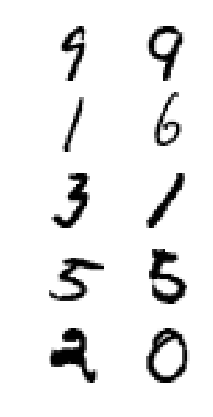

In [66]:
plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

레이블을 확인해 보겠습니다(0은 "다른 것", 1은 "같은 것"을 의미합니다):

In [67]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

완벽하네요!

### 10.3.
_문제: 이 훈련 세트로 DNN을 훈련시키세요. 각각의 이미지 쌍에서 첫 번째 이미지는 DNN A에, 두 번째 이미지는 DNN B에 동시에 주입합니다. 전체 네트워크는 두 이미지가 같은 클래스인지 아닌지 구분하도록 점차 학습될 것입니다._

MNIST 테스트 세트에서 추출한 이미지 쌍으로 테스트 세트를 만듭니다:

In [68]:
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

이제 모델을 훈련시킵니다. `batch_size`가 크다는 것외에는 이 단계에 특별한 것은 없습니다. 배치 사이즈가 크지 않으면 모델이 학습을 실패하고 50% 정확도밖에 도달하지 못할 것입니다:

In [69]:
n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "훈련 손실:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")

0 훈련 손실: 0.5908809
0 테스트 정확도: 0.6774
1 훈련 손실: 0.3974472
2 훈련 손실: 0.3337296
3 훈련 손실: 0.28122666
4 훈련 손실: 0.22434346
5 훈련 손실: 0.16687244
5 테스트 정확도: 0.9156
6 훈련 손실: 0.2250218
7 훈련 손실: 0.16899718
8 훈련 손실: 0.15540238
9 훈련 손실: 0.17644541
10 훈련 손실: 0.11150016
10 테스트 정확도: 0.9416
11 훈련 손실: 0.16785611
12 훈련 손실: 0.12579024
13 훈련 손실: 0.121470354
14 훈련 손실: 0.10476015
15 훈련 손실: 0.08949116
15 테스트 정확도: 0.9523
16 훈련 손실: 0.12330383
17 훈련 손실: 0.1032713
18 훈련 손실: 0.12114446
19 훈련 손실: 0.121041924
20 훈련 손실: 0.113421455
20 테스트 정확도: 0.9593
21 훈련 손실: 0.089824066
22 훈련 손실: 0.09780993
23 훈련 손실: 0.09179806
24 훈련 손실: 0.088439725
25 훈련 손실: 0.08158132
25 테스트 정확도: 0.962
26 훈련 손실: 0.10237064
27 훈련 손실: 0.07873487
28 훈련 손실: 0.0986035
29 훈련 손실: 0.059484202
30 훈련 손실: 0.06356913
30 테스트 정확도: 0.966
31 훈련 손실: 0.08107378
32 훈련 손실: 0.056234695
33 훈련 손실: 0.031837173
34 훈련 손실: 0.05902724
35 훈련 손실: 0.034870278
35 테스트 정확도: 0.9707
36 훈련 손실: 0.05217493
37 훈련 손실: 0.030188724
38 훈련 손실: 0.030357907
39 훈련 손실: 0.044530723
40 훈련 손실: 0.0485

좋습니다. 숫자 비교 작업에서 97.6% 정확도를 달성했습니다. 아주 나쁘지 않네요. 이 모델은 손글씨 숫자를 비교하는 능력을 갖추었습니다!

이 지식을 일반 MNIST 분류 문제에 사용할 수 있는지 확인해 보겠습니다.

### 10.4.
_문제: 이제 DNN A의 은닉층을 동결해서 재사용하고 10개의 뉴런으로 된 소프트맥스 출력 층을 추가한 새로운 DNN을 만듭니다. 이 네트워크를 분할 #2에 대해 훈련시켜보고 클래스당 500개의 이미지만으로도 높은 성능을 얻을 수 있는지 확인해보세요._

모델을 만드는 것은 매우 간단합니다. 하위층을 동결하는 방법이 많이 있습니다. 이 예제에서는 `tf.stop_gradient()` 함수를 사용하겠습니다. 미리 학습된 DNN A를 복원하기 위해 `Saver` 객체가 필요하고 최종 모델을 저장하기 위해 다른 `Saver` 객체가 필요합니다:

In [70]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

이제 훈련입니다! 모든 변수를 초기화하고(새 출력층의 변수를 포함하여), 미리 학습된 DNN A를 복원합니다. 다음에 작은 MNIST 데이터셋(5,000개 이미지)에 이 모델을 훈련시킵니다:

In [71]:
n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 테스트 정확도: 0.9414
10 테스트 정확도: 0.9652
20 테스트 정확도: 0.9656
30 테스트 정확도: 0.966
40 테스트 정확도: 0.966
50 테스트 정확도: 0.9662
60 테스트 정확도: 0.9663
70 테스트 정확도: 0.9663
80 테스트 정확도: 0.9665
90 테스트 정확도: 0.9667


오 96.7% 정확도네요. 지금까지 훈련시킨 최고의 MNIST 모델은 아니지만 아주 작은 훈련 세트(숫자당 500개 이미지)를 사용한 것을 유념하세요. 전이 학습을 사용하지 않고 그냥 처음부터 학습시킨 DNN과 결과를 비교해 보겠습니다:

In [72]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [73]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "테스트 정확도:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 테스트 정확도: 0.8926
10 테스트 정확도: 0.9383
20 테스트 정확도: 0.9439
30 테스트 정확도: 0.9433
40 테스트 정확도: 0.9438
50 테스트 정확도: 0.9437
60 테스트 정확도: 0.944
70 테스트 정확도: 0.9441
80 테스트 정확도: 0.9439
90 테스트 정확도: 0.944
100 테스트 정확도: 0.9439
110 테스트 정확도: 0.9441
120 테스트 정확도: 0.9441
130 테스트 정확도: 0.944
140 테스트 정확도: 0.9439


94.8% 정확도 밖에 안되네요. 전이 학습이 에러율를 5.2%에서 3.3%로 낮추어 주었습니다(36% 이상 에러가 감소했습니다). 더군다나 전이 학습을 사용한 모델은 10번의 에포크만에 96%의 정확도에 도달했습니다.

최종 결과: 전이 학습이 항상 좋은 결과를 내지는 않습니다(연습문제 9에서 보았듯이). 하지만 그렇지 않을 땐 아주 큰 차이를 만들 수 있습니다. 그러므로 꼭 시도해 보세요!